# Performance Analysis of Hedge Fund Daily Returns using Linear Regression
In this notebook, we perform analysis on 
- Fama-French 5 Factors Model and 
- 10 Industry Portfolios Model

----------
## PART ONE: Analysis on Fama-French 5 Factors Model

### Datasets:
**FF5**:
- Daily data of the [Fama-French 5 Factor model](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_5_factors_2x3_daily.html)
- [Ken French data library](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)
- 1963-07-01 to 2021-02-26

**AQR**:
- Daily returns for the AQR Equity Market Neutral Fund Class I (Ticker: QMNIX). 
- Get the series that is adjested for both dividends and splits (i.e. **Adj Close**)
- Obtain prices from Yahoo Finance, and calculate monthly returns
- 2014-11 to 2021-04

### FF5 Model:

- Testing CAPM or related models:
    - It makes sense to regress (1) the **excess returns** of the fund on (2) the **excess returns** of the market and other factors. This type of setup is often common when testing CAPM and related models.
    - What does the **excess return** of the market represent? It is a measure of the equity risk premium, i.e. the risk premium associated with equities above that of the risk-free rate. 

- Market model with multiple factors:
    - Here, in this notebook, we are regressing (1) the returns of the fund on (2) the returns of the market and other factors, instead of excess return (market - rf). 
    - This type of setup is often referred to as the market model (with multiple factors). 

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import seaborn as sns 
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import statsmodels.stats.api as sms
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (20.0, 9.0)
import warnings
warnings.filterwarnings('ignore')

C:\Users\xxxli\Anaconda3\envs\mysixenv\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\xxxli\Anaconda3\envs\mysixenv\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\xxxli\Anaconda3\envs\mysixenv\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


### I. Download and import data
These are common questions about dataset: What is the format? How is the data reported? What are its units? etc. It is part of the problem for me to figure it out in a real woring environment.  

### I.A) Fama-French 5 Factors daily data
- web scraping

In [2]:
import pandas_datareader.data as web
FF5_m = web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench', start = '1963-07-01', end = '2021-02-26')[0]
FF5_m['Mkt-RF'] = FF5_m['Mkt-RF'] + FF5_m['RF']
FF5_m.rename(columns={'Mkt-RF':'MktRet'},inplace=True)
FF5_m_RF = FF5_m.copy(deep=True)
FF5_m.drop(columns='RF', inplace=True)
FF5_m

,MktRet,SMB,HML,RMW,CMA
Date,,,,,
1963-07-01,-0.658,0.00,-0.34,-0.01,0.15
1963-07-02,0.802,-0.27,0.27,-0.07,-0.19
1963-07-03,0.642,-0.17,-0.10,0.17,-0.33
1963-07-05,0.412,0.08,-0.27,0.08,-0.33
1963-07-08,-0.618,0.04,-0.19,-0.29,0.13
...,...,...,...,...,...
2021-02-22,-1.120,0.68,3.14,1.66,0.90
2021-02-23,-0.150,-1.05,0.90,1.08,-0.19
2021-02-24,1.150,1.48,1.34,-0.29,0.32


In [3]:
print(f"FF5 daily:{FF5_m.shape}")
print(f"missing values: {FF5_m.isnull().any().sum()}")
b1, e1 = FF5_m.index[0], FF5_m.index[-1]
print(f"Starting from {str(b1)[:10]} to {str(e1)[:10]}")

FF5 daily:(14514, 5)
missing values: 0
Starting from 1963-07-01 to 2021-02-26


### I.B) AQR daily prices

In [4]:
import yfinance as yf
prices_m = yf.download('QMNIX', period='max', progress=False, interval='1d')
QMNIX_m = prices_m[['Adj Close']]
QMNIX_m

,Adj Close
Date,
2014-10-09,8.682810
2014-10-10,8.709042
2014-10-13,8.700297
2014-10-14,8.656576
2014-10-15,8.604114
...,...
2021-04-09,7.260000
2021-04-12,7.300000
2021-04-13,7.260000


In [5]:
# cleansing
to_drop = QMNIX_m[QMNIX_m.isnull().any(axis=1)] # let's see nan
QMNIX_m.drop(index=to_drop.index, inplace=True)
print(f"QMNIX daily prices:{QMNIX_m.shape}")
print(f"There are {QMNIX_m.isnull().any().sum()} missing values")
b2, e2 = QMNIX_m.index[0], QMNIX_m.index[-1]
print(f"Starting from {str(b2)[:10]}, to {str(e2)[:10]}")

QMNIX daily prices:(1640, 1)
There are 0 missing values
Starting from 2014-10-09, to 2021-04-15


### I.C) AQR monthly returns

In [6]:
def price2ret(price_df, retType='simple'):
    ''' Convert price to return.

    Args
    ----------
    price_df: pd.DataFrame
    retype: str
        simple: arithmetic return, p2/p1 - 1, same as pct_change()
        log: logarithmetic return, log(p2/p1)
    
    Returns
    ----------
    return: pd.DataFrame
    
    '''
    p = price_df.copy(deep=True)
    if retType == 'simple':
        r = (p/p.shift(1))-1
    else: 
        r = np.log(p/p.shift(1))
    p['Return'] = r
    return p.dropna()[['Return']]

In [7]:
AQR_m = price2ret(QMNIX_m,'log')
print(f"AQR daily return: {AQR_m.shape}")
print(f"missing values: {AQR_m.isnull().any().sum()}")
b3, e3 = AQR_m.index[0], AQR_m.index[-1]
print(f"Starting from {str(b3)[:10]} to {str(e3)[:10]}")

AQR daily return: (1639, 1)
missing values: 0
Starting from 2014-10-10 to 2021-04-15


### II. EDA

Data Imported:
- `FF5_m`: daily FF5 factors data
- `AQR_m`: AQR daily log returns

EDA steps:
- scatter plots 
- summary statistics (mean, std, skew, kurtosis, max, min, correlation matrix)
- make conclusions and discuss any noteworthy results

### II.A) FF5

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001CED37C64A8>,
      dtype=object)

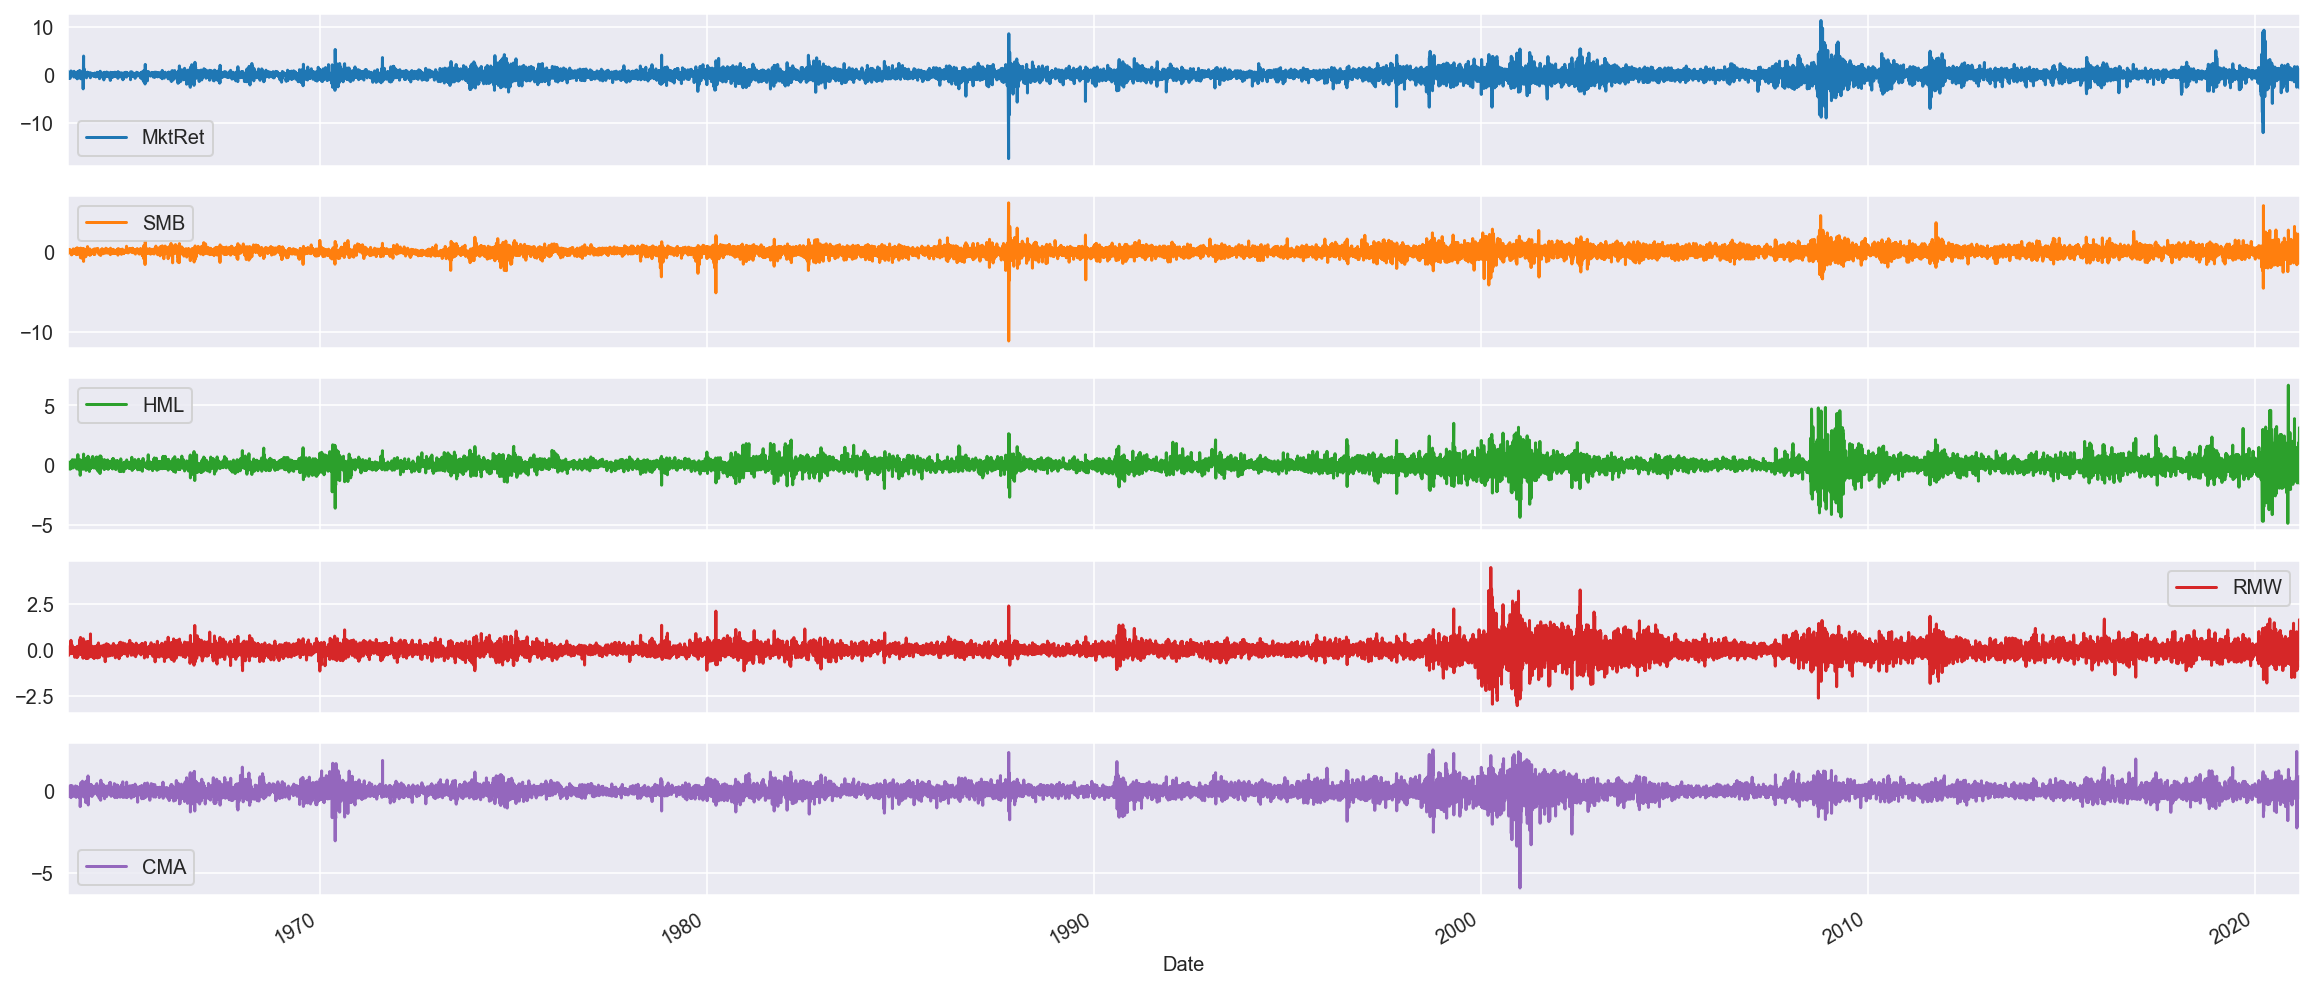

In [8]:
FF5_m.plot(subplots=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CEFED39748>,
      dtype=object)

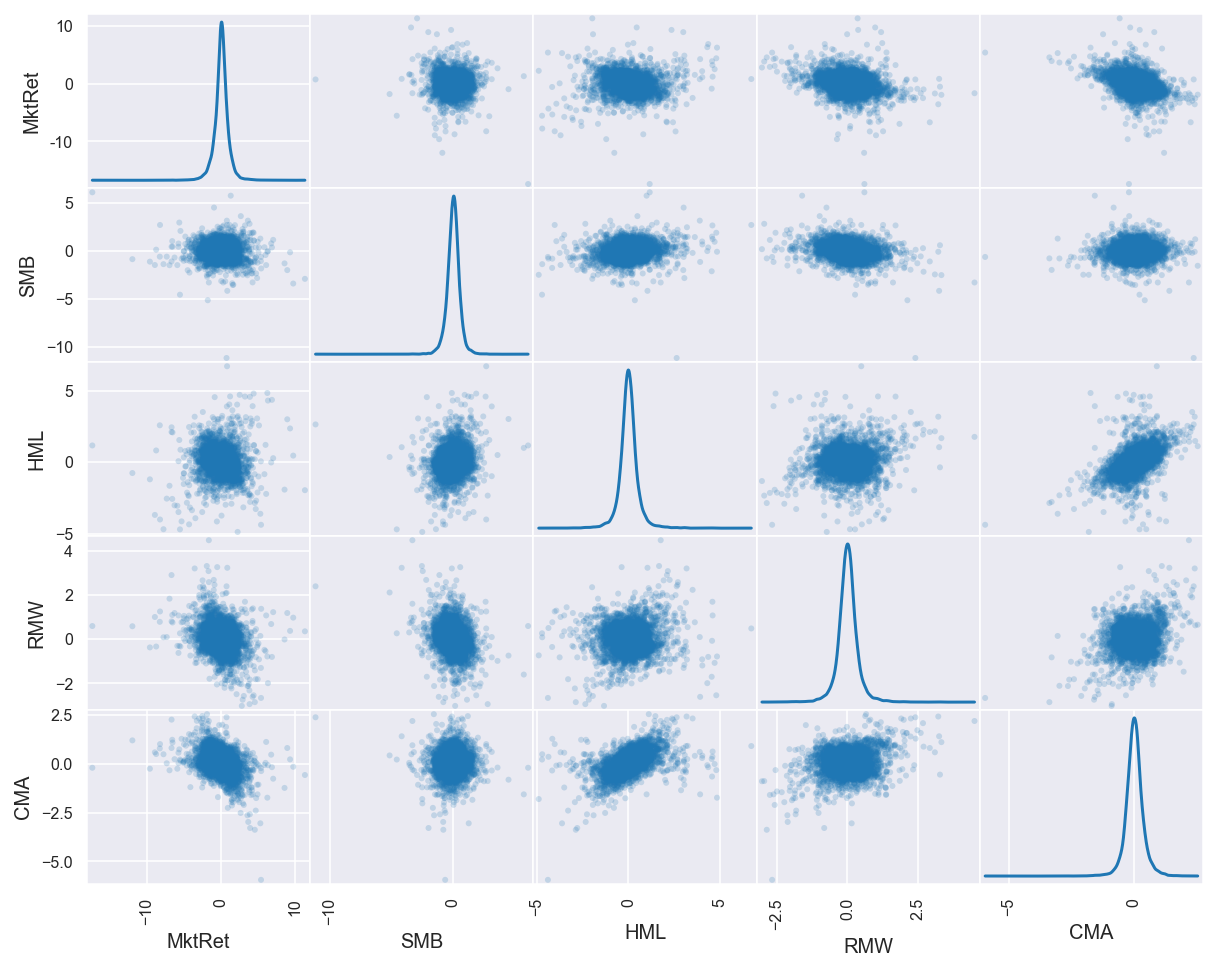

In [9]:
# among factor columns
pd.plotting.scatter_matrix(FF5_m, alpha=0.2, figsize=(10,8), diagonal='kde')

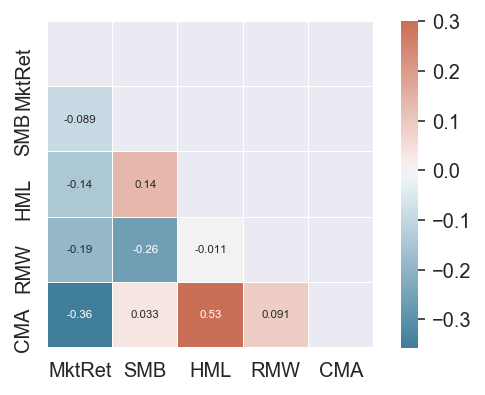

In [10]:
C = FF5_m.corr() # see correlation
mask = np.triu(np.ones_like(C, dtype=bool)) # Generate a mask for the upper triangle
f, ax = plt.subplots(figsize=(5, 3)) # Set up the matplotlib figure
cmap = sns.diverging_palette(230, 20, as_cmap=True) # Generate a custom diverging colormap
sns.heatmap(C, annot=True, annot_kws = {'fontsize':'xx-small'} ,mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.01) # Draw the heatmap with the mask and correct aspect ratio

In [11]:
FF5_m.agg(['mean','std','skew','kurtosis','max','min'])

,MktRet,SMB,HML,RMW,CMA
mean,0.045125,0.008258,0.013365,0.012177,0.012545
std,1.014176,0.534342,0.548423,0.376501,0.367682
skew,-0.566871,-0.757686,0.369111,0.299968,-0.366114
kurtosis,16.708010,19.628894,12.832247,9.909156,10.692202
max,11.354000,6.080000,6.700000,4.490000,2.530000
min,-17.413000,-11.170000,-4.890000,-3.020000,-5.940000


FF5 Findings:
- Something strange around 2000, can do further research.
- There are some factors are sort of correlated with other, such as HML vs CMA.

### II.B) AQR daily returns

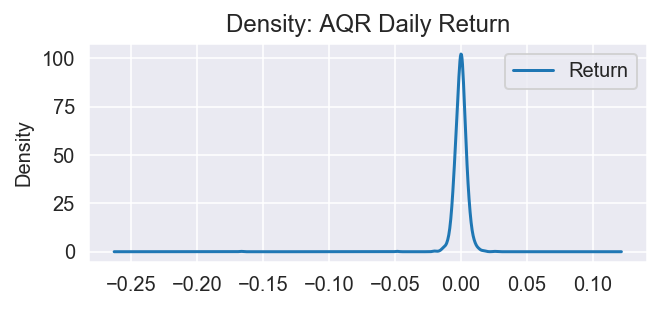

In [12]:
AQR_m.plot(kind='kde', figsize=(5,2), title='Density: AQR Daily Return')

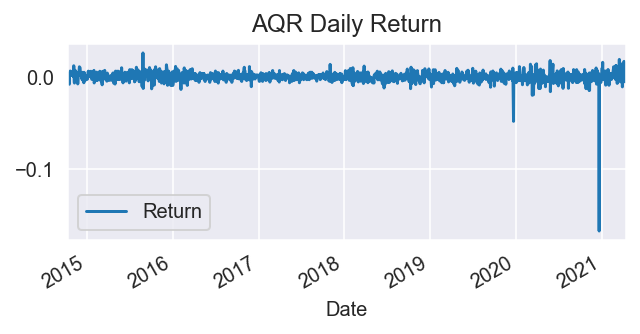

In [13]:
AQR_m.plot(figsize=(5,2), title='AQR Daily Return')

In [14]:
AQR_m.agg(['mean','std','skew','kurtosis','max','min'])

,Return
mean,-0.000110
std,0.006083
skew,-12.789544
kurtosis,345.221453
max,0.025619
min,-0.166690


AQR Daily Returns Findings:
- Pay attention on extremes, such as what impacted AQR before 2021.

### II.C) Relationship between FF5 and AQR returns:

In [15]:
start = max(b1, b3)
end = min(e1, e3)
print('For scatter plots, we need consistent start/end dates for two datasets:')
print('start_date: ', str(start)[:10])
print('end_date: ', str(end)[:10])

FF5_m_2 = FF5_m.loc[start:end]
AQR_m_2 = AQR_m.loc[start:end]

data_all_m = pd.merge(AQR_m_2, FF5_m_2, left_index=True, right_index=True)
print(data_all_m.shape)
data_all_m

For scatter plots, we need consistent start/end dates for two datasets:
start_date:  2014-10-10
end_date:  2021-02-26
(1606, 6)


,Return,MktRet,SMB,HML,RMW,CMA
Date,,,,,,
2014-10-10,0.003017,-1.30,-0.07,0.51,0.76,0.37
2014-10-13,-0.001005,-1.59,1.31,0.49,-0.32,0.22
2014-10-14,-0.005038,0.28,0.82,-0.12,0.01,0.07
2014-10-15,-0.006079,-0.53,1.65,-1.33,-0.48,-0.59
2014-10-16,-0.008163,0.22,1.07,0.24,-0.45,0.12
...,...,...,...,...,...,...
2021-02-22,0.010712,-1.12,0.68,3.14,1.66,0.90
2021-02-23,0.000000,-0.15,-1.05,0.90,1.08,-0.19
2021-02-24,0.004556,1.15,1.48,1.34,-0.29,0.32


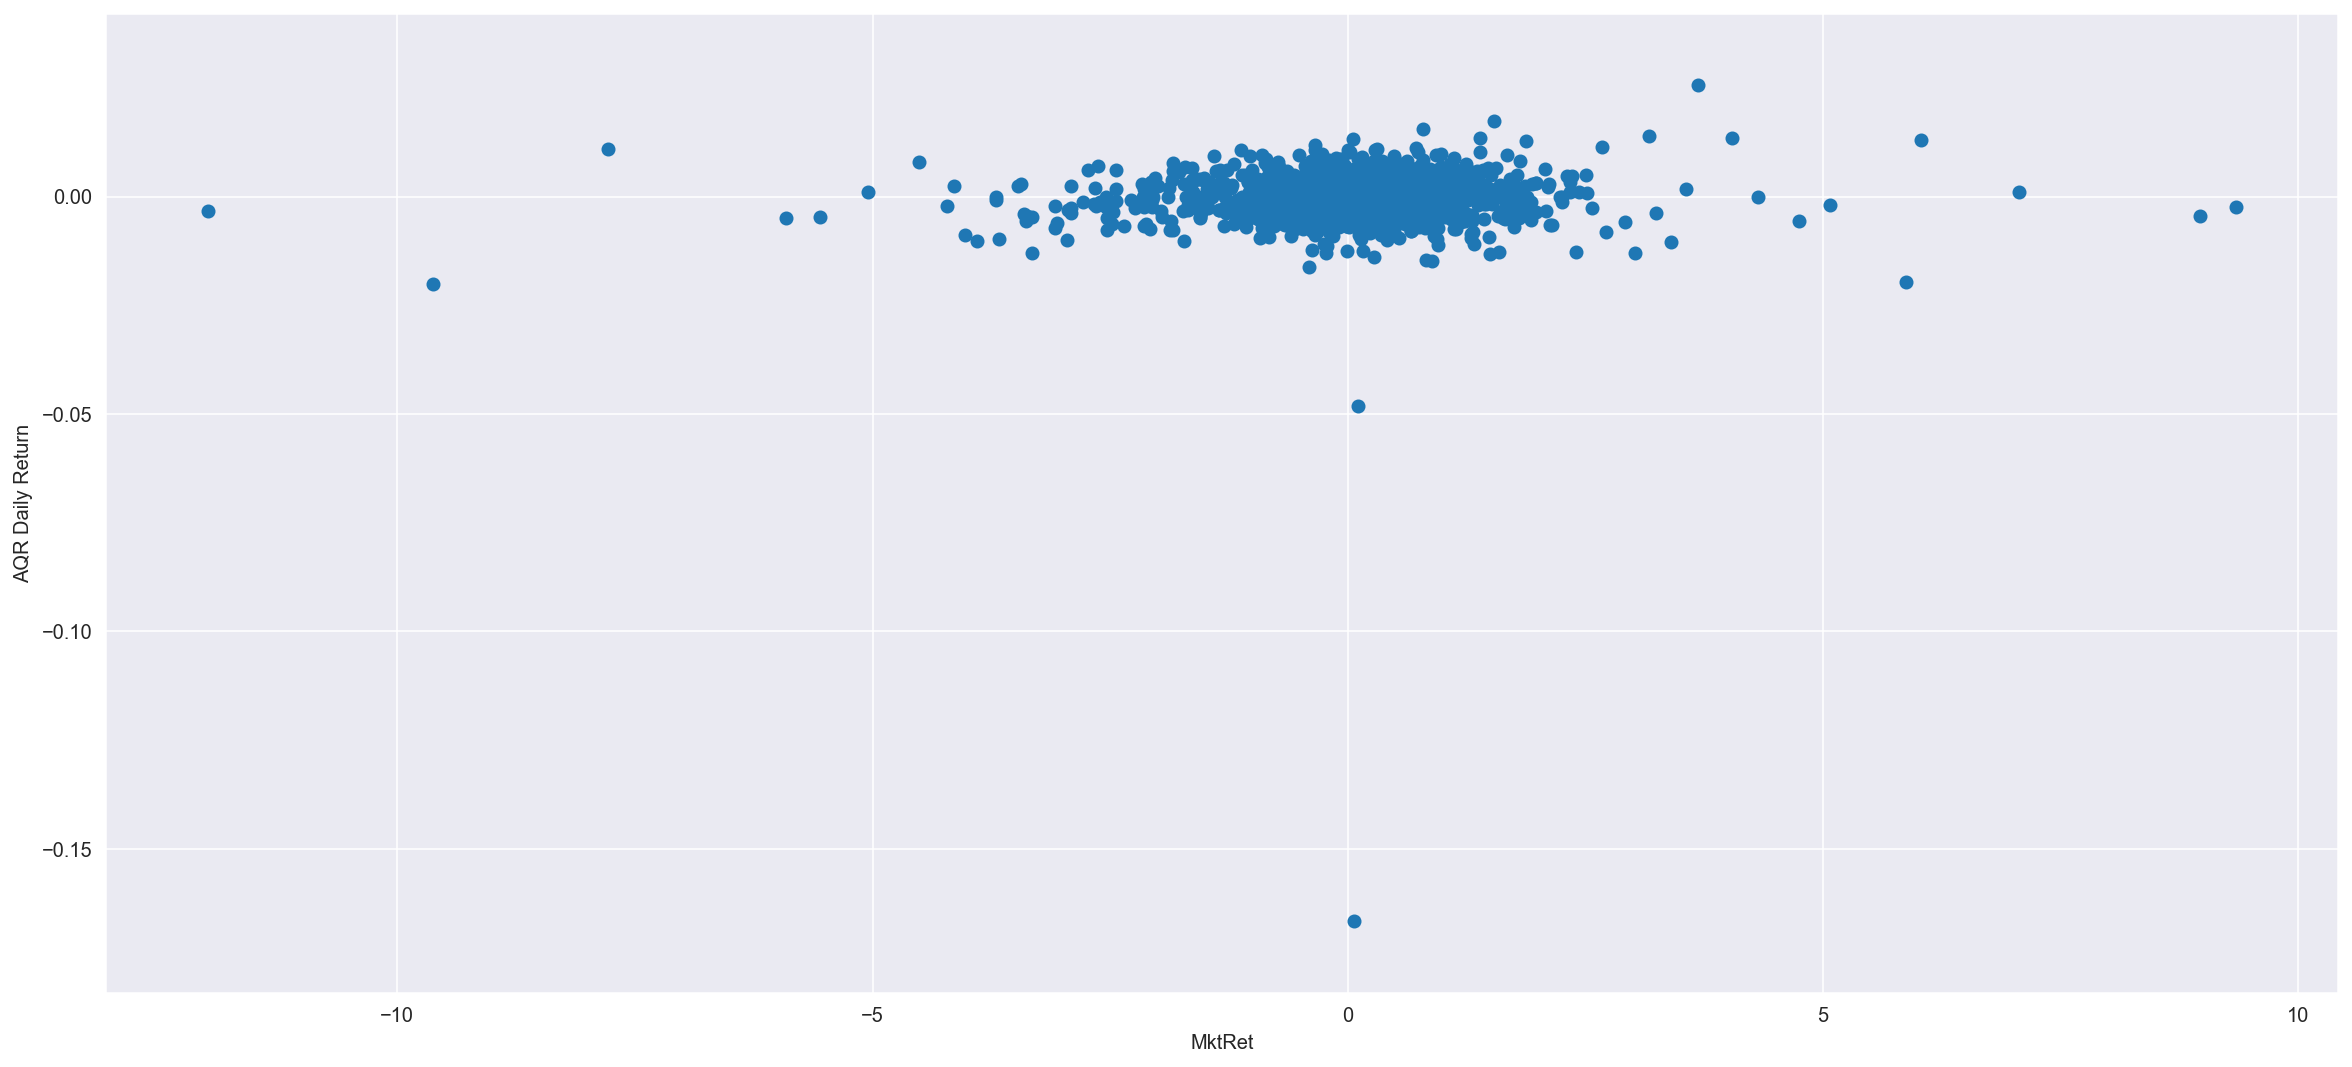

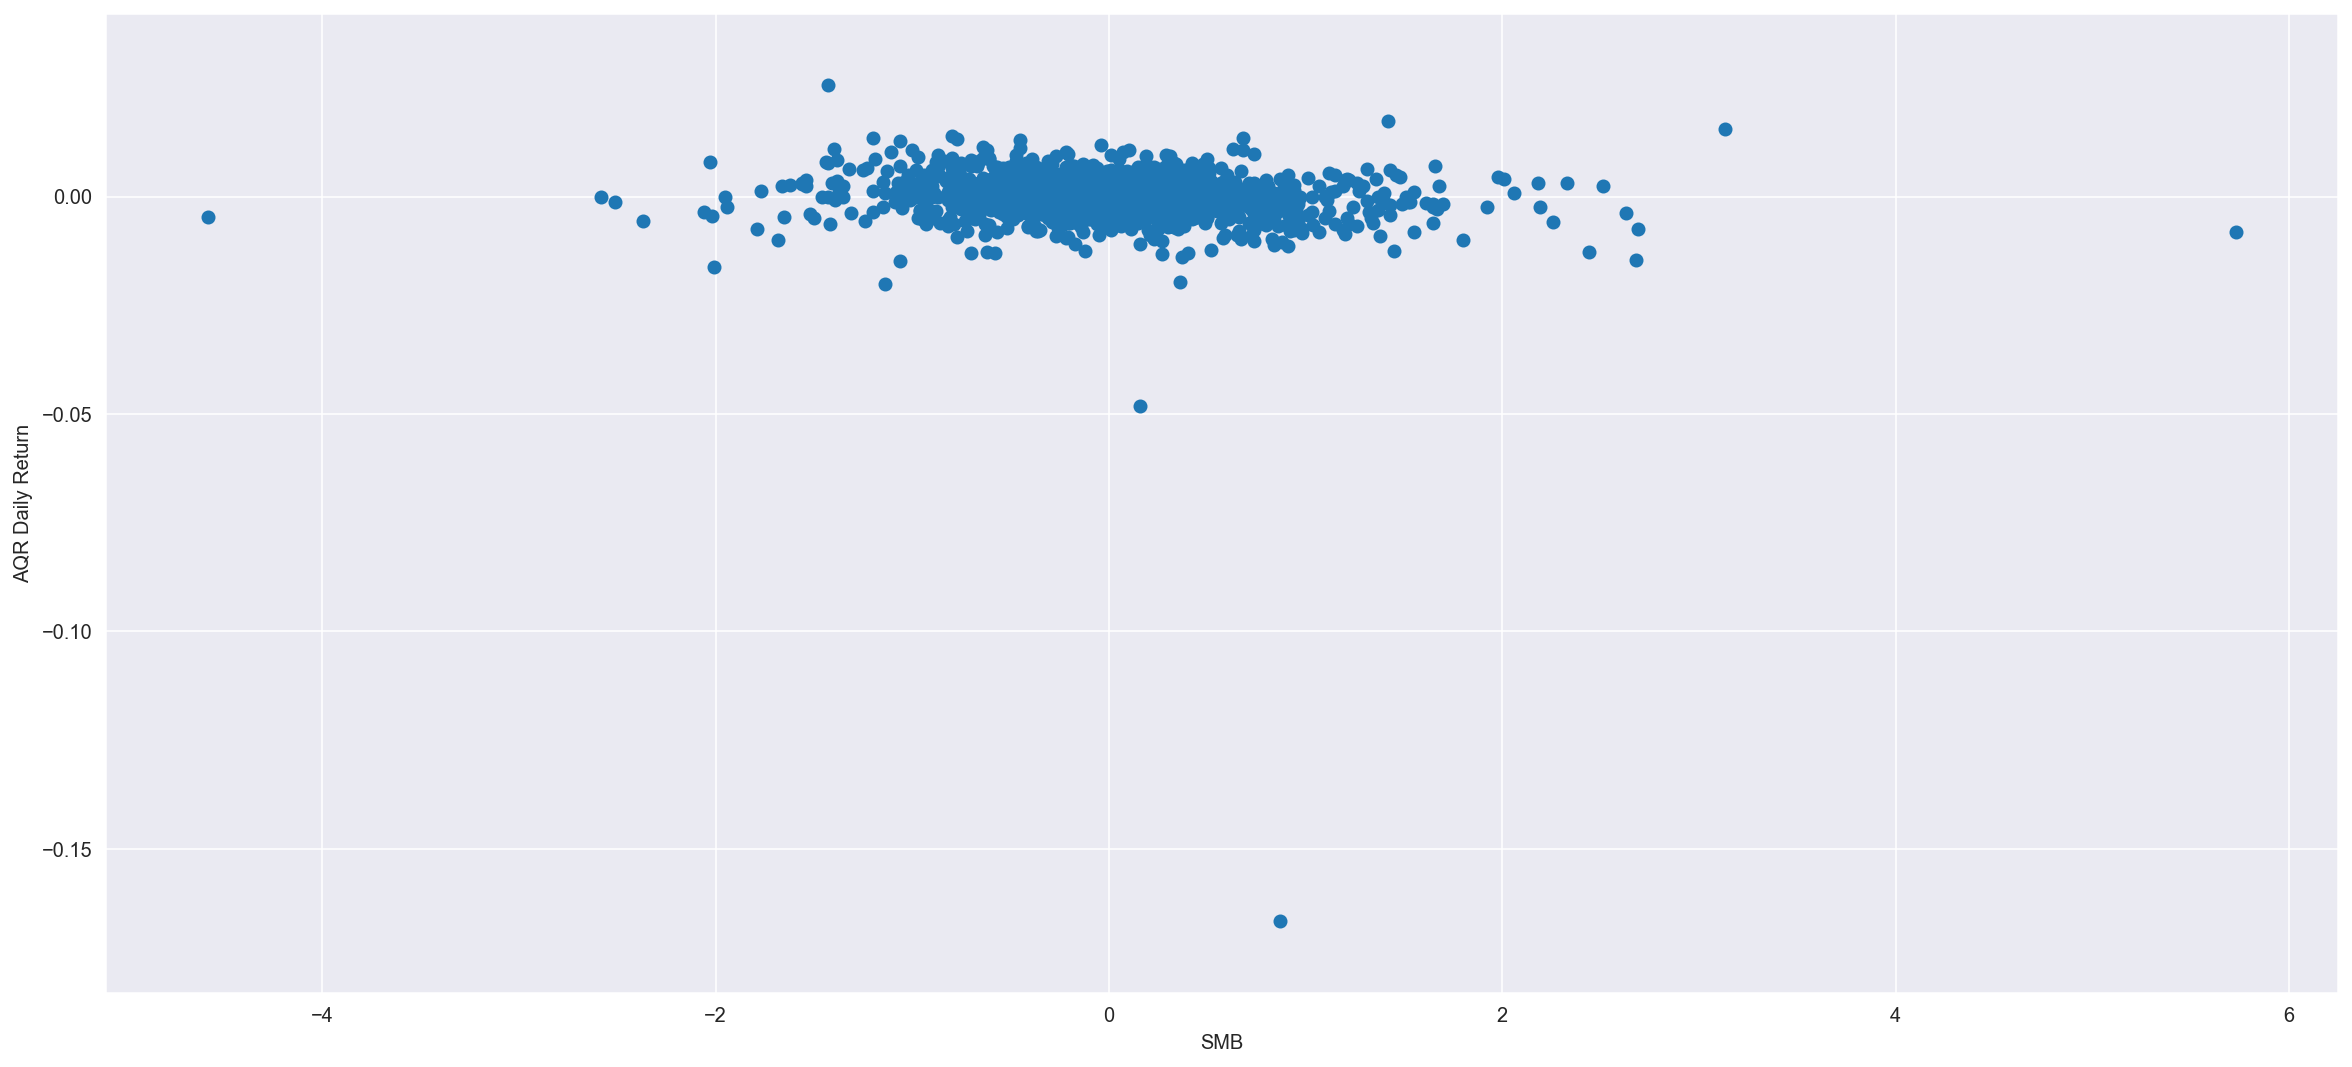

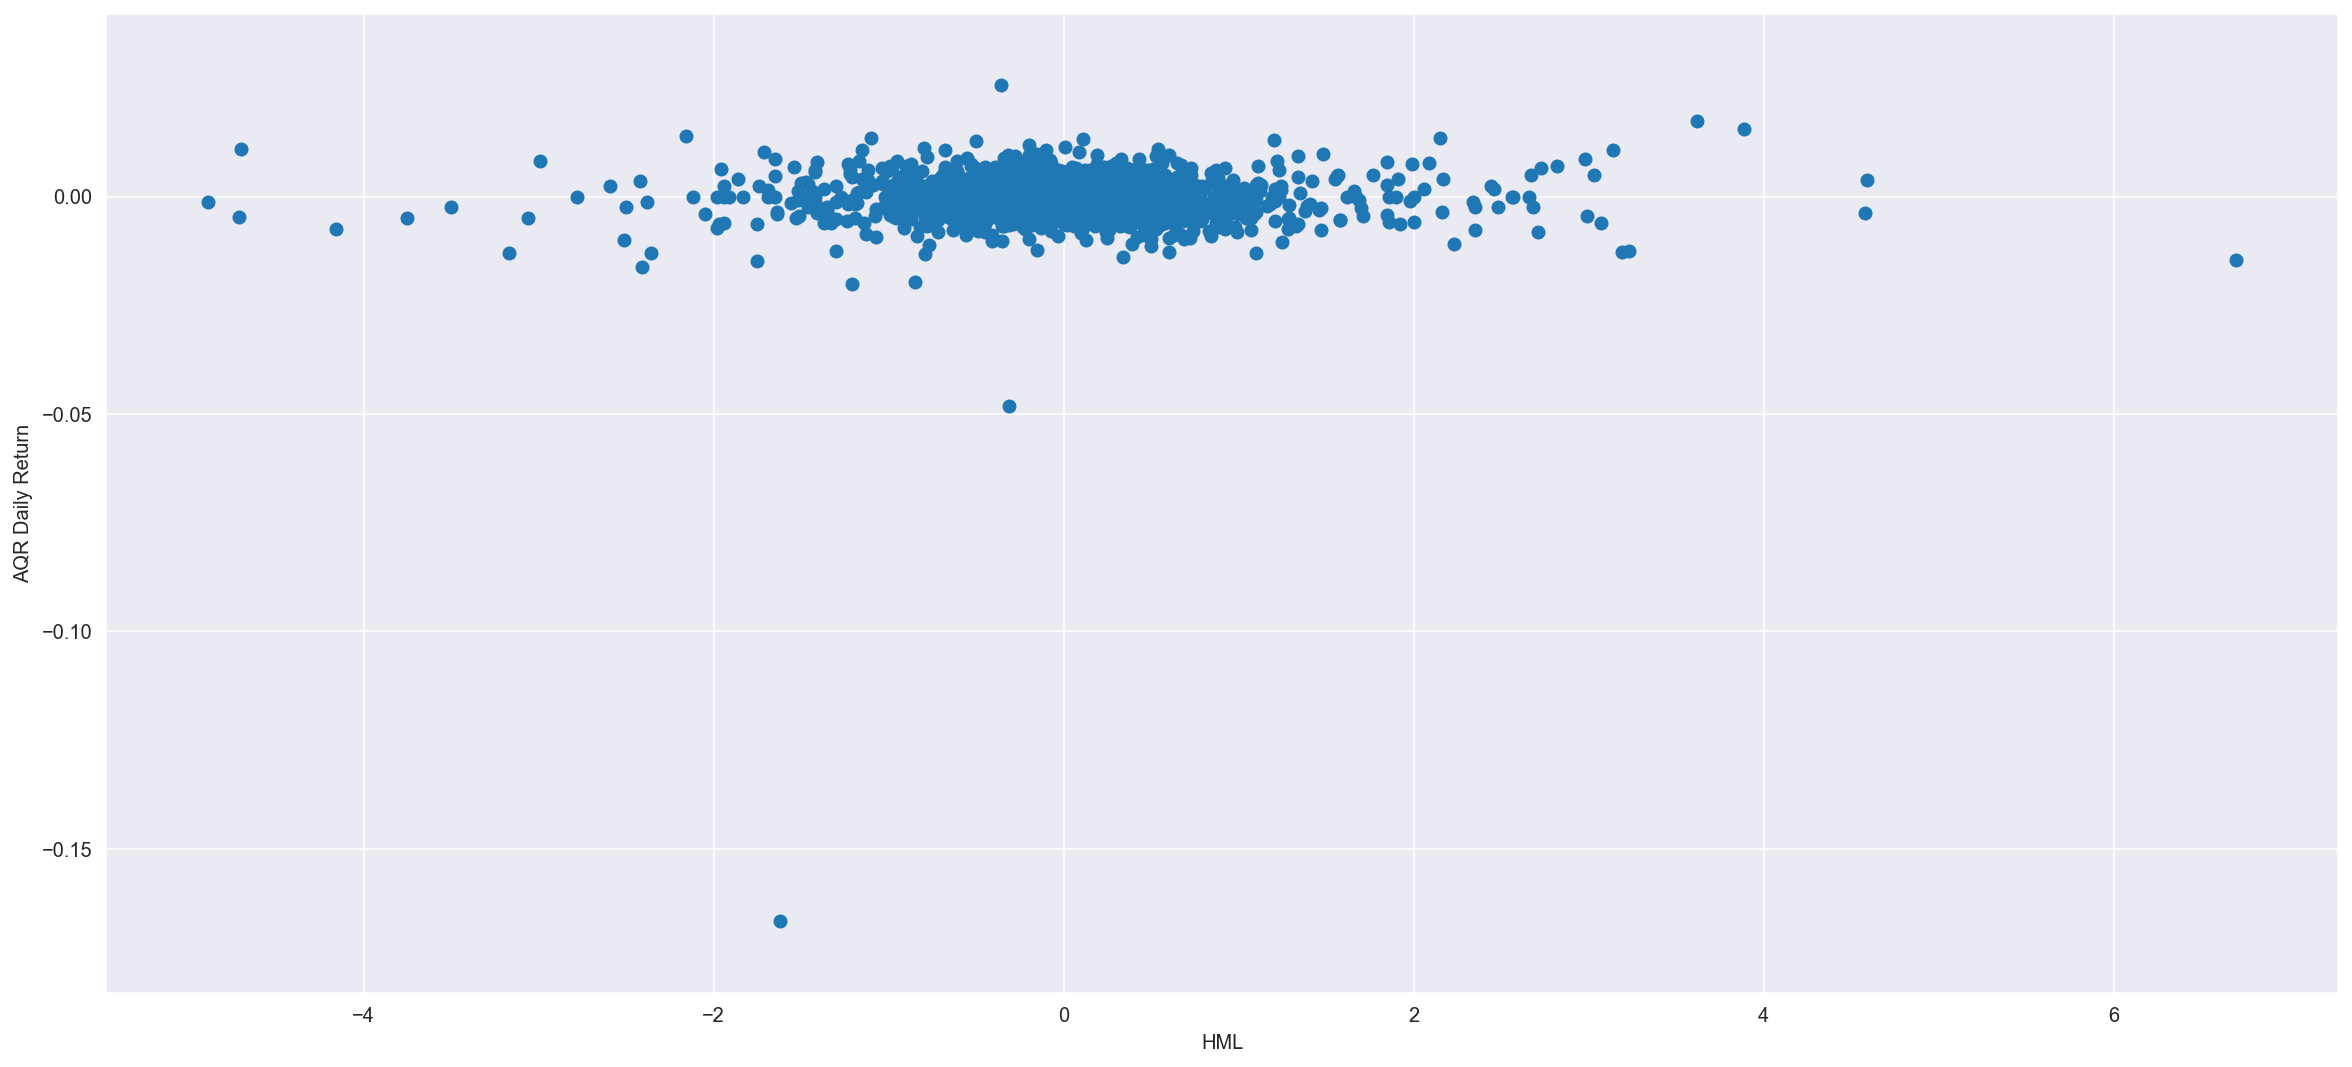

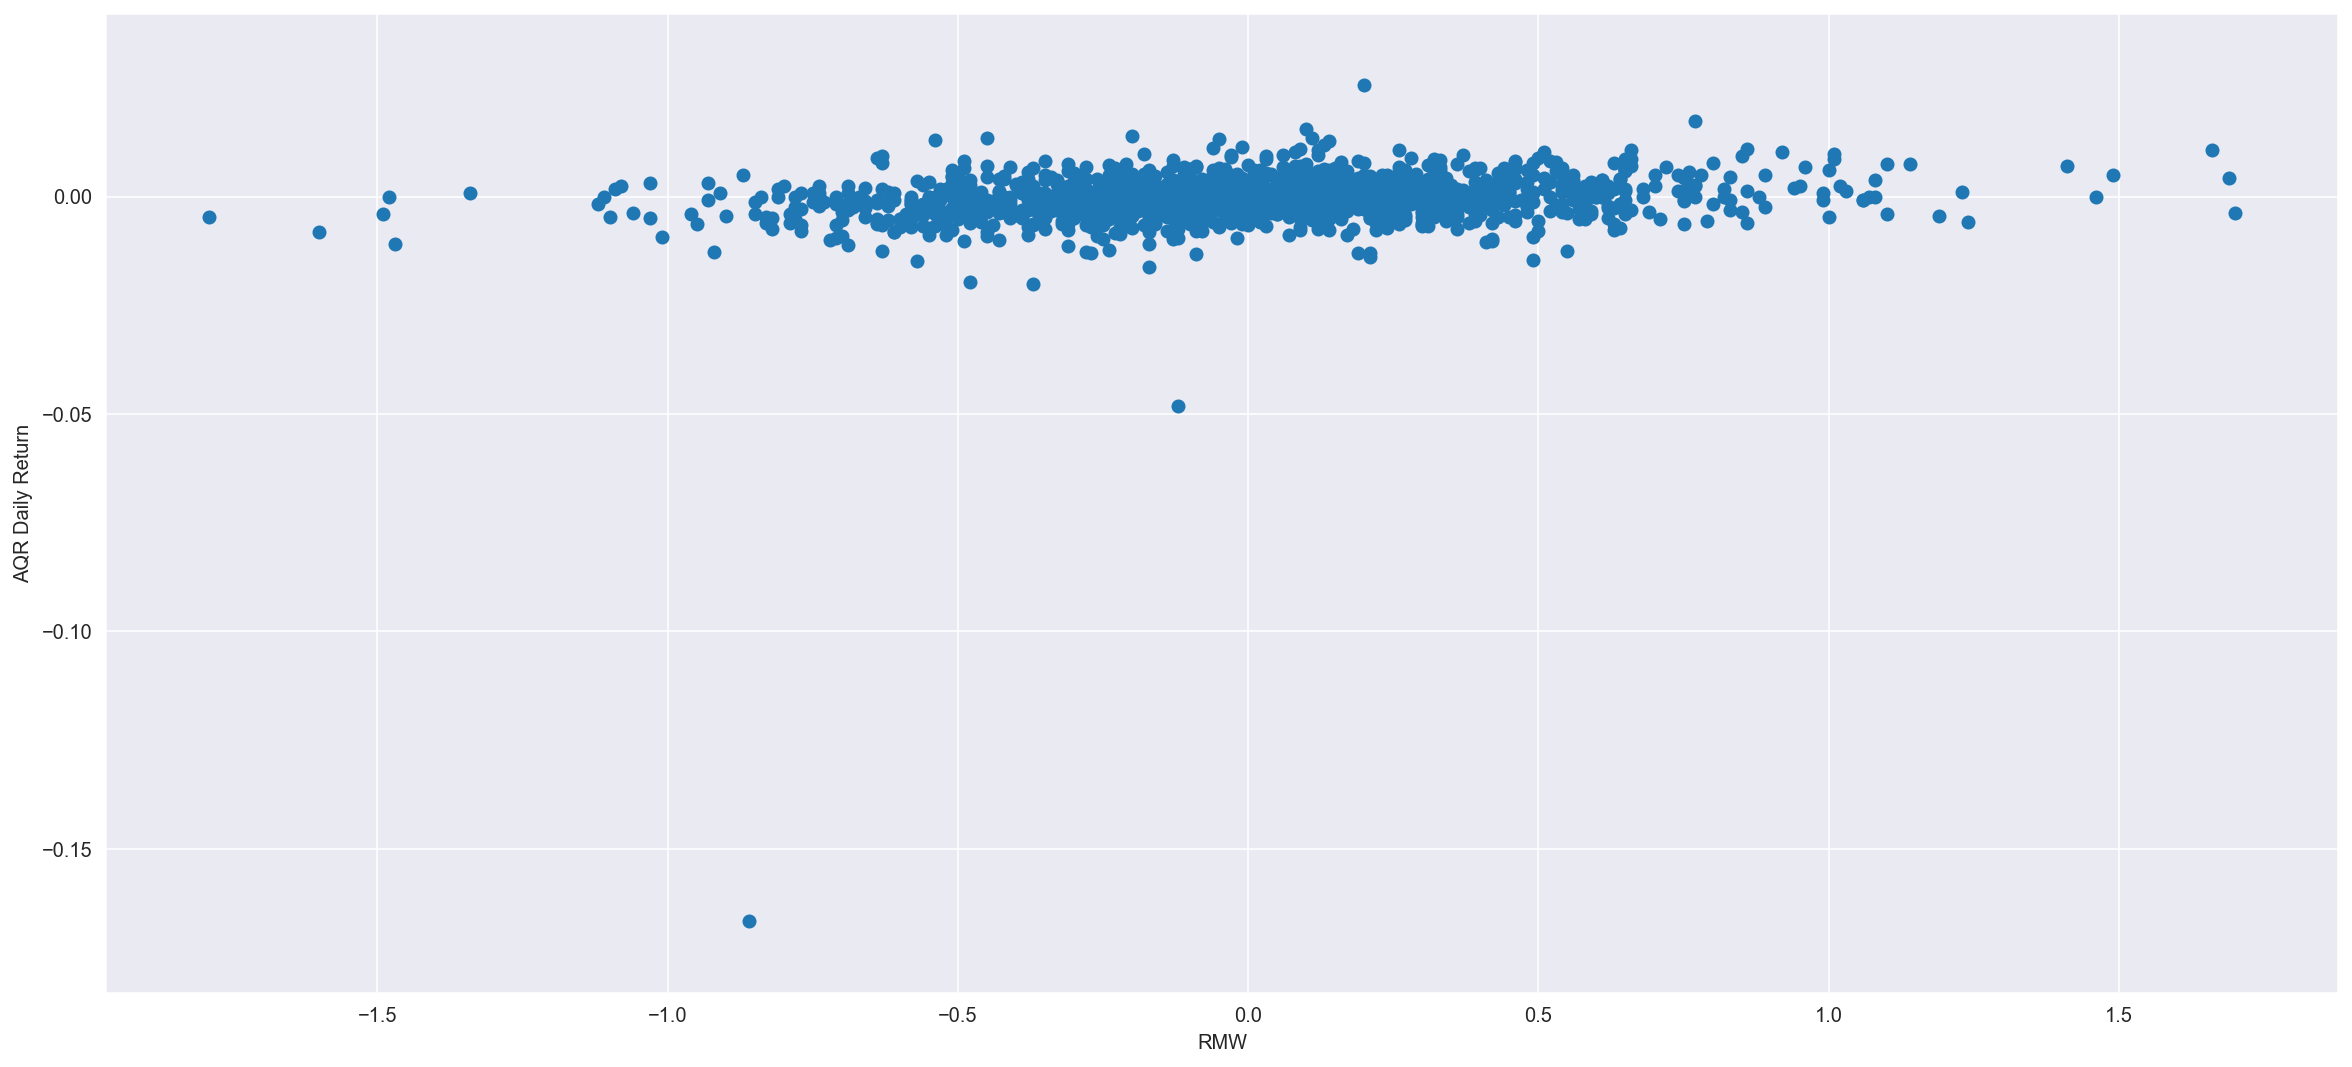

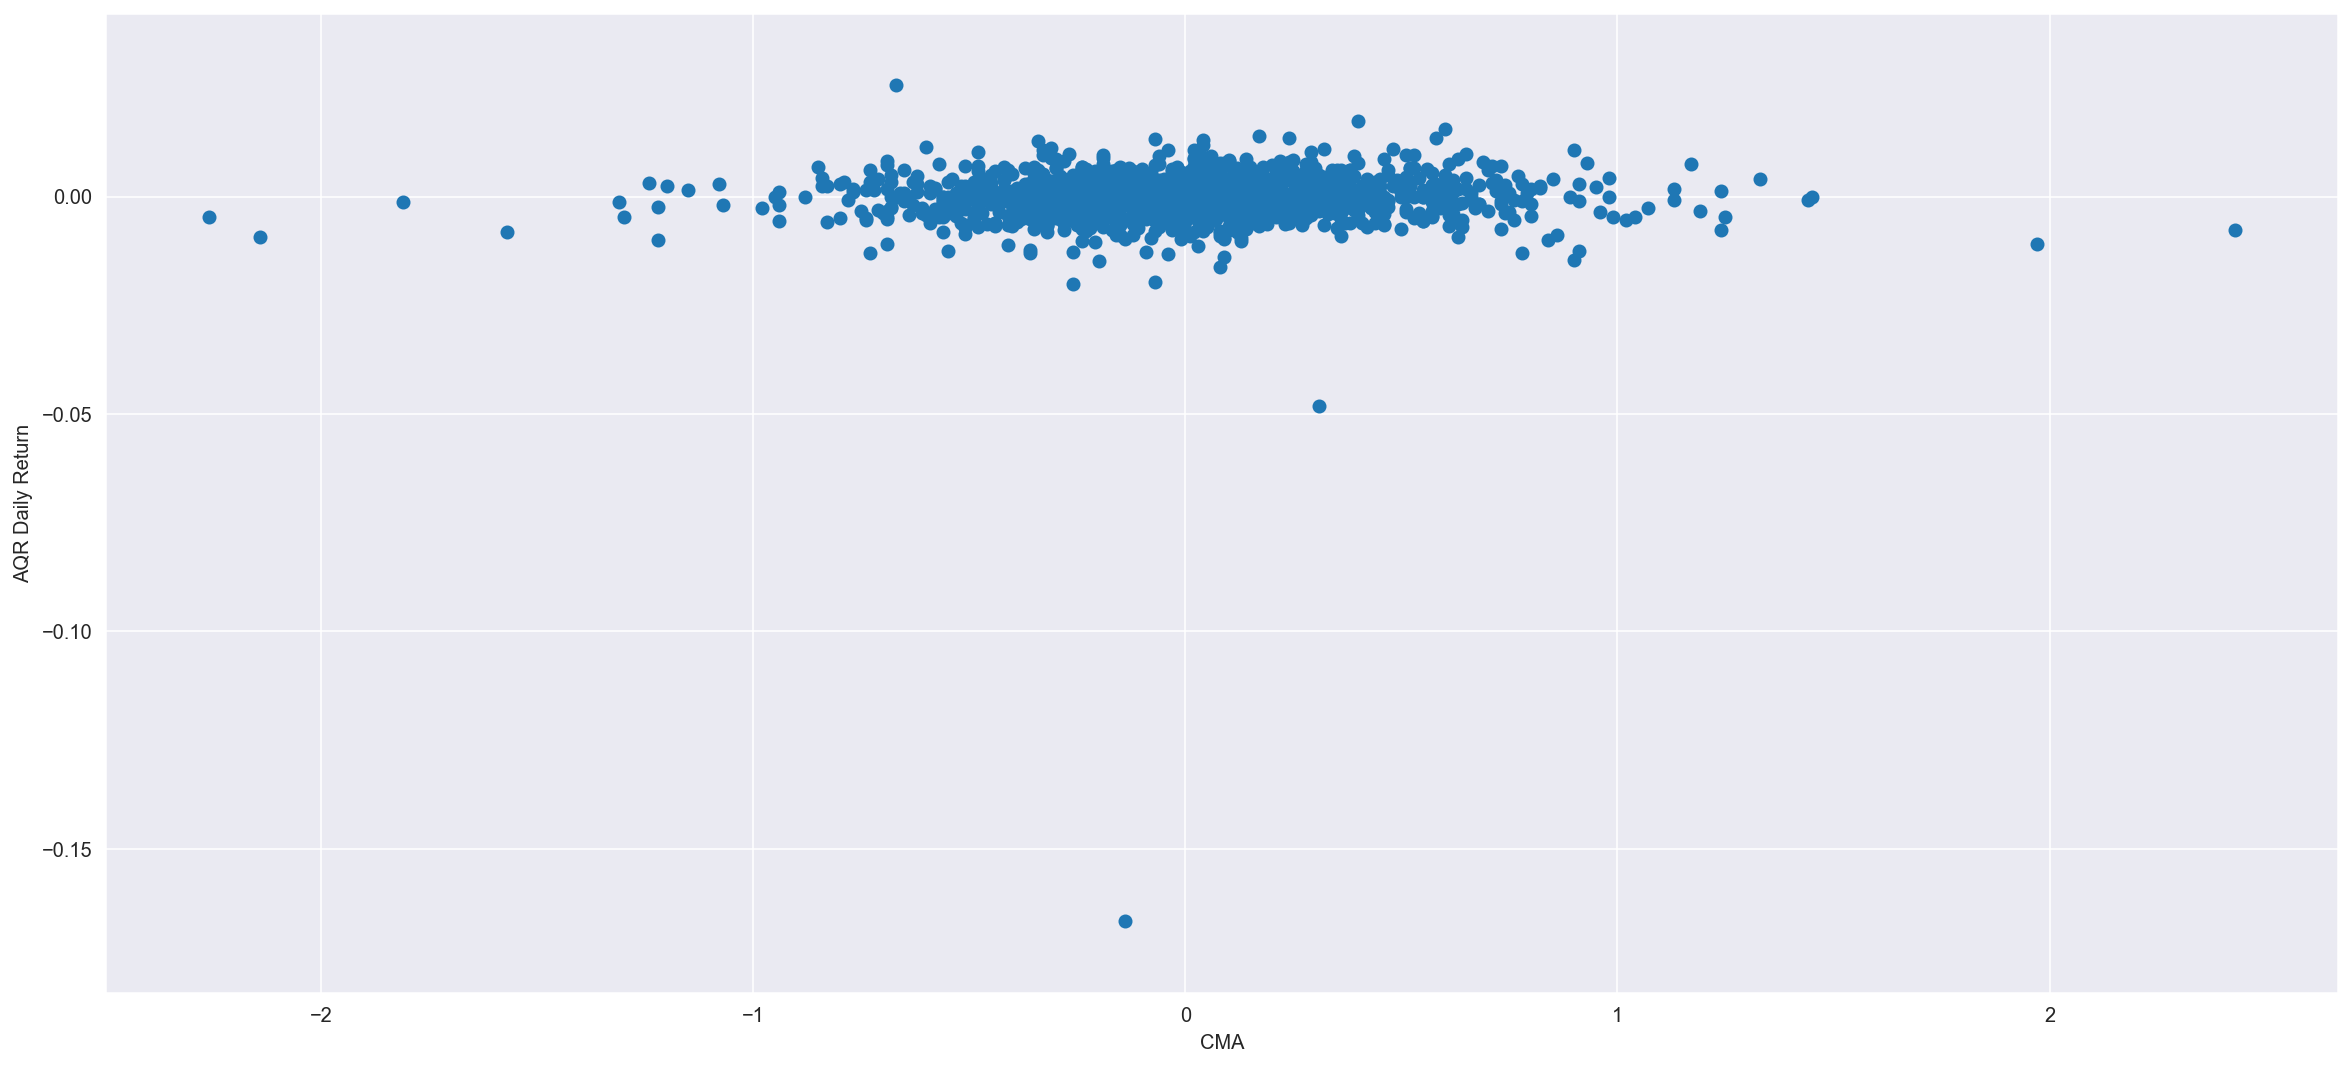

In [16]:
attributes = FF5_m_2.columns
for att in attributes:
    # plt.figure(figsize=(5,5))
    plt.scatter(FF5_m_2[att], AQR_m_2['Return'])
    plt.xlabel(att)
    plt.ylabel('AQR Daily Return')
    plt.show()

In [17]:
# correlations
print(data_all_m.corr()[['Return']])

          Return
Return  1.000000
MktRet  0.051055
SMB    -0.139353
HML     0.031416
RMW     0.205188
CMA     0.028037


Factors and AQR return Findings:
- In short, monthly data is a small sample, lack of obvious and strong conclusions can be made through scatter plots.
- Here, we see a better result in daily data, where
    - something...
    - something...


### II.D) Perform tests for stationarity of all data series.
The **Augmented Dickey-Fuller test** is a type of statistical test called a unit root test.

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The **null hypothesis** of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The **alternate hypothesis** (rejecting the null hypothesis) is that the time series is stationary.

**Null Hypothesis (H0)**: If failed to be rejected, it suggests the time series has a unit root, meaning it is **non-stationary**. It has some time dependent structure.
**Alternate Hypothesis (Ha)**: The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is **stationary**. It does not have time-dependent structure.

We interpret this result using the **p-value** from the test. 
- **p-value > 0.05**: Fail to reject the null hypothesis (H0), the data has a unit root and is **non-stationary**.
- **p-value <= 0.05**: Reject the null hypothesis (H0), the data does not have a unit root and is **stationary**.

In [18]:
from statsmodels.tsa.stattools import adfuller
sig = 0.05
print(f'Performing ADF test... at significant level = {sig}')
for i in FF5_m_RF.columns:
    print('-'*15)
    print(f'{i}')
    result = adfuller(FF5_m_RF[i])
    print(f'  p-value: {result[1]}')
    if result[1] > sig:
        print('  Result: non-stationary')
    else:
        print('  Result: stationary')

for i in AQR_m.columns:
    print('-'*15)
    print(f'{i}')
    result = adfuller(AQR_m[i])
    print(f'  p-value: {result[1]}')
    if result[1] > sig:
        print('  Result: non-stationary')
    else:
        print('  Result: stationary')

Performing ADF test... at significant level = 0.05
---------------
MktRet
  p-value: 0.0
  Result: stationary
---------------
SMB
  p-value: 0.0
  Result: stationary
---------------
HML
  p-value: 2.6820591776272696e-29
  Result: stationary
---------------
RMW
  p-value: 5.751878323804821e-30
  Result: stationary
---------------
CMA
  p-value: 9.596981375054592e-30
  Result: stationary
---------------
RF
  p-value: 0.169546798461722
  Result: non-stationary
---------------
Return
  p-value: 0.0
  Result: stationary


Stationary Finding:
- Based on ADF test, the time series of risk-free rate is the only one that is non-stationary.

### III. Regression
- Regress AQR daily returns on the Fama-French factors 
- Discuss the regression results, including 
    - t-test, 
    - F-test,
    - $R^2$. 
    - Is the intercept statistically different from 0?

**Model**
$$\text{AQR Return}_i = a_i + b_i*\text{MktRet} + s_i*\text{SMB} + h_i*\text{HMI} + r_i*\text{RMW} + c_i*\text{CMA} + \epsilon_i$$

In [19]:
# regressors: 5 Factors
X_m = data_all_m[data_all_m.columns[1:]]
# response variable: Returns of QMNIX Monthly   
y_m = data_all_m[['Return']]

In [20]:
# Running OLS model:
import statsmodels.api as sm
X_m = sm.add_constant(X_m)
model_m = sm.OLS(y_m, X_m, missing='raise')
result_m = model_m.fit()
tstat_m = result_m.tvalues
coeff_m = result_m.params
fitted_m = result_m.fittedvalues
resid_m = result_m.resid
result_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     21.33
Date:                Fri, 16 Apr 2021   Prob (F-statistic):           1.03e-20
Time:                        01:11:50   Log-Likelihood:                 5977.4
No. Observations:                1606   AIC:                        -1.194e+04
Df Residuals:                    1600   BIC:                        -1.191e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.000     -1.241      0.215      -0.000       0.000
MktRet         0.0004      0.000      3.066      0.002       0.000       0.001
SMB           -0.0013      0.000     -5.210      0.000      -0.002      -0.001
HML            0.0002      0.000      0.933      0.351      -0.000       0.001
RMW            0.0028      0.000      7.244      0.000       0.002       0.004
CMA        -5.784e-05      0.000     -0.121      0.904      -0.001       0.001
==============================================================================
Omnibus:                     3052.196   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          9313638.478
Skew:                         -13.698   Prob(JB):                         0.00
Kurtosis:                     375.065   Cond. No.                         4.09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Interpret:
**t-test**: in the table, for each t-test, it means given other coefs are statistically significant
- H_0: not significant. 
- H_a: the coef is significant.
- p < 0.05, reject null, conclude significance.

Therefore, given all others are significant, `MktRet`,`SBM` and `RMW` is statistically significant.

**F-test**: in the table, for the F-stats, it means the overall model evaluation.
- H_0: our model does not explain the variance any better than the intercept only model. we want the intercept only model.
- H_a: our model is better than the intercept only one.
- Prob (F-statistic) is just the p-value of this test. If Prob (F-statistic) < 0.05, reject null, conclude our model is good.

Therefore, p-value = 1.03e-20 < 0.05 and we reject null, and we need to conclude that our model is outperformed the intercept-only model! Which is better than monthly data case.

**$R^2$**: the percentage of observision variance explained by our model factors.

0.063 means the model is not great in terms of explaining AQR return's variance. Only 6% variance are covered in our model. This is not great but makes sense since we can see incredible fluncutions both in factor data and AQR daily returns. For example, at the end of 2020.

**Intercept**: from t-test above, we conclude that, given other coefs are statistically significant, the intercept is not statistically significant.

#### Conclusion:

The daily fitted model works better than the monthly one. In other words, at least we did find some  useful factors that might influence the daily returns of AQR. However, the model might be short of predictive power since it cannot explain the data variance. We are not able to capture any anomalities in historical returns and hence cannot make powerful predictions for future returns.

Good things:
- Find some powerful market factors

Bad things:
- No predictive power
- To enhance it, we can firstly detect outliers and do some research on it. Delete any point that is unusual. That is take any unusual event out of our consideration for a second when doing forecasting.
- Further steps may include those unsual events, mimic them, and bring them back to our model as long as we think similar things might happen in some future time period.

### IV. Demonstrate graphically whether the classical linear regression assumptions are satisfied or not for section III. Regressoin using daily data

** Assumptions for OLS**
- Linearity
$$ y = X\beta + \epsilon $$
- Strict Exogeneity
$$ \mathbf{E}[\epsilon | X ] = 0$$
- No Multicollinearity
$$ \mathbf{P}[\text{rank}(X) = p] = 1 $$
- Spherical Errors
$$ \text{Var}[\epsilon|X] = \sigma^2I_n$$
- Normality
$$ \epsilon|X ∼ N(0, \sigma^2I_n)$$

### IV.A) Linearity: 
Nonlinearity is usually most evident in a plot of **observed versus predicted values** 
or a plot of **residuals versus predicted values**, which are a part of standard regression output.

The points should be symmetrically distributed around a diagonal line in the former plot or 
around horizontal line in the latter plot, with a roughly constant variance.  

(The residual-versus-predicted-plot is better than the observed-versus-predicted plot for 
this purpose, because it eliminates the visual distraction of a sloping pattern.)  

Look carefully for evidence of a "bowed" pattern, indicating that the model makes systematic 
errors whenever it is making unusually large or small predictions. In multiple regression 
models, nonlinearity or nonadditivity may also be revealed by systematic patterns in plots 
of the residuals versus individual independent variables.

In [21]:
def linearity_test(model, y):
    ''' Visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args
    ---------
    model: fitted OLS model from statsmodels
    y: observed values
    '''
    fitted_vals = model.fittedvalues
    resids = model.resid

    fig, ax = plt.subplots(1,2)
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    # Plotting the diagonal line
    line_coords = np.linspace(-0.01, 0.01,)
    ax[0].plot(line_coords, line_coords,color='grey')
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    # Plotting the horizontal line
    line_coords = np.linspace(-0.01, 0.01,)
    hr = np.zeros(len(line_coords))
    ax[1].plot(line_coords, hr,color='grey')
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')   

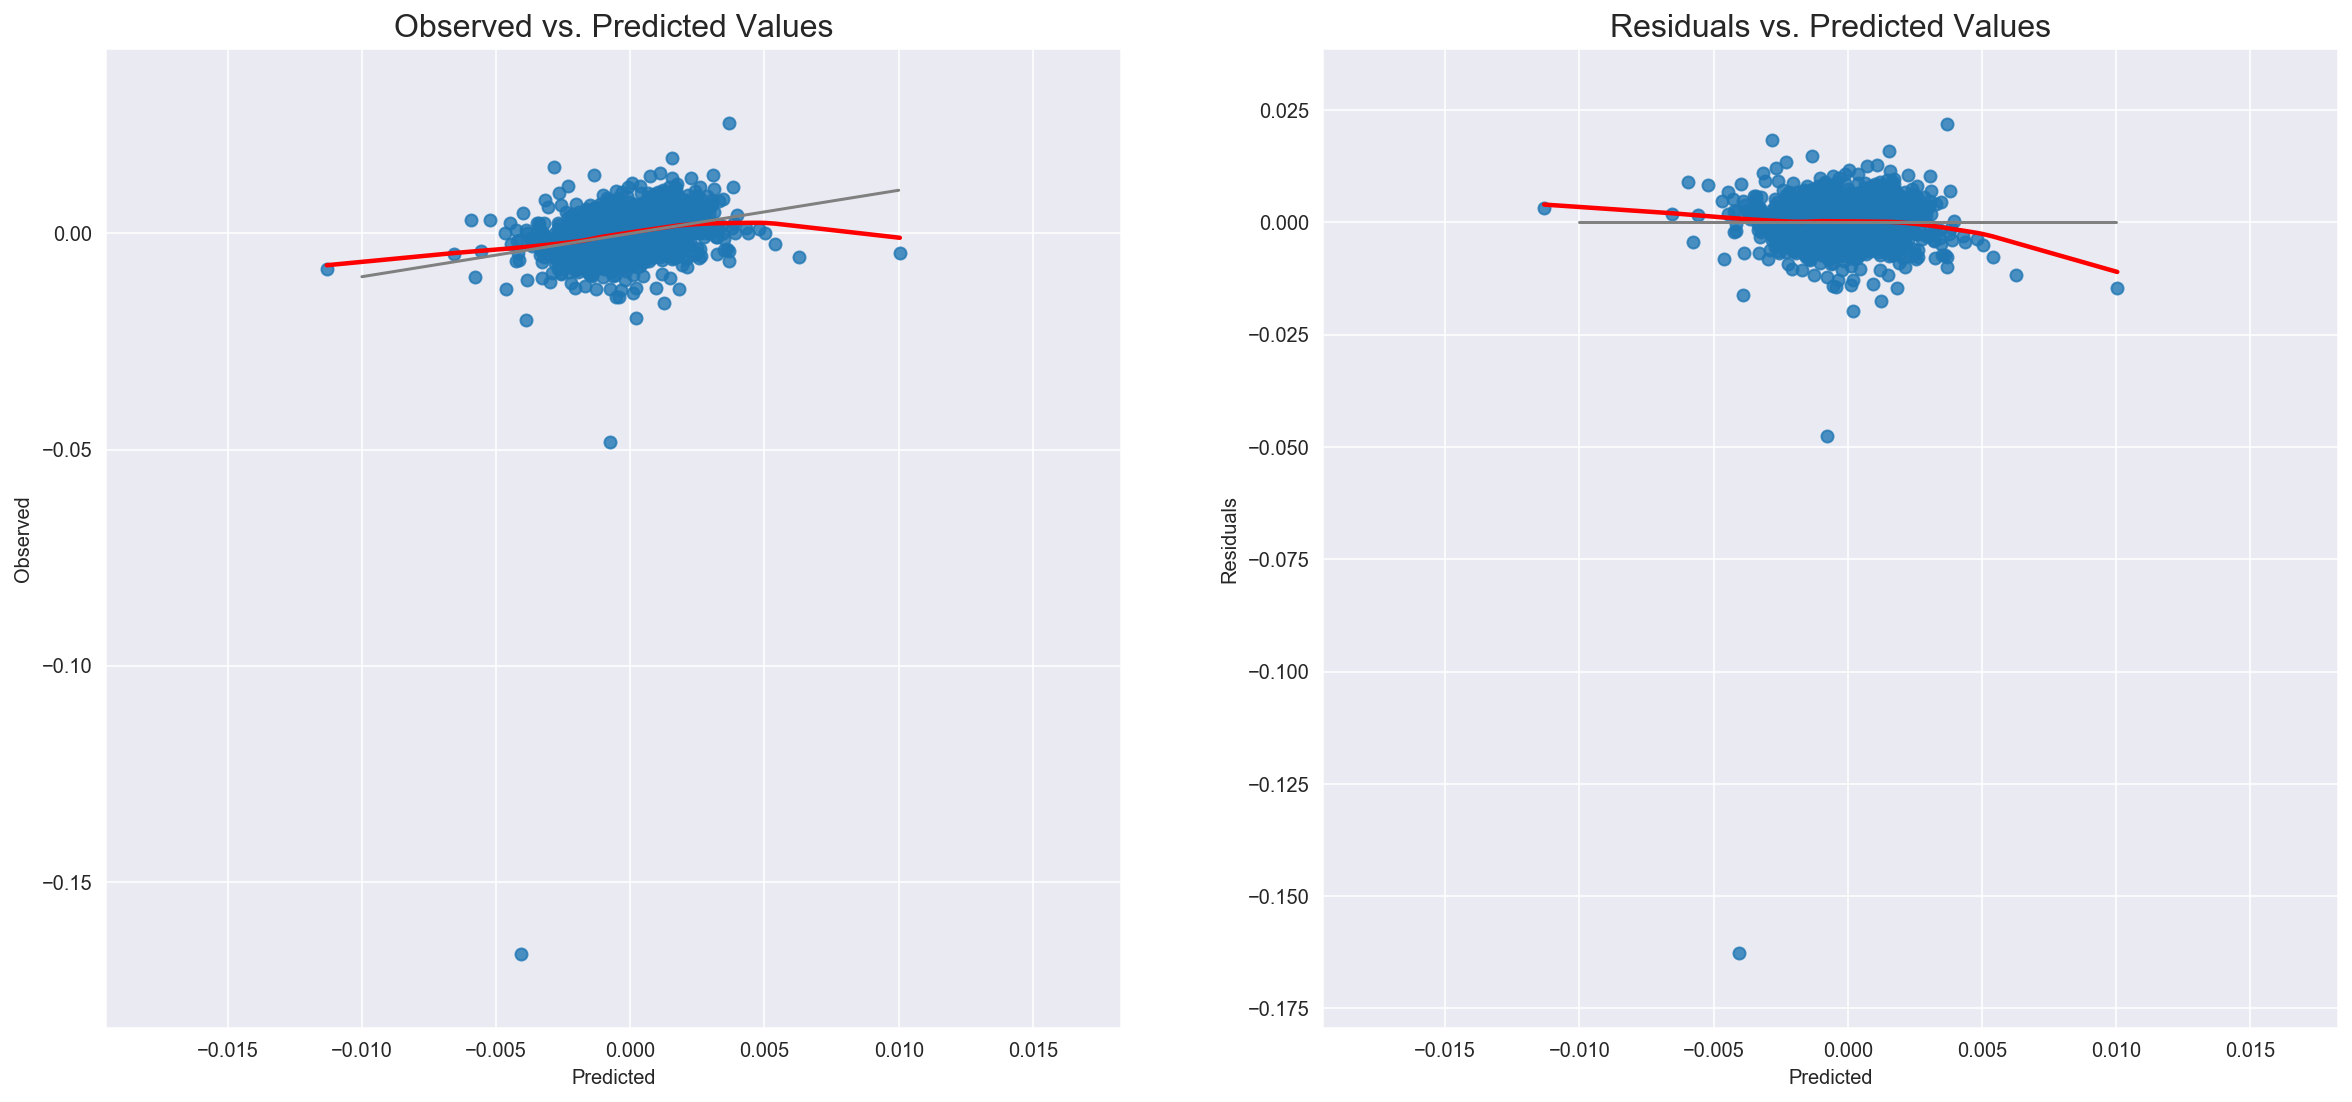

In [22]:
linearity_test(result_m, y_m) 

Linearity is not really satisfied since there is clearly a bowl pattern indicating the model is making unusual large/small predictions. If linearity exists, the left plot should be scattered around diagnal line, and the right plot should be scattered around a horizontal line.

### IV.B) Strict exogeneity
The distribution of error terms has zero mean and doesn’t depend on the independent variables X. 
i.e. there must be no relationship between the X and the error term.

In [23]:
print(f"mean of residuals = {resid_m.mean()}")

mean of residuals = -2.0738910796235802e-19


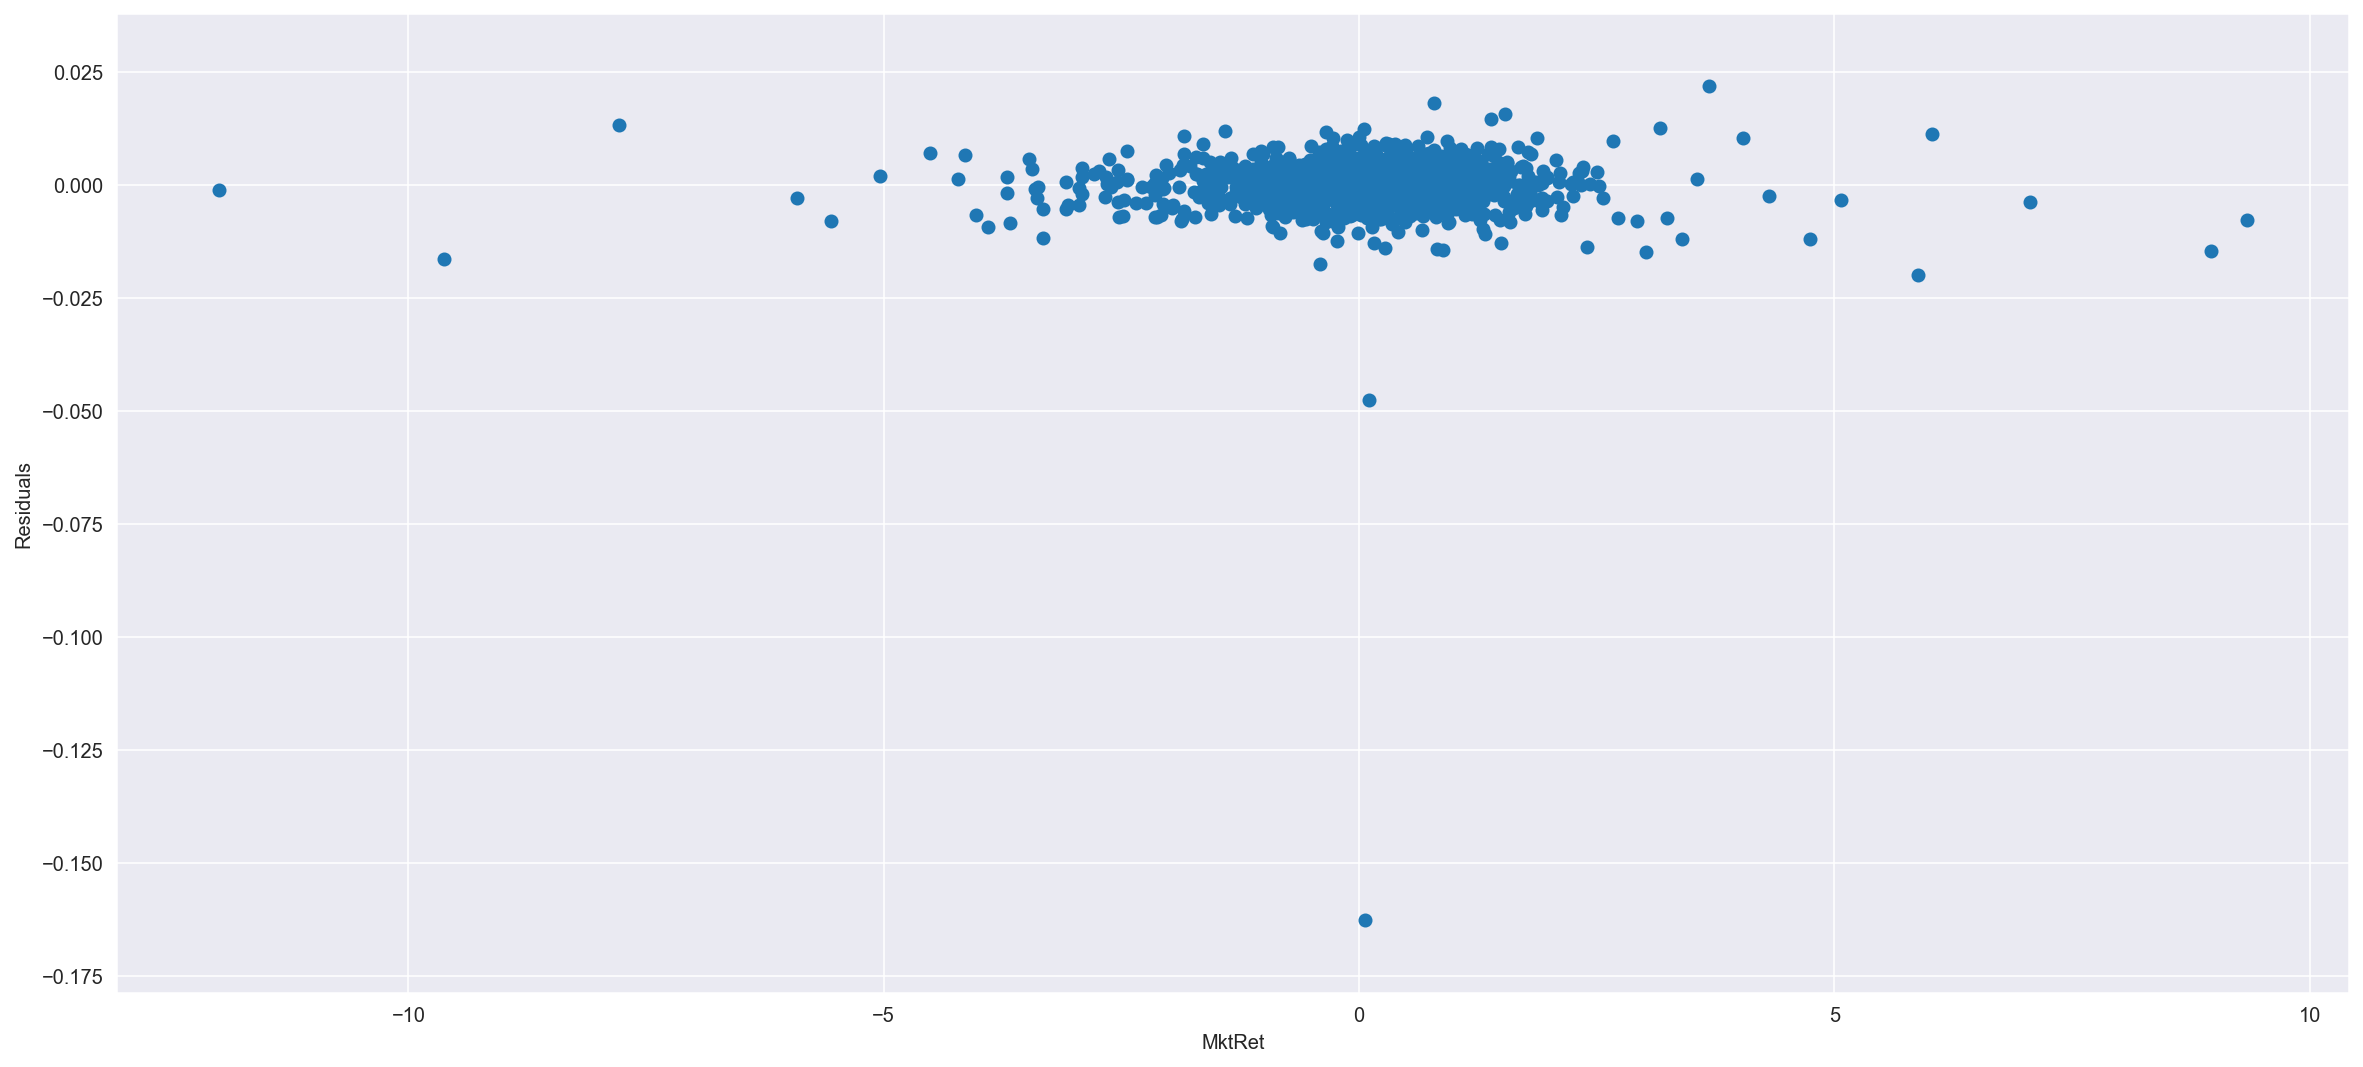

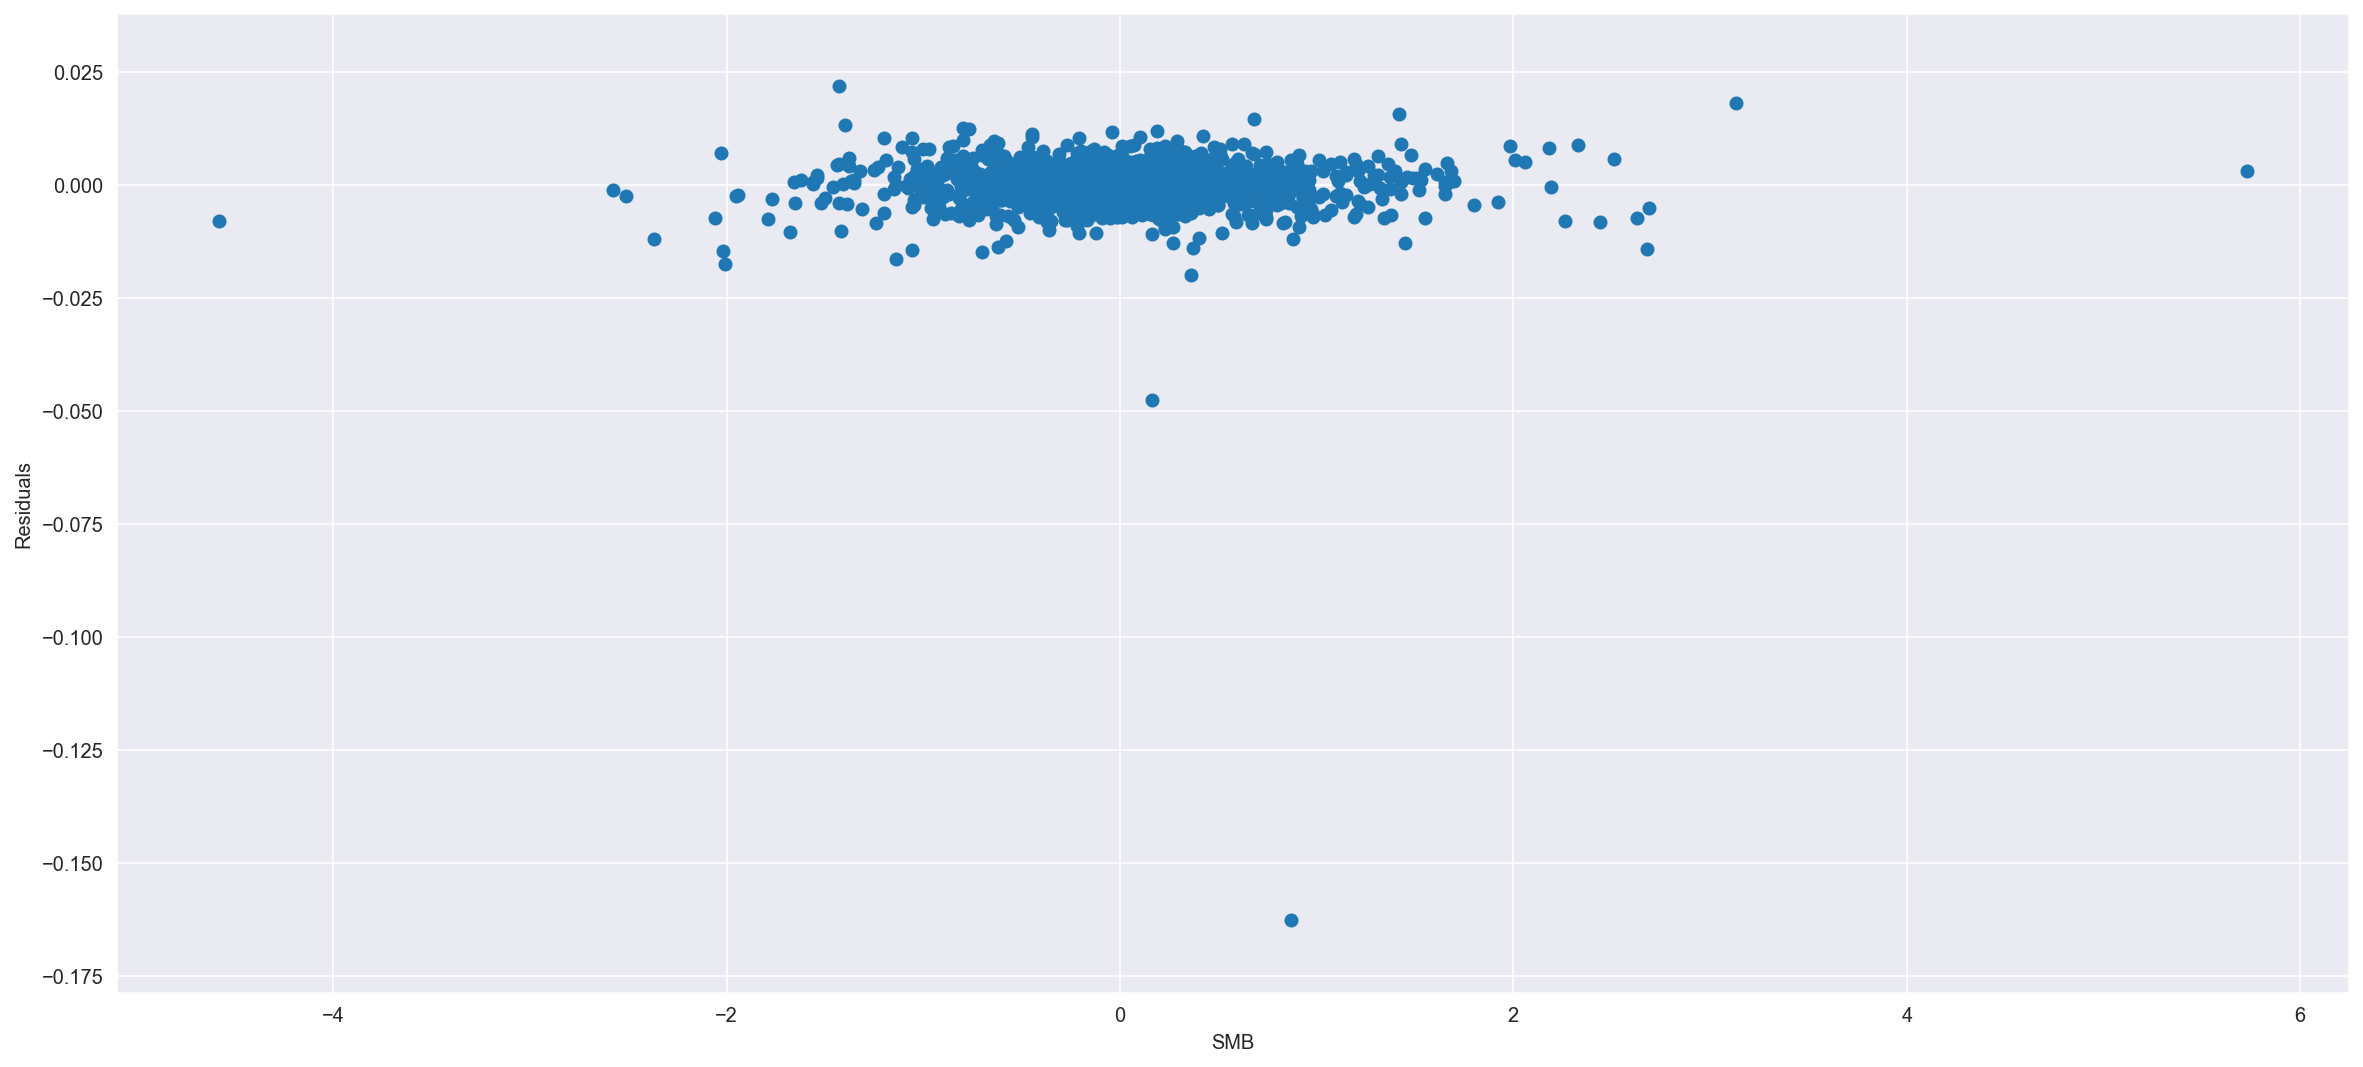

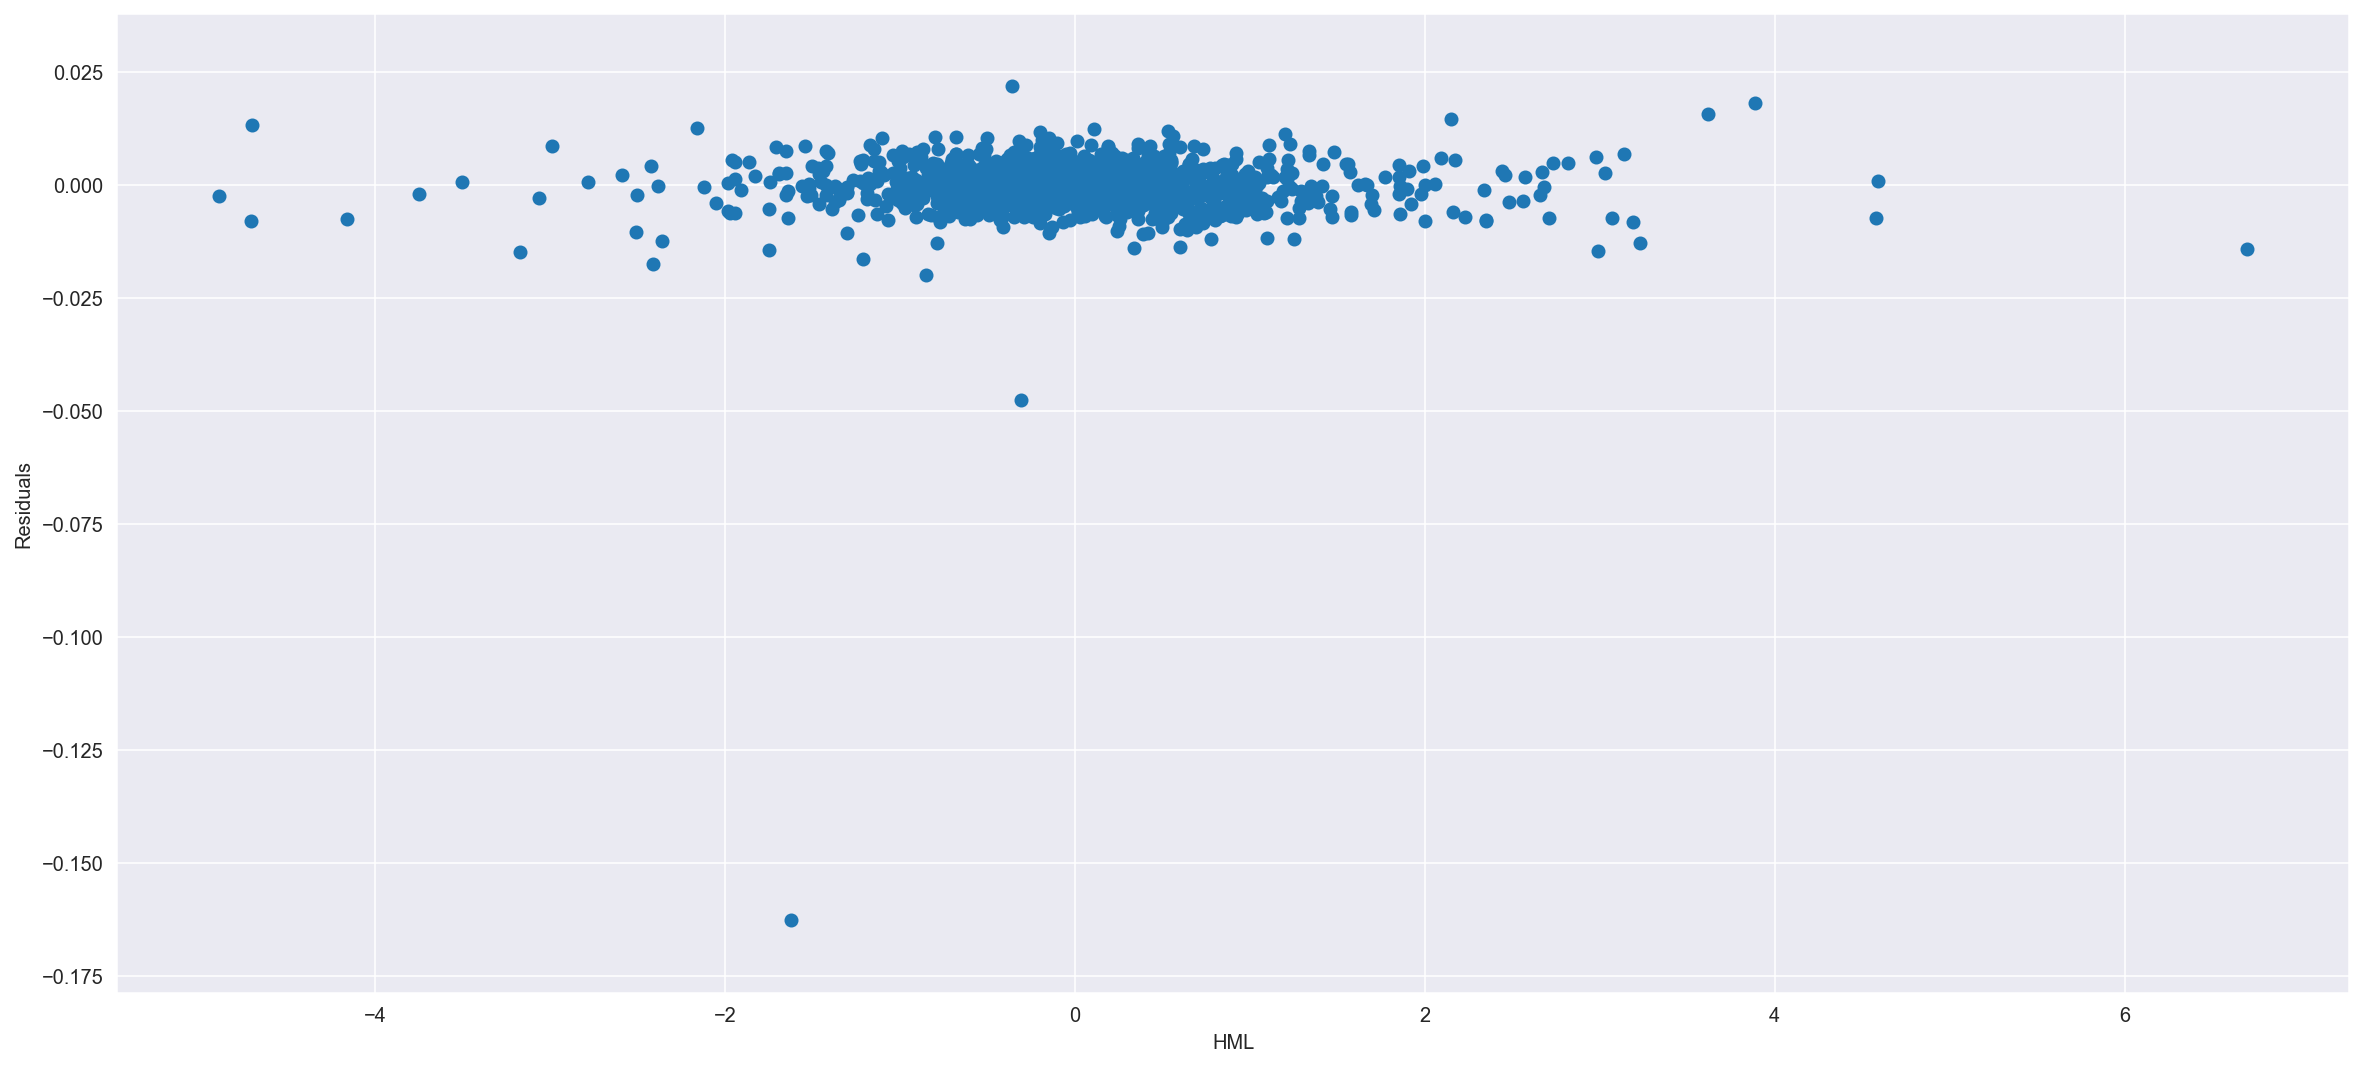

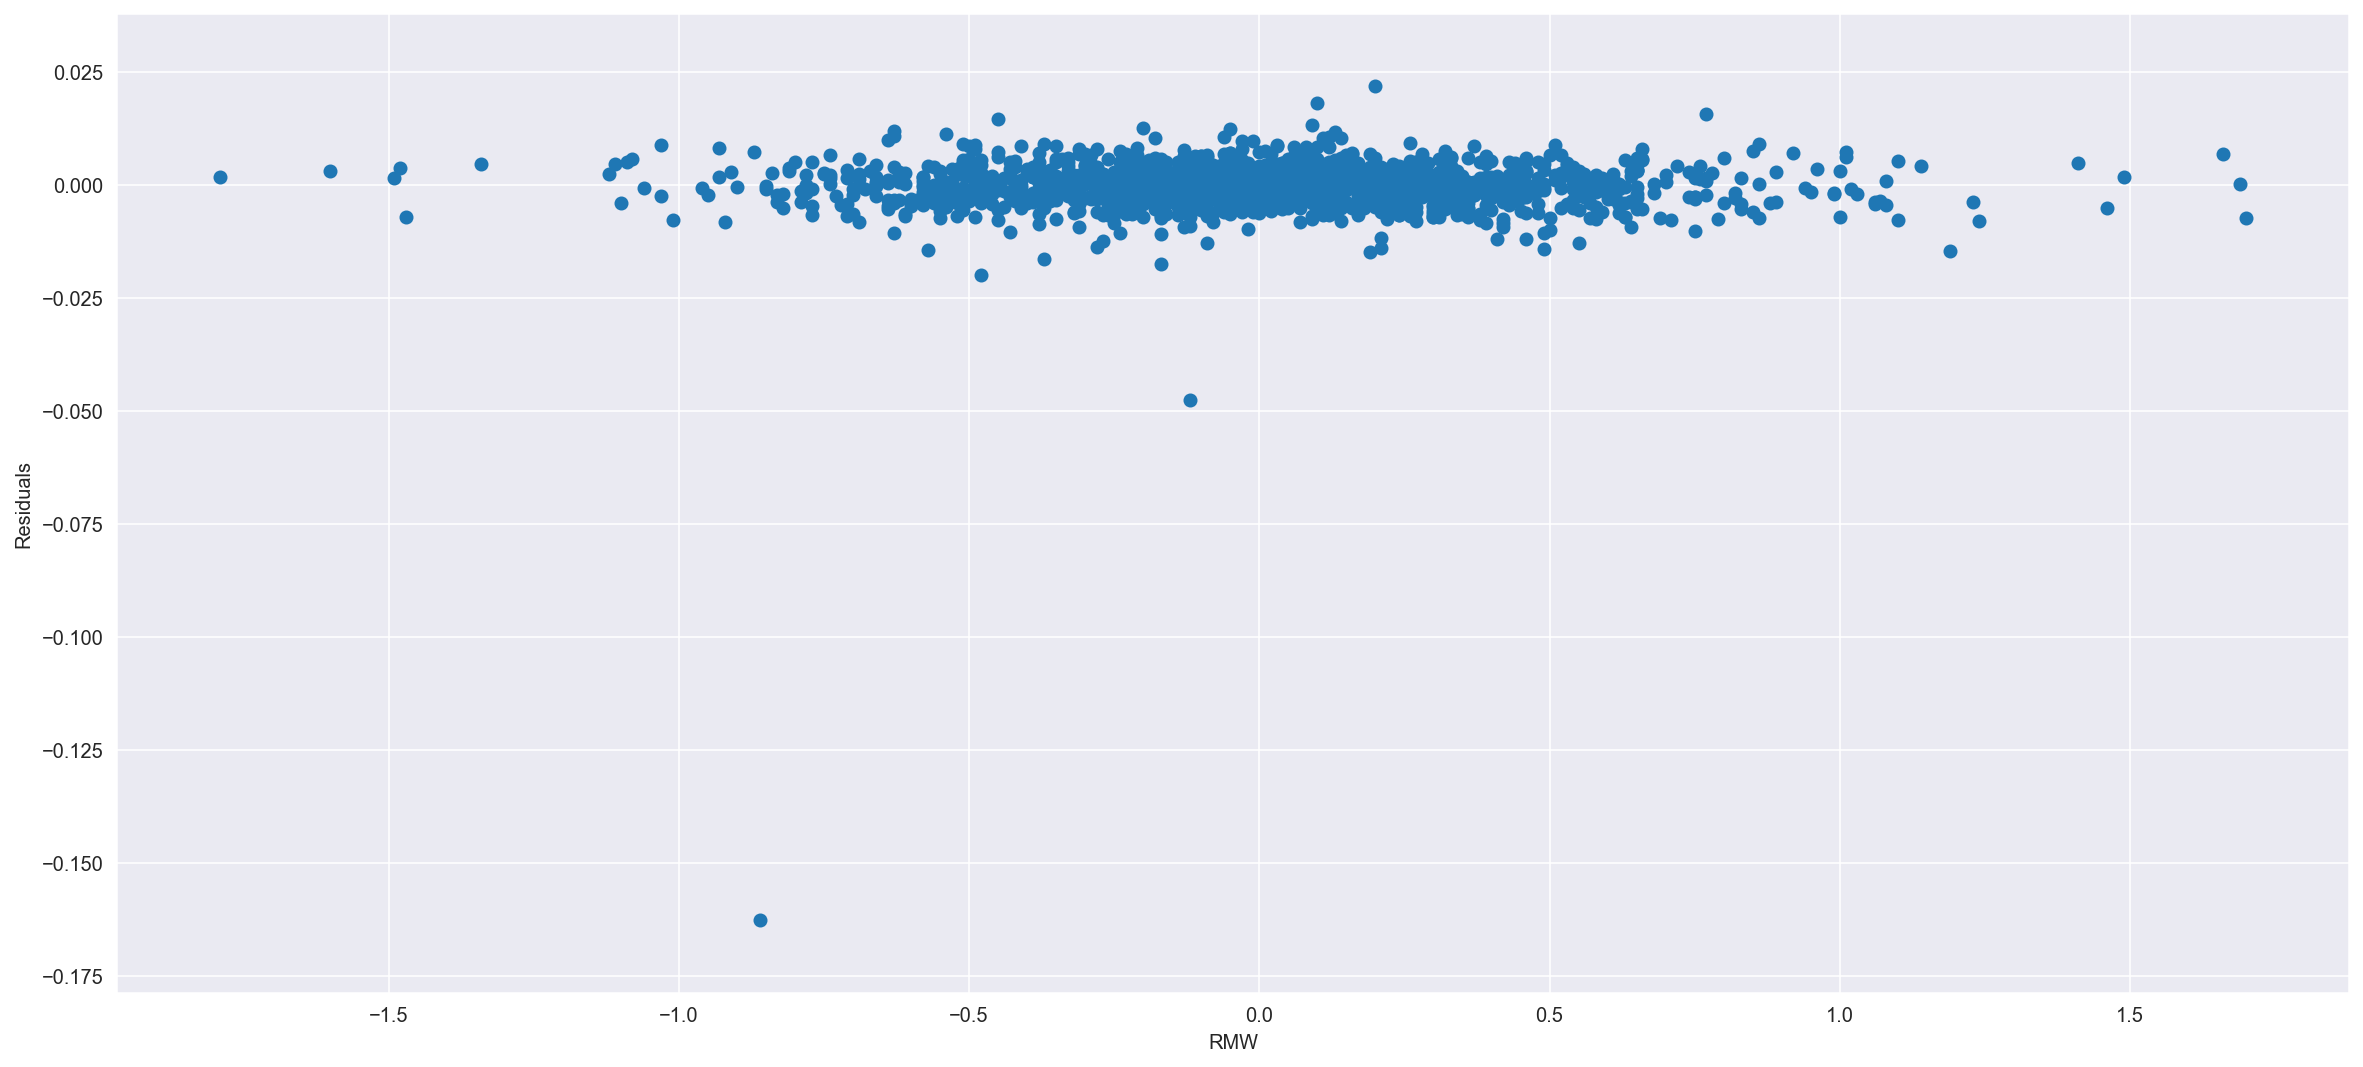

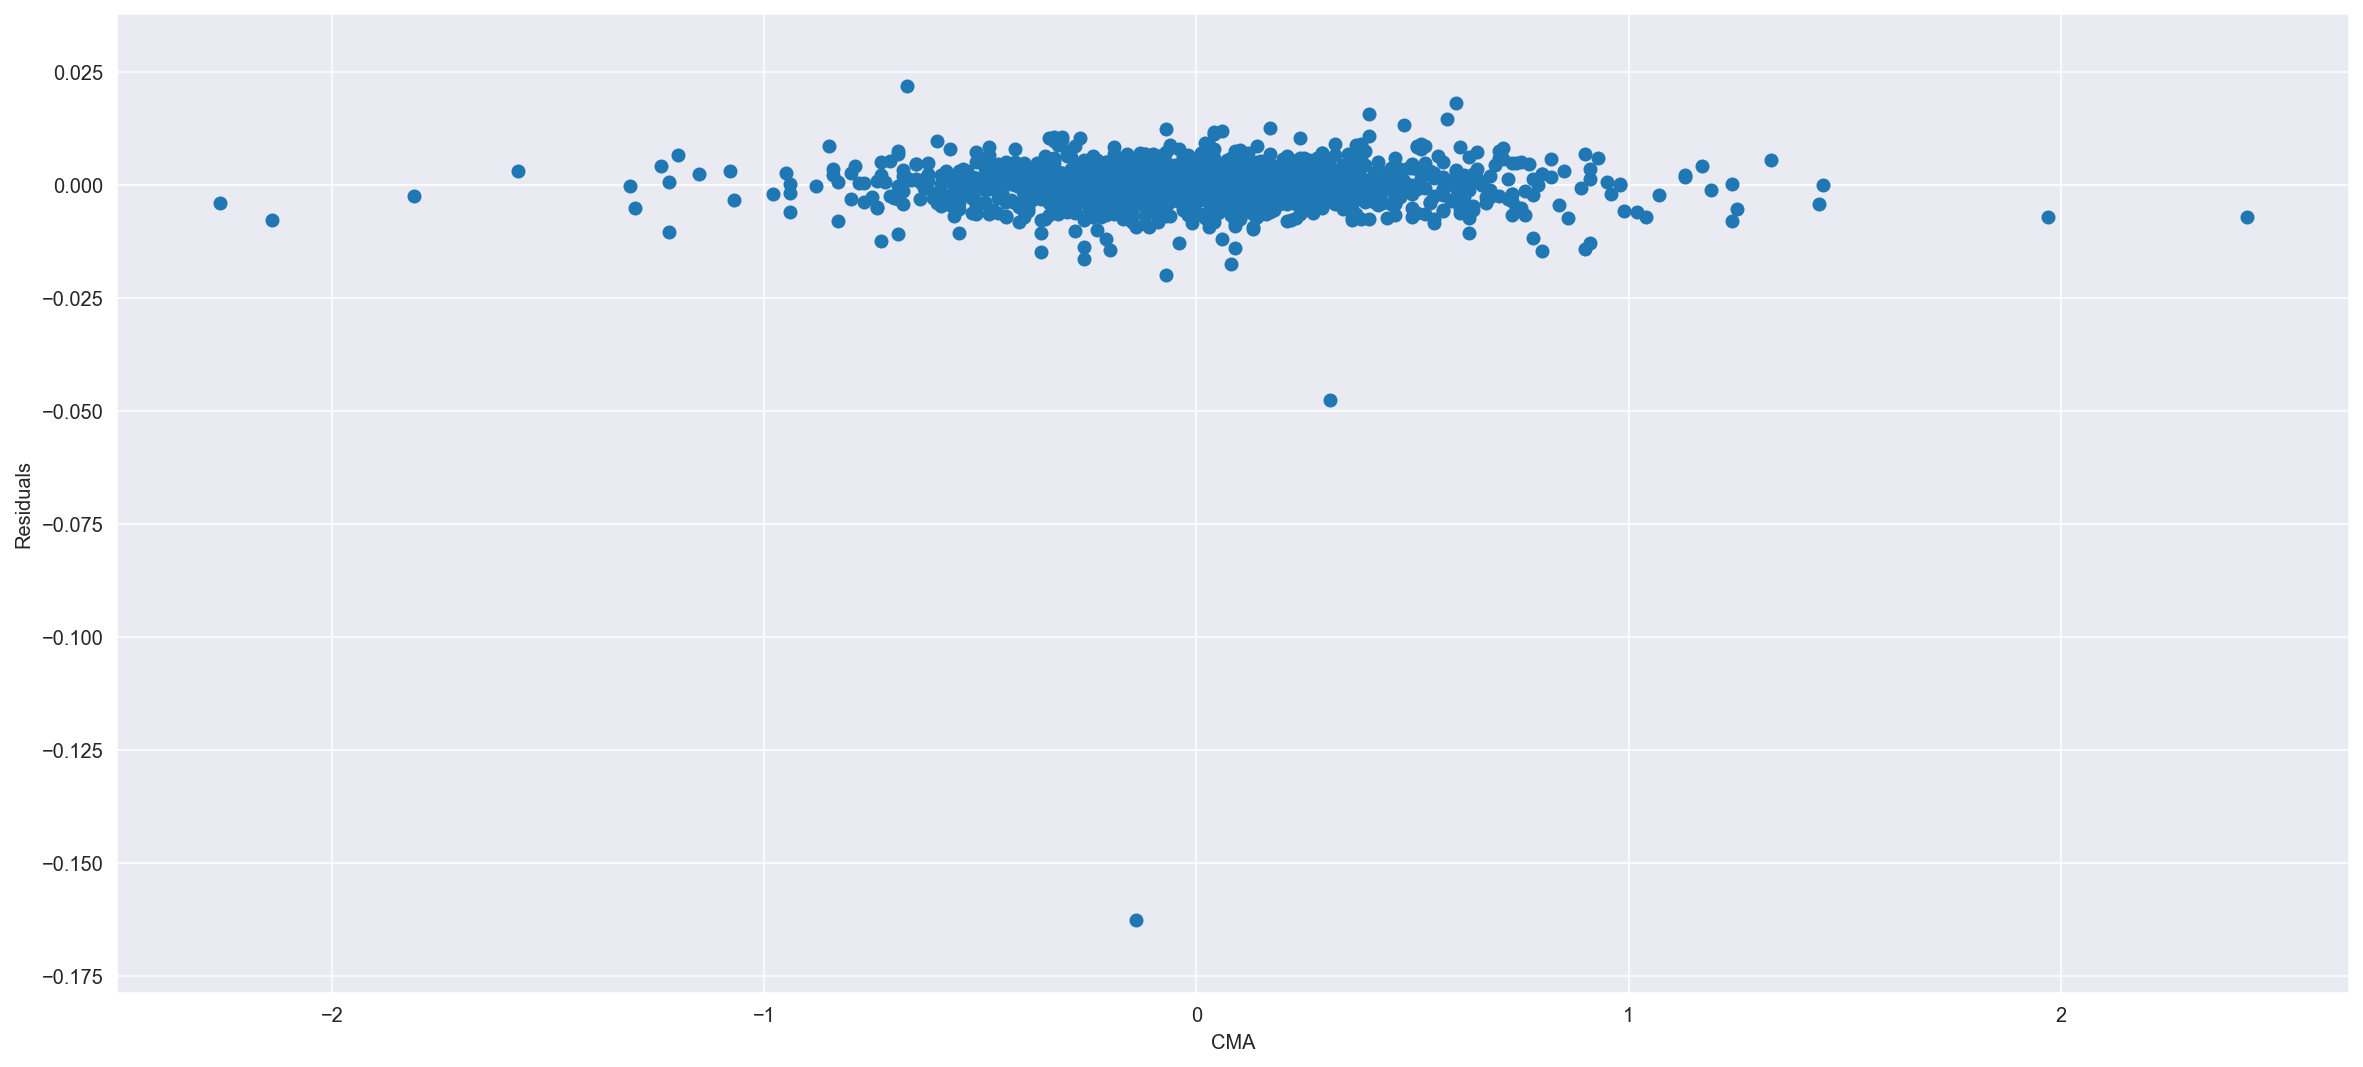

,residuals
MktRet,5.540996e-17
SMB,-5.766642e-17
HML,-8.993351e-17
RMW,1.693003e-16
CMA,6.605264e-17
residuals,1.000000e+00


In [24]:
attributes = FF5_m_2.columns
for att in attributes:
    plt.scatter(y = resid_m, x = FF5_m_2[att])
    plt.xlabel(att)
    plt.ylabel('Residuals')
    plt.show()
df = FF5_m_2.copy(deep=True)
df['residuals'] = resid_m
df.corr()[['residuals']]

In [25]:
from scipy.stats.stats import pearsonr
# Pearson correlation coefficient
def pearson_corr_test(X_with_cons, model_resid):
    print('Performing Pearson Correlation Test ...')
    for column in X_with_cons.columns[1:]:
        corr_test = pearsonr(X_with_cons[column], model_resid)
        print(f'{column} \n correlation: {corr_test[0]} \n p-value: {corr_test[1]}')
        if corr_test[1] < 0.05:
            print(" Rej null, conclude correlated.\n")
        else:
            print(' Fail to rej null, conclude non-correlated\n')

In [26]:
pearson_corr_test(X_m, resid_m)

Performing Pearson Correlation Test ...
MktRet 
 correlation: 8.168140055442918e-17 
 p-value: 1.0000000000007492
 Fail to rej null, conclude non-correlated

SMB 
 correlation: -2.833601944615455e-17 
 p-value: 1.0000000000007598
 Fail to rej null, conclude non-correlated

HML 
 correlation: -4.609831804775589e-18 
 p-value: 1.0000000000007598
 Fail to rej null, conclude non-correlated

RMW 
 correlation: 1.9622641582706945e-16 
 p-value: 1.0000000000008598
 Fail to rej null, conclude non-correlated

CMA 
 correlation: -3.5533652968590037e-17 
 p-value: 1.0000000000007598
 Fail to rej null, conclude non-correlated



For both graphical and test approaches, we see that Strict exogeneity is satisfied. Residual mean is about zero, and the correlation between residuals and regressors are really small to zero. 

### IV.C) No Multicollinearity
There should be no linear relationship between the independent variables. 

- Looking at bivariate correlation. corr > 0.8 is an indicator of multicollinearity

Notes:

Here are more potential indicators of multicollinearity:

1. Very high standard errors for regression coefficients
When standard errors are orders of magnitude higher than their coefficients, that’s an indicator.

2. The overall model is significant, but none of the coefficients are
Remember that a p-value for a coefficient tests whether the unique effect of that predictor on Y
is zero. If all predictors overlap in what they measure, there is little unique effect, even if 
the predictors as a group have an effect on Y.

3. Large changes in coefficients when adding predictors
If the predictors are completely independent of each other, their coefficients won’t change at 
all when you add or remove one. But the more they overlap, the more drastically their 
coefficients will change.

4. Coefficients have signs opposite what you’d expect from theory
Be careful here as you don’t want to disregard an unexpected finding as problematic. Not all 
effects opposite theory indicate a problem with the model. That said, it could be 
multicollinearity and warrants taking a second look at other indicators.

5. Coefficients on different samples are wildly different
If you have a large enough sample, split the sample in half and run the model separately on 
each half. Wildly different coefficients in the two models could be a sign of multicollinearity.

6. High Variance Inflation Factor (VIF) and Low Tolerance
These two useful statistics are reciprocals of each other. So either a high VIF or a low 
tolerance is indicative of multicollinearity. VIF is a direct measure of how much the variance 
of the coefficient (ie. its standard error) is being inflated due to multicollinearity. the square root of a given variable’s VIF shows how much larger the standard error is, compared with what it would be if that predictor were uncorrelated with the other features in the model. If no features are correlated, then all values for VIF will be 1. To deal with multicollinearity we should iteratively remove features with high values of VIF. A rule of thumb for removal could be VIF larger than 10 (5 is also common). Another possible solution is to use PCA to reduce features to a smaller set of uncorrelated components.

7. High Condition Indices
Condition indices are a bit strange.  The basic idea is to run a Principal Components Analysis 
on all predictors. If they have a lot of shared information, the first Principal Component 
will be much higher than the last. Their ratio, the Condition Index, will be high if 
multicollinearity is present.

In [27]:
# bivariate correlation
FF5_m_2.corr()

,MktRet,SMB,HML,RMW,CMA
MktRet,1.000000,0.161263,0.120142,-0.050357,-0.192268
SMB,0.161263,1.000000,0.354128,-0.121167,0.074147
HML,0.120142,0.354128,1.000000,0.234338,0.515556
RMW,-0.050357,-0.121167,0.234338,1.000000,0.224786
CMA,-0.192268,0.074147,0.515556,0.224786,1.000000


In [28]:
# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
def VIF_test(X_constant_added):
    vif = [variance_inflation_factor(X_constant_added.values, i) for i in range(X_constant_added.shape[1])]
    VIF_df = pd.DataFrame({'vif': vif}, index=X_constant_added.columns).T
    VIF_df = VIF_df[VIF_df.columns[1:]]
    return VIF_df
VIF_test(X_m)

,MktRet,SMB,HML,RMW,CMA
vif,1.124618,1.22791,1.730358,1.125919,1.522737


No Multicollinearity is satisfied. (Indicator of strong Multicollinearity: corr > 0.8, VIF >5)

### IV.D) Spherical error variance
There is homoscedasticity and no autocorrelation.

- The error terms in the regression should all have the same variance.
    (Heteroscedastic errors: error variance is not constant, i.e. depend on Xs.)
- The error terms of different observations should not be correlated with each other, i.e.error terms should be IID (Independent and Identically Distributed).

When we have time series data, then the regression is likely to suffer from autocorrelation because data next year will most likely be dependent on data this year. Hence, error terms in different observations will surely be correlated with each other.

Check for autocorrelation by viewing the residual time series plot. If autocorrelation is present in the model, we can try taking lags of independent variables to correct for the trend component. If you do not correct for autocorrelation, then OLS estimates won’t be BLUE, and they won’t be reliable enough.

We can also use two statistical tests: **Breusch-Pagan** and **Goldfeld-Quandt**. In both of them, the null hypothesis **H0** assumes homoscedasticity:

p-value <0.05 : reject the null, conclude heteroscedasticity.

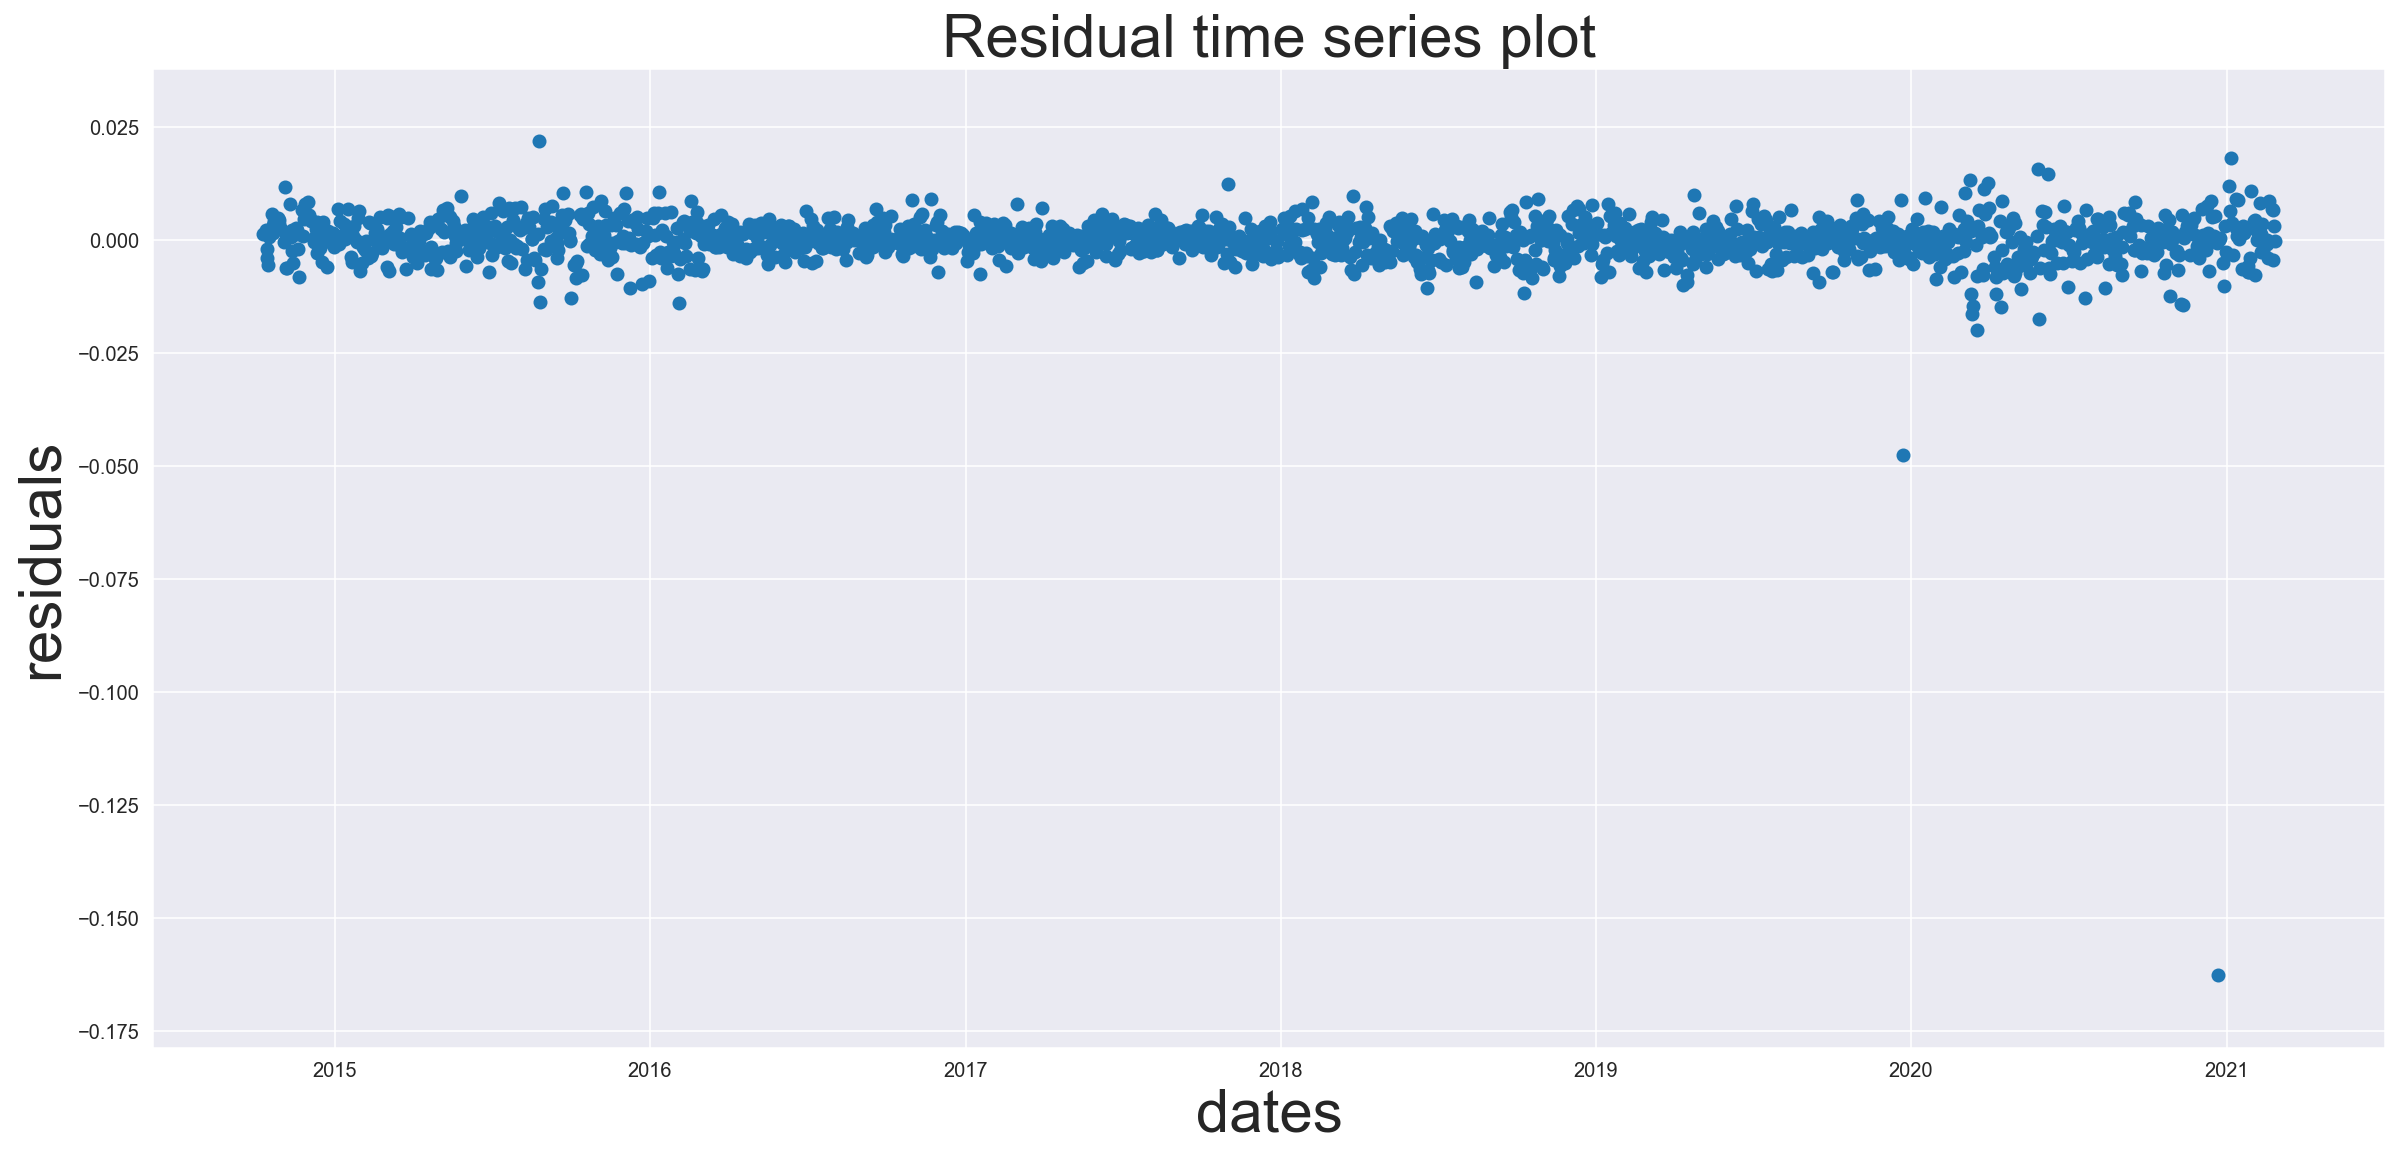

In [29]:
# to see constant variance of error terms
plt.scatter(y = resid_m, x = FF5_m_2.index)
plt.title('Residual time series plot', fontsize = 30)
plt.ylabel('residuals', fontsize = 30)
plt.xlabel('dates', fontsize = 30)
plt.show()

In [30]:
def homoscedasticity_test(model):
    ''' Testing the homoscedasticity of residuals in a linear regression model.
    It plots residuals and standardized residuals vs. fitted values and runs Breusch-Pagan and Goldfeld-Quandt tests.
    
    Args
    ----------
    model: fitted OLS model from statsmodels
    '''
    fitted_vals = model.predict()
    resids = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal

    fig, ax = plt.subplots(1,2)

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Standardized Residuals vd Fitted', fontsize=16)
    ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')

    bp_test = pd.DataFrame(sms.het_breuschpagan(resids, model.model.exog), 
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

    gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, model.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])
    def conclude(score):
        if score < 0.05:
            print('Reject Null, conclude heteroscedasticity')
        else:
            print('Fail to Reject Null, conclude homoscedasticity')
            
    print('\n---- Breusch-Pagan test ----')
    print(bp_test)
    conclude(bp_test.loc['p-value'].values)
    print('\n---- Goldfeld-Quandt test ----')
    print(gq_test)
    conclude(gq_test.loc['p-value'].values)
    print('\n---- Residuals plots ----')


---- Breusch-Pagan test ----
                                   value
Lagrange multiplier statistic  11.324054
p-value                         0.045320
f-value                         2.272372
f p-value                       0.045175
Reject Null, conclude heteroscedasticity

---- Goldfeld-Quandt test ----
                    value
F statistic  4.480931e+00
p-value      9.346596e-92
Reject Null, conclude heteroscedasticity

---- Residuals plots ----


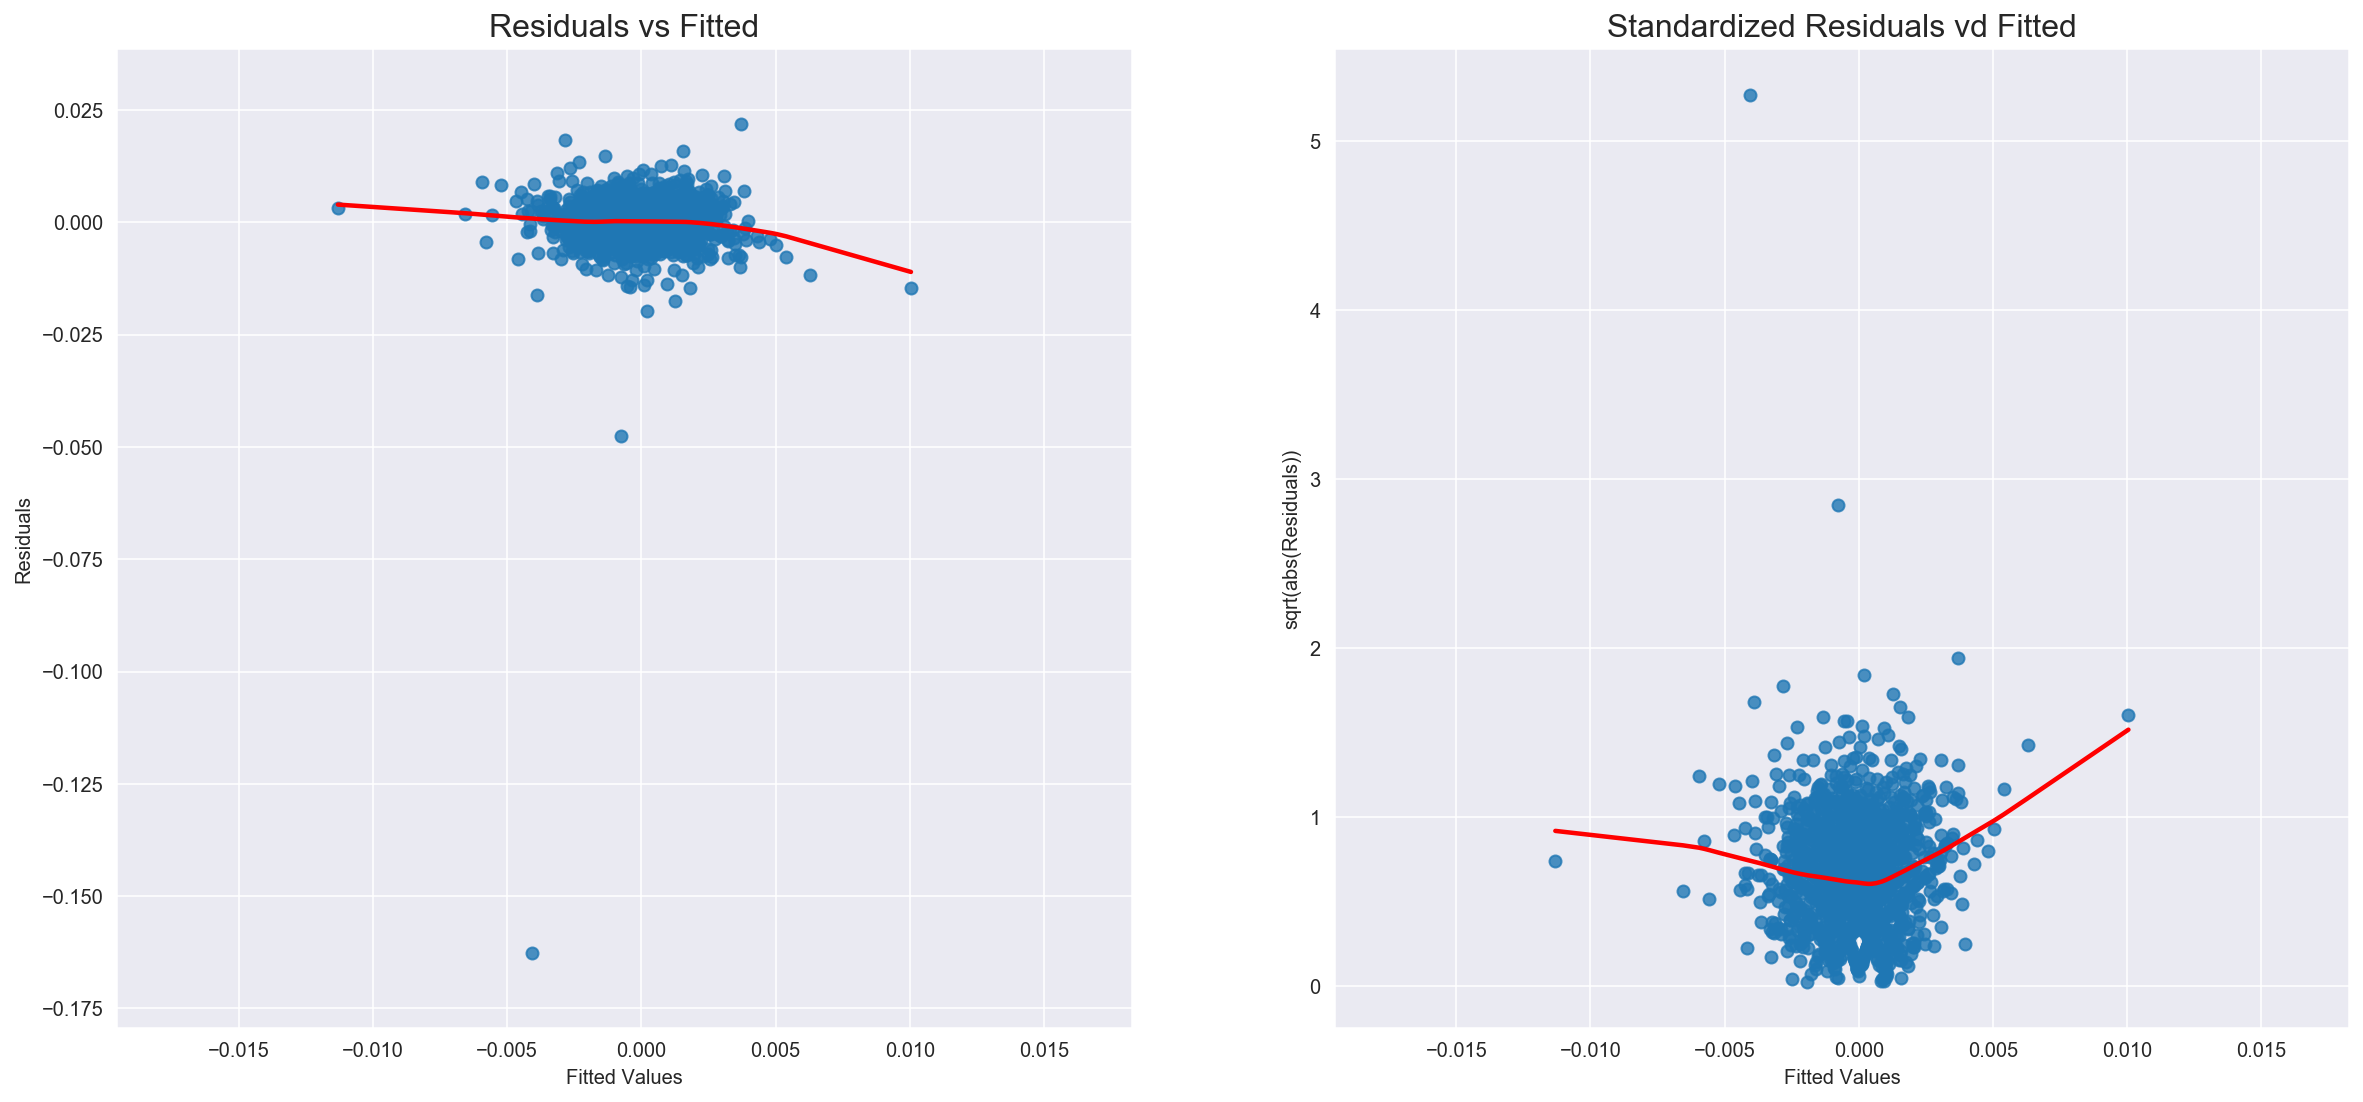

In [31]:
homoscedasticity_test(result_m)

In [32]:
# check autocorrelation of error terms
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import durbin_watson
def autocorrelation_test(rds):
    durbinWatson = durbin_watson(rds)
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied')
    else:
        print('Little to no autocorrelation', '\n')
        print('Assumption satisfied')
    plot_acf(rds, lags = 15)
    plt.show()

Durbin-Watson: 1.9623593087965796
Little to no autocorrelation 

Assumption satisfied


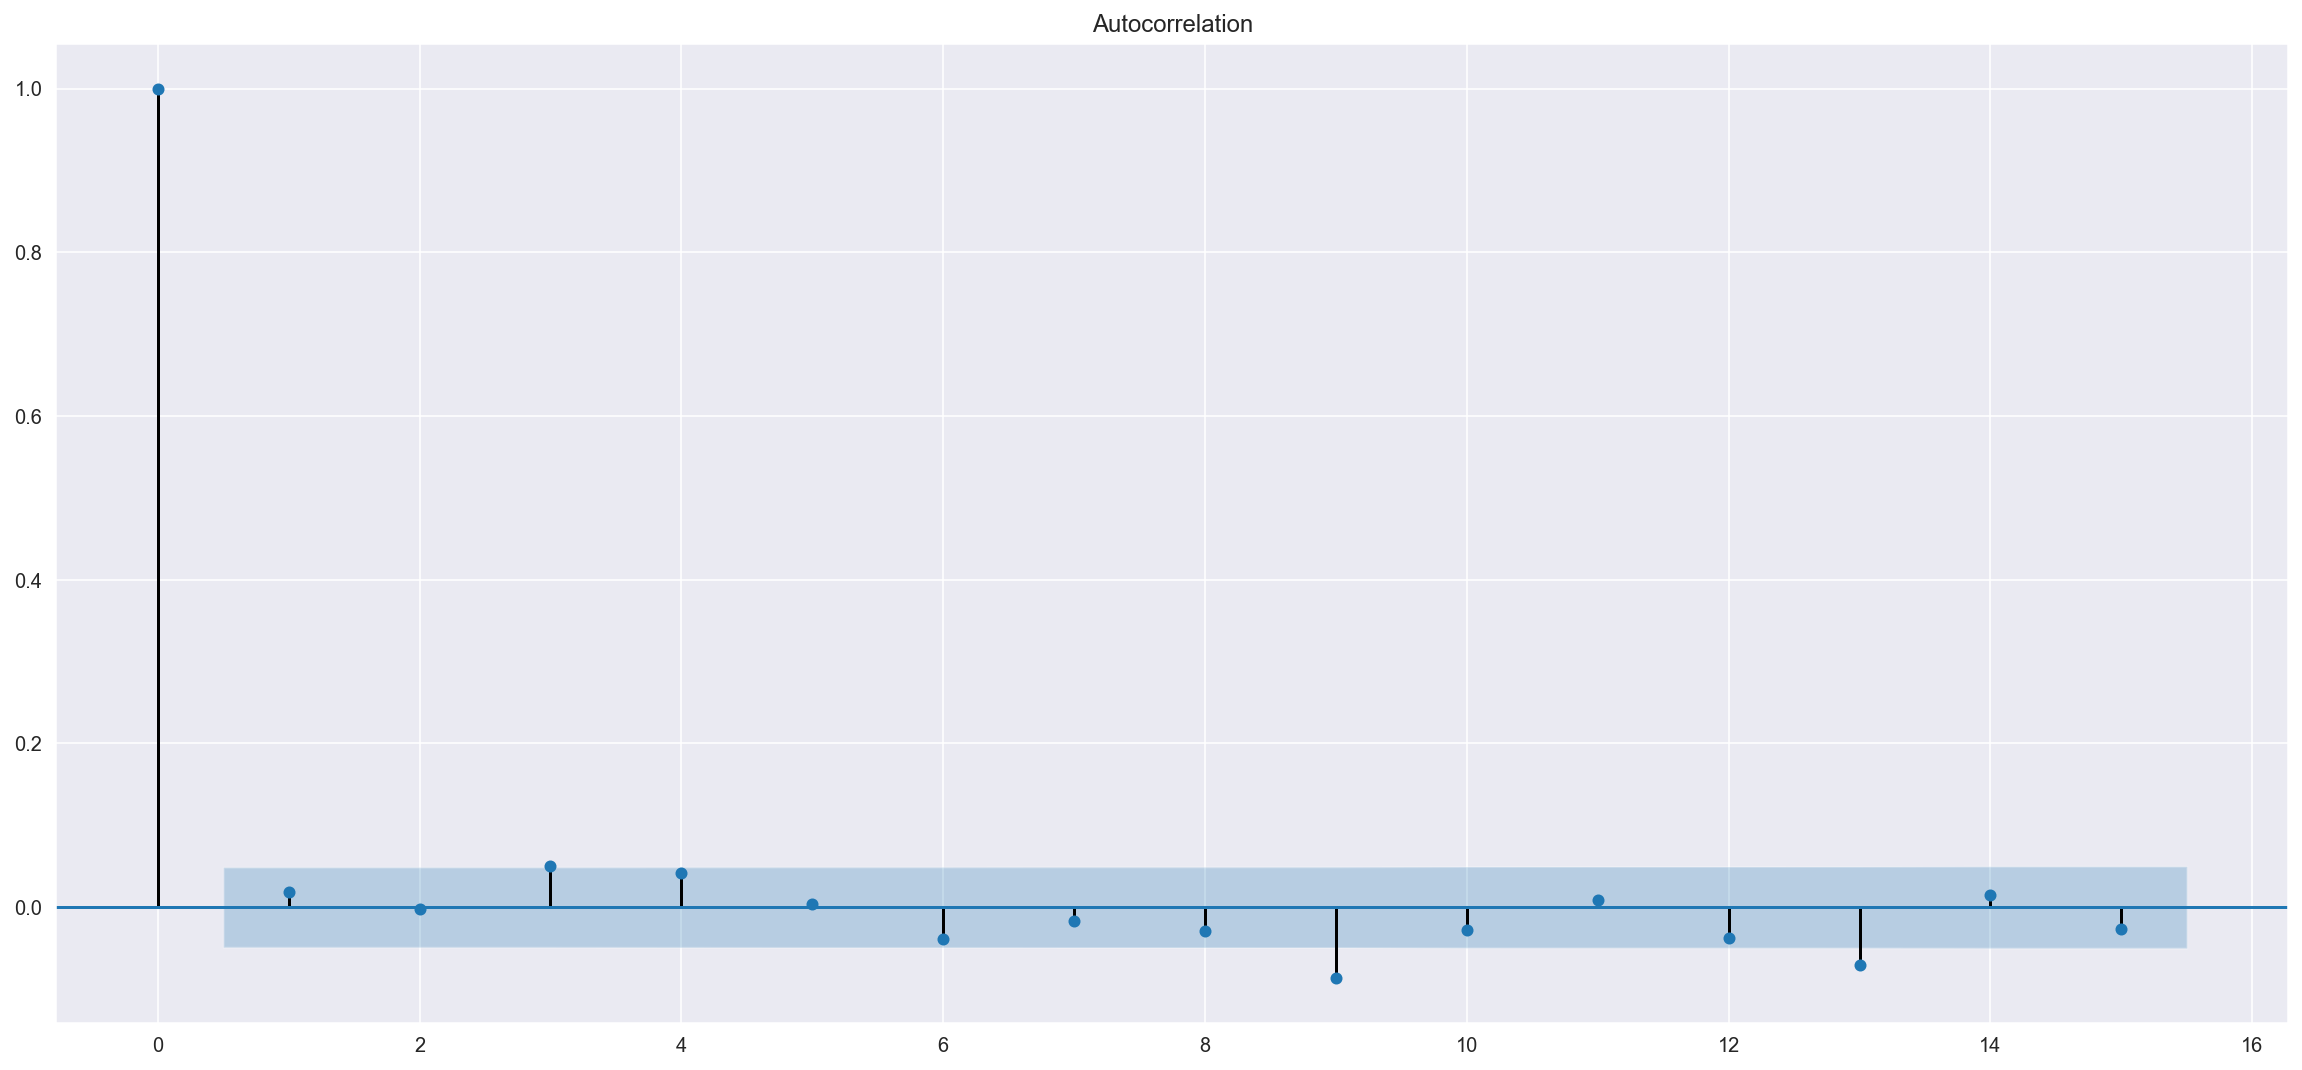

In [33]:
autocorrelation_test(resid_m)

Spherical error variance is not satisfied since we see a non-constant residual variance over time. There is no strong evidence of autocorrelation of residuals though.

### IV.E) Normality:

In [34]:
print(f'residual mean: {resid_m.mean()}')
print(f'residual std: {resid_m.std()}')
s = pd.DataFrame(np.random.normal(resid_m.mean(), resid_m.std(), len(resid_m)))
print(f'skewness: \n   residual: {resid_m.skew()} \n   normal: {s[0].skew()}')
print(f'kurtosis: \n   residual: {resid_m.kurtosis()} \n   normal: {s[0].kurtosis()}')

residual mean: -2.0738910796235802e-19
residual std: 0.005854370954103162
skewness: 
   residual: -13.71075168580616 
   normal: -0.005722534360169561
kurtosis: 
   residual: 373.2293608076401 
   normal: -0.11704835867664576


In [35]:
from statsmodels.stats.diagnostic import normal_ad
def normality_test(series):
    pva = normal_ad(series)[1]
    if pva<0.05:
        print('Non-normal')
    else:
        print('Normal')
    series.hist()
    series.plot(kind='kde')
    plt.show()

Non-normal


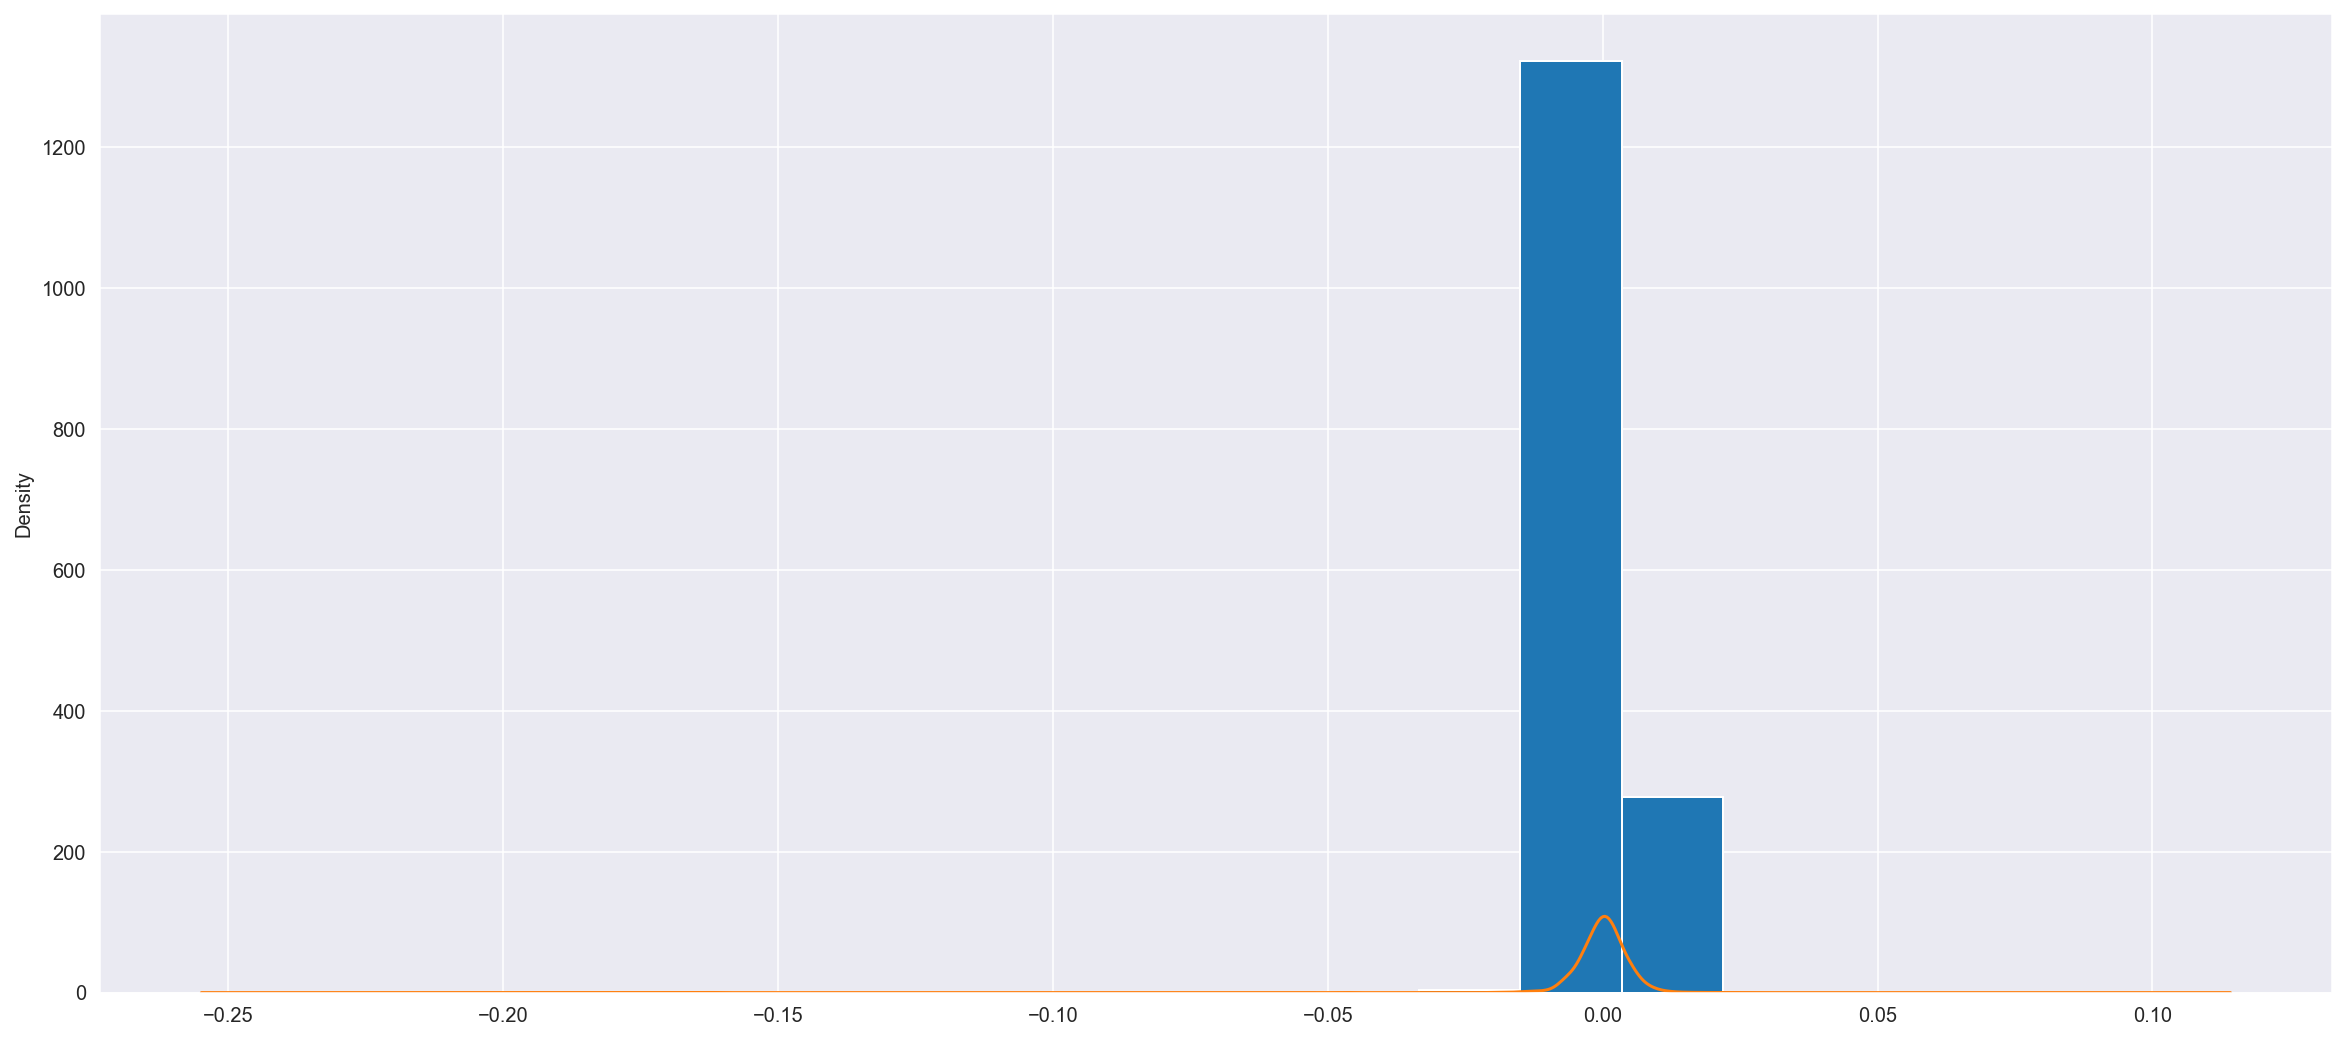

In [36]:
normality_test(resid_m)

Through the graph, we can see it is roughly Normal. However, with the same mean and std, residuals has skewness and kurotosis that are far away from those for a Normal distribution. There, we conclude that Normal assumption is not satisfied. The residual probably has fat tails.

### Financial/economic interpretation
Don't think monthly data give me a deep insight of the relationship between market and AQR. See Daily Data exploration below with more explaination:)

------------------------------
# PART TWO: 10 Industry Portfolio Model

### Datasets
**Portfolio10**:
- Daily data of the [10 Industry Portfolio model](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_10_ind_port.html)
- [Ken French data library](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)
- 1926-07-01 to 2021-02-28

**AQR**:
- same as above, daily returns

### Goal:
Repeat the analysis again, to explore the relationship between AQR returns and different industries.

### I. Data Gathering:

In [37]:
portfolio10_m = web.DataReader('10_Industry_Portfolios_daily', 'famafrench', start = '1926-07-01', end = '2021-02-28')[0]
portfolio10_m

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,
1926-07-01,0.02,-0.28,-0.23,0.57,-0.21,-0.02,-0.01,0.97,0.61,0.21
1926-07-02,0.29,1.07,0.81,0.64,0.36,0.26,0.01,0.13,0.47,0.11
1926-07-06,0.24,0.72,0.22,0.17,0.47,0.17,-0.23,0.23,0.73,-0.19
1926-07-07,0.27,0.06,0.23,-0.04,-0.10,0.32,-0.58,0.33,0.17,0.15
1926-07-08,0.69,0.05,0.15,0.12,0.35,0.40,-0.36,0.91,-0.20,0.39
...,...,...,...,...,...,...,...,...,...,...
2021-02-22,0.15,-5.65,-0.37,3.41,-2.53,1.05,-1.20,-0.84,-1.58,0.81
2021-02-23,0.09,-1.92,0.21,1.56,-0.37,0.96,-0.59,-0.65,0.85,0.69
2021-02-24,0.42,4.64,1.85,3.66,0.84,0.41,-0.32,0.93,-0.68,1.96


In [38]:
print(f"Portfolio daily:{portfolio10_m.shape}")
print(f"missing values: {portfolio10_m.isnull().any().sum()}")
b4, e4 = portfolio10_m.index[0], portfolio10_m.index[-1]
print(f"Starting from {str(b4)[:10]} to {str(e4)[:10]}")

Portfolio daily:(24934, 10)
missing values: 0
Starting from 1926-07-01 to 2021-02-26


In [39]:
start3 = max(b4, b3)
end3 = min(e4, e3)
print('For scatter plots, we need consistent start/end dates for two datasets:')
print('start_date: ', str(start3)[:7])
print('end_date: ', str(end3)[:7])
portfolio10_m_3 = portfolio10_m.loc[start3:end3]
AQR_m_3 = AQR_m.loc[start3:end3]

portfolio_all_m = pd.merge(AQR_m_3, portfolio10_m_3, left_index=True, right_index=True)
print(portfolio_all_m.shape)
portfolio_all_m

For scatter plots, we need consistent start/end dates for two datasets:
start_date:  2014-10
end_date:  2021-02
(1606, 11)


,Return,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,,
2014-10-10,0.003017,-0.02,-2.02,-1.13,-1.40,-2.89,-1.02,-0.32,-0.89,0.30,-1.20
2014-10-13,-0.001005,-1.16,-1.94,-1.87,-3.18,-1.37,-1.66,-1.75,-2.19,-0.79,-1.10
2014-10-14,-0.005038,-0.06,1.63,0.79,-1.29,0.43,0.25,0.68,-0.63,0.67,0.59
2014-10-15,-0.006079,-0.79,-0.35,0.14,0.57,-0.37,-0.50,-1.03,-0.35,-0.47,-1.15
2014-10-16,-0.008163,-0.41,1.49,0.79,2.09,-0.34,-0.19,-0.21,-0.23,0.54,0.41
...,...,...,...,...,...,...,...,...,...,...,...
2021-02-22,0.010712,0.15,-5.65,-0.37,3.41,-2.53,1.05,-1.20,-0.84,-1.58,0.81
2021-02-23,0.000000,0.09,-1.92,0.21,1.56,-0.37,0.96,-0.59,-0.65,0.85,0.69
2021-02-24,0.004556,0.42,4.64,1.85,3.66,0.84,0.41,-0.32,0.93,-0.68,1.96


### II. Regression:
** 10 Industry Portfolio Model**

$$ \text{AQR Return}_i = b_0 + b_1*\text{NoDur}_i + b_2*\text{Durbl}_i + b_3*\text{Manuf}_i + b_4*\text{Enrgy}_i + b_5*\text{HiTec}_i$$
$$ + b_6*\text{Telcm}_i + b_7*\text{Shops}_i + b_8*\text{Hlth}_i + b_9*\text{Utils}_i + b_{10}*\text{Other}_i + \epsilon_i $$


In [40]:
# regressors: 10 Factors
X_portfolio_m = portfolio_all_m[portfolio_all_m.columns[1:]]   
# response variable: Returns of QMNIX Daily
y_portfolio_m = portfolio_all_m[['Return']]

In [41]:
# Running OLS model:
import statsmodels.api as sm
X_portfolio_m = sm.add_constant(X_portfolio_m)
model_p_m = sm.OLS(y_portfolio_m, X_portfolio_m, missing='raise')
result_p_m = model_p_m.fit()

tstat_p_m = result_p_m.tvalues
coeff_p_m = result_p_m.params
fitted_p_m = result_p_m.fittedvalues
resid_p_m = result_p_m.resid
result_p_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     7.008
Date:                Fri, 16 Apr 2021   Prob (F-statistic):           7.72e-11
Time:                        01:12:32   Log-Likelihood:                 5960.1
No. Observations:                1606   AIC:                        -1.190e+04
Df Residuals:                    1595   BIC:                        -1.184e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.000     -1.420      0.156      -0.001    8.04e-05
NoDur          0.0010      0.000      3.150      0.002       0.000       0.002
Durbl         -0.0003      0.000     -2.255      0.024      -0.001   -3.77e-05
Manuf          0.0008      0.000      1.921      0.055   -1.59e-05       0.002
Enrgy         -0.0006      0.000     -5.271      0.000      -0.001      -0.000
HiTec         -0.0005      0.000     -1.995      0.046      -0.001   -8.65e-06
Telcm         -0.0003      0.000     -1.236      0.217      -0.001       0.000
Shops          0.0007      0.000      2.091      0.037    4.03e-05       0.001
Hlth        1.377e-05      0.000      0.060      0.952      -0.000       0.000
Utils         -0.0006      0.000     -3.057      0.002      -0.001      -0.000
Other          0.0005      0.000      1.611      0.107      -0.000       0.001
==============================================================================
Omnibus:                     3102.777   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10263618.728
Skew:                         -14.196   Prob(JB):                         0.00
Kurtosis:                     393.606   Cond. No.                         11.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Interpret:
**t-test**: in the table, for each t-test, it means given other coefs are statistically significant
- H_0: not significant. 
- H_a: the coef is significant.
- p < 0.05, reject null, conclude significance.

Therefore, given all others are significant, `NoDur`,`Durbl`,`Enrgy`,`HiTec`,`Shops`and `Utils` are statistically significant. `const`,`Manuf`,`Telcm`,`Hlth` and `Other` are not sigificant.

**F-test**: in the table, for the F-stats, it means the overall model evaluation.
- H_0: our model does not explain the variance any better than the intercept only model. we want the intercept only model.
- H_a: our model is better than the intercept only one.
- Prob (F-statistic) is just the p-value of this test. If Prob (F-statistic) < 0.05, reject null, conclude our model is good.

Therefore, p-value = 7.72e-11 < 0.05 and we reject null, and we need to conclude that our model is  outperformed the intercept only model.

**$R^2$**: the percentage of variance explained by our model factors.

0.042 means the model is not great with explaining return variance. Even worse than 5 factor model (0.063). We again are losing the predictive power.

**Intercept**: from t-test above, we conclude that, given other coefs are statistically significant, the intercept is not statistically significant.

### III. OLS Assumptions check

#### Test Linearity:

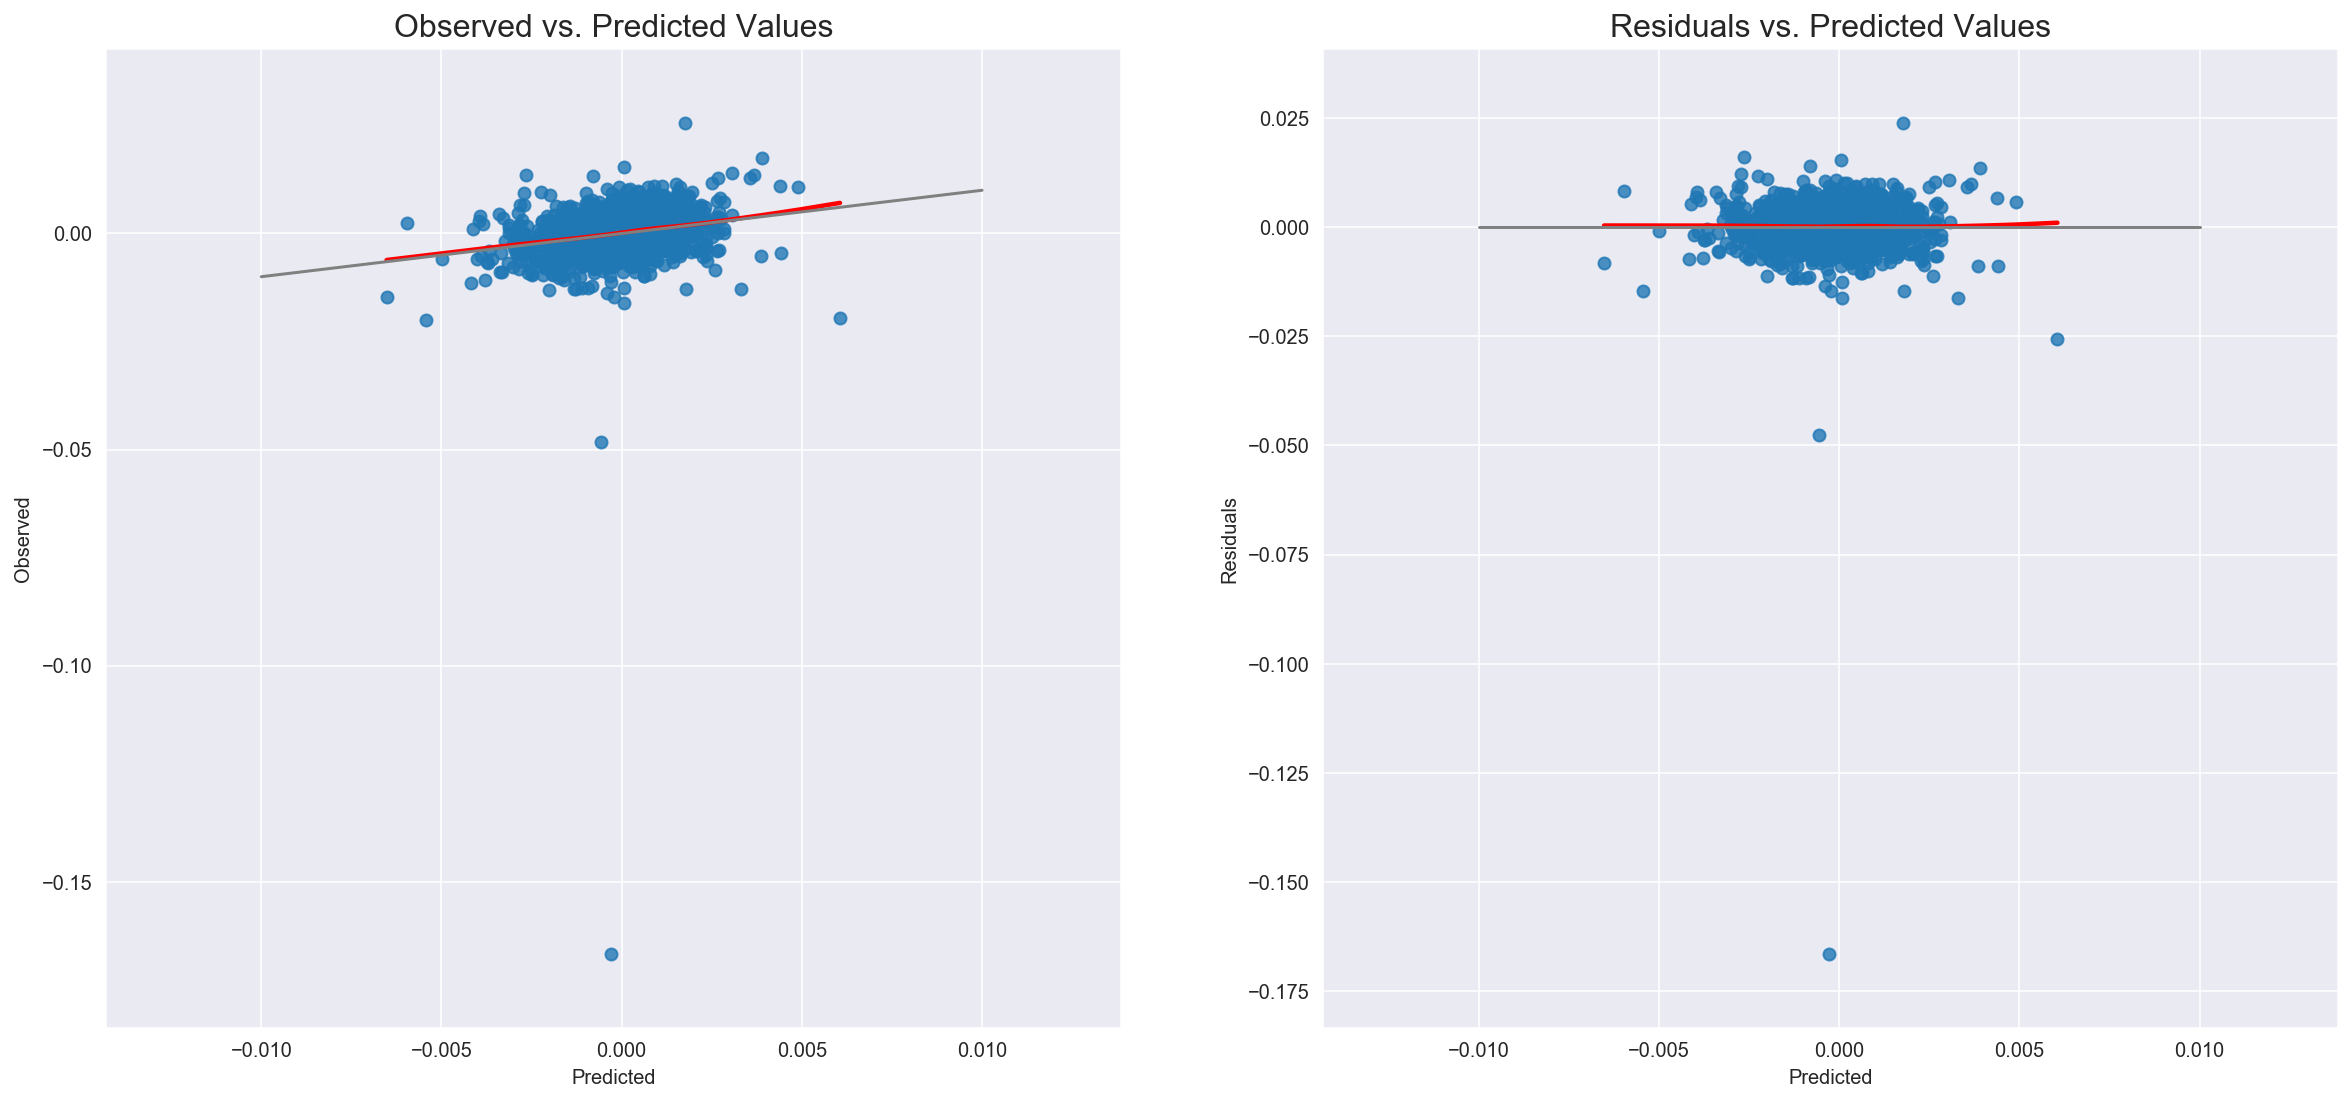

In [42]:
linearity_test(result_p_m, y_portfolio_m) 

Linearity is roughly satisfied since there is clearly a bowl pattern indicating the model is making unusual large/small predictions. If a perfect linearity exists, the left plot should be scattered around diagnal line, and the right plot should be scattered around a horizontal line.

#### Test Strict exogeneity:
The distribution of error terms has zero mean and doesn’t depend on the independent variables X. 
i.e. there must be no relationship between the X and the error term.

In [43]:
print(f"mean of residuals = {resid_p_m.mean()}")

mean of residuals = 2.0738910796235802e-19


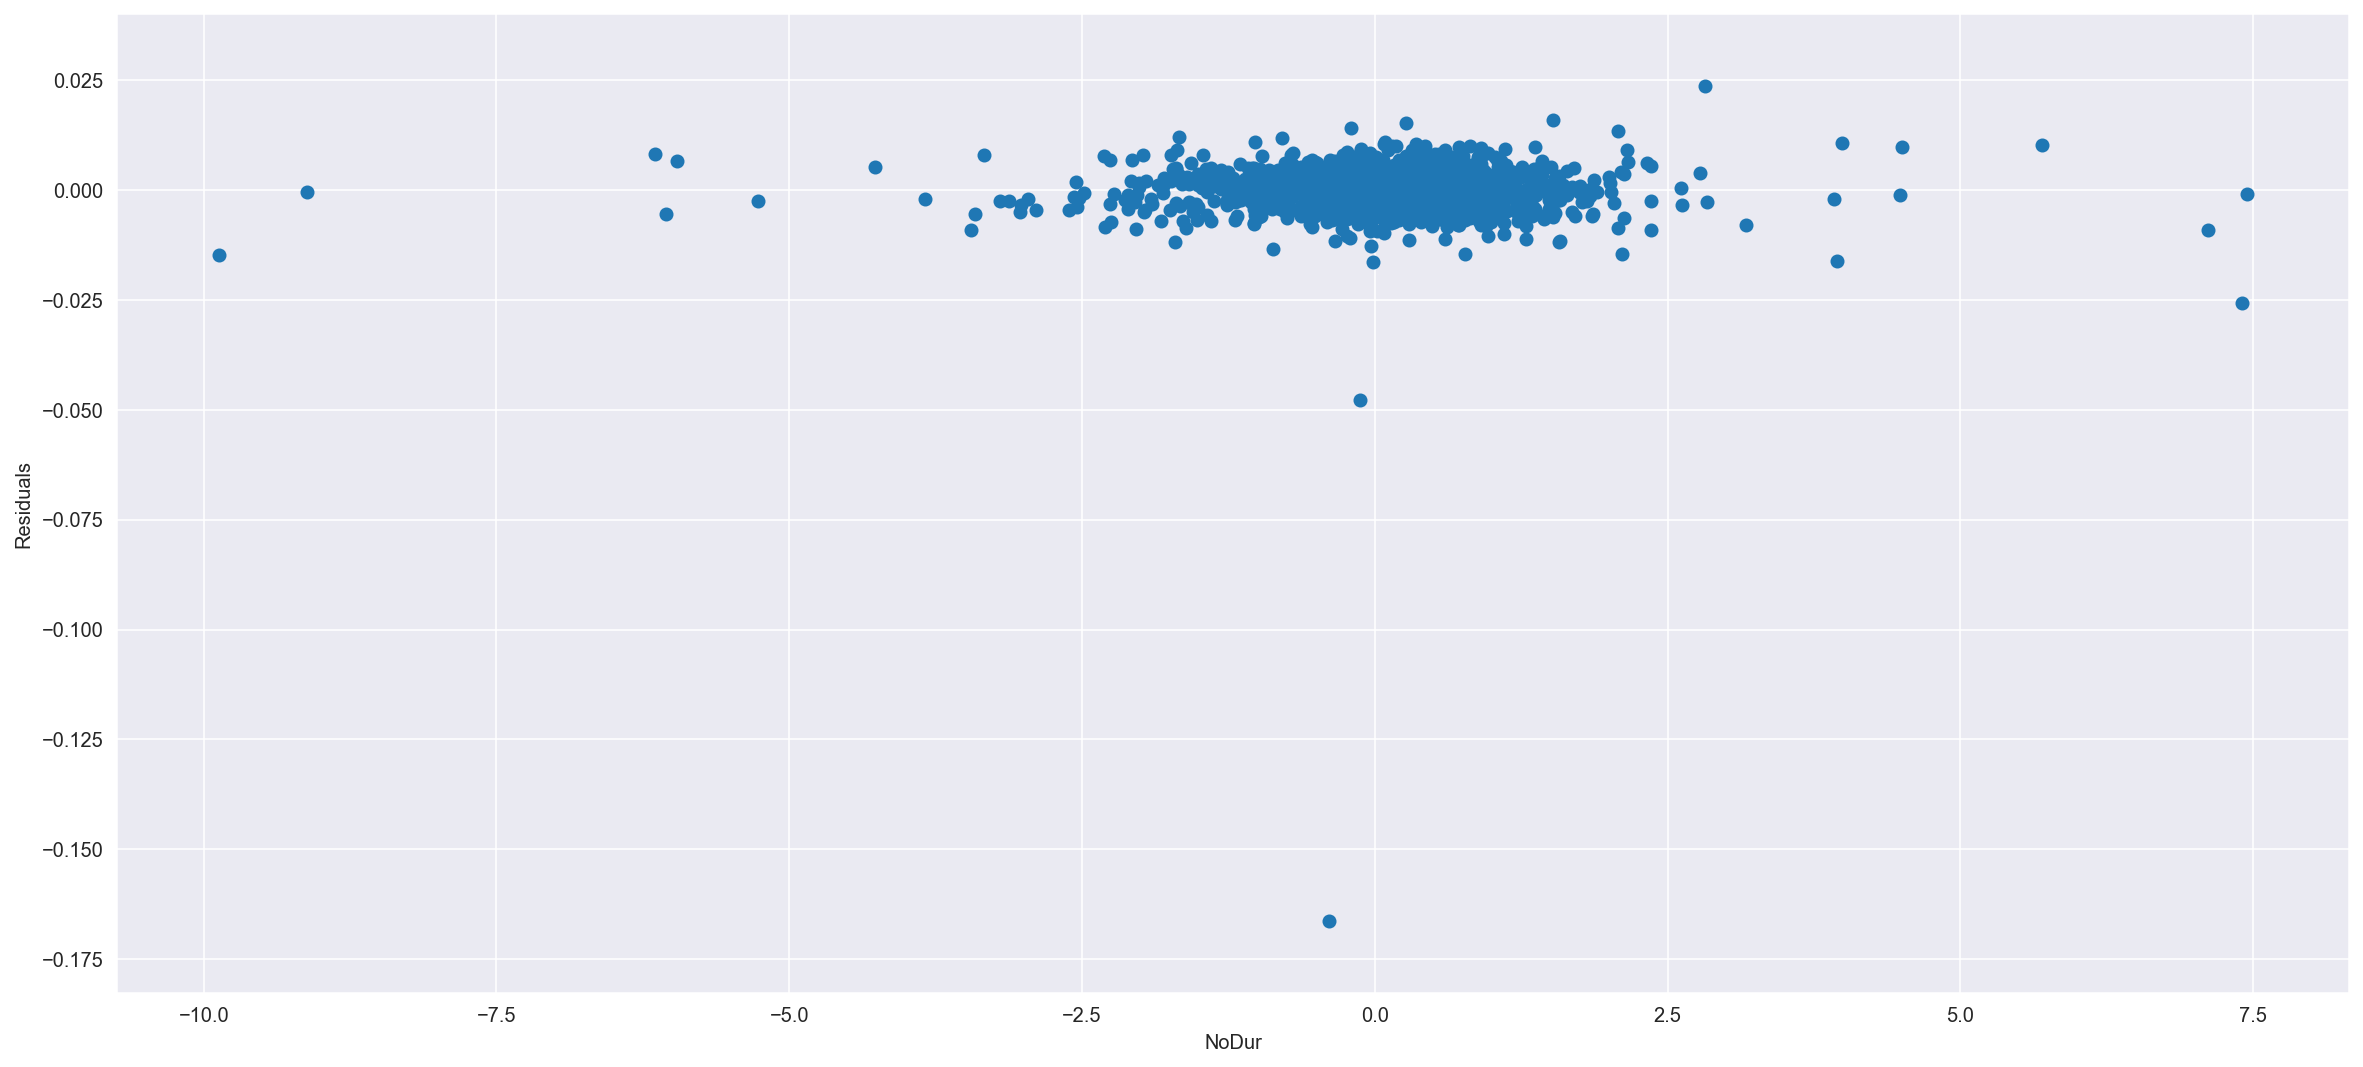

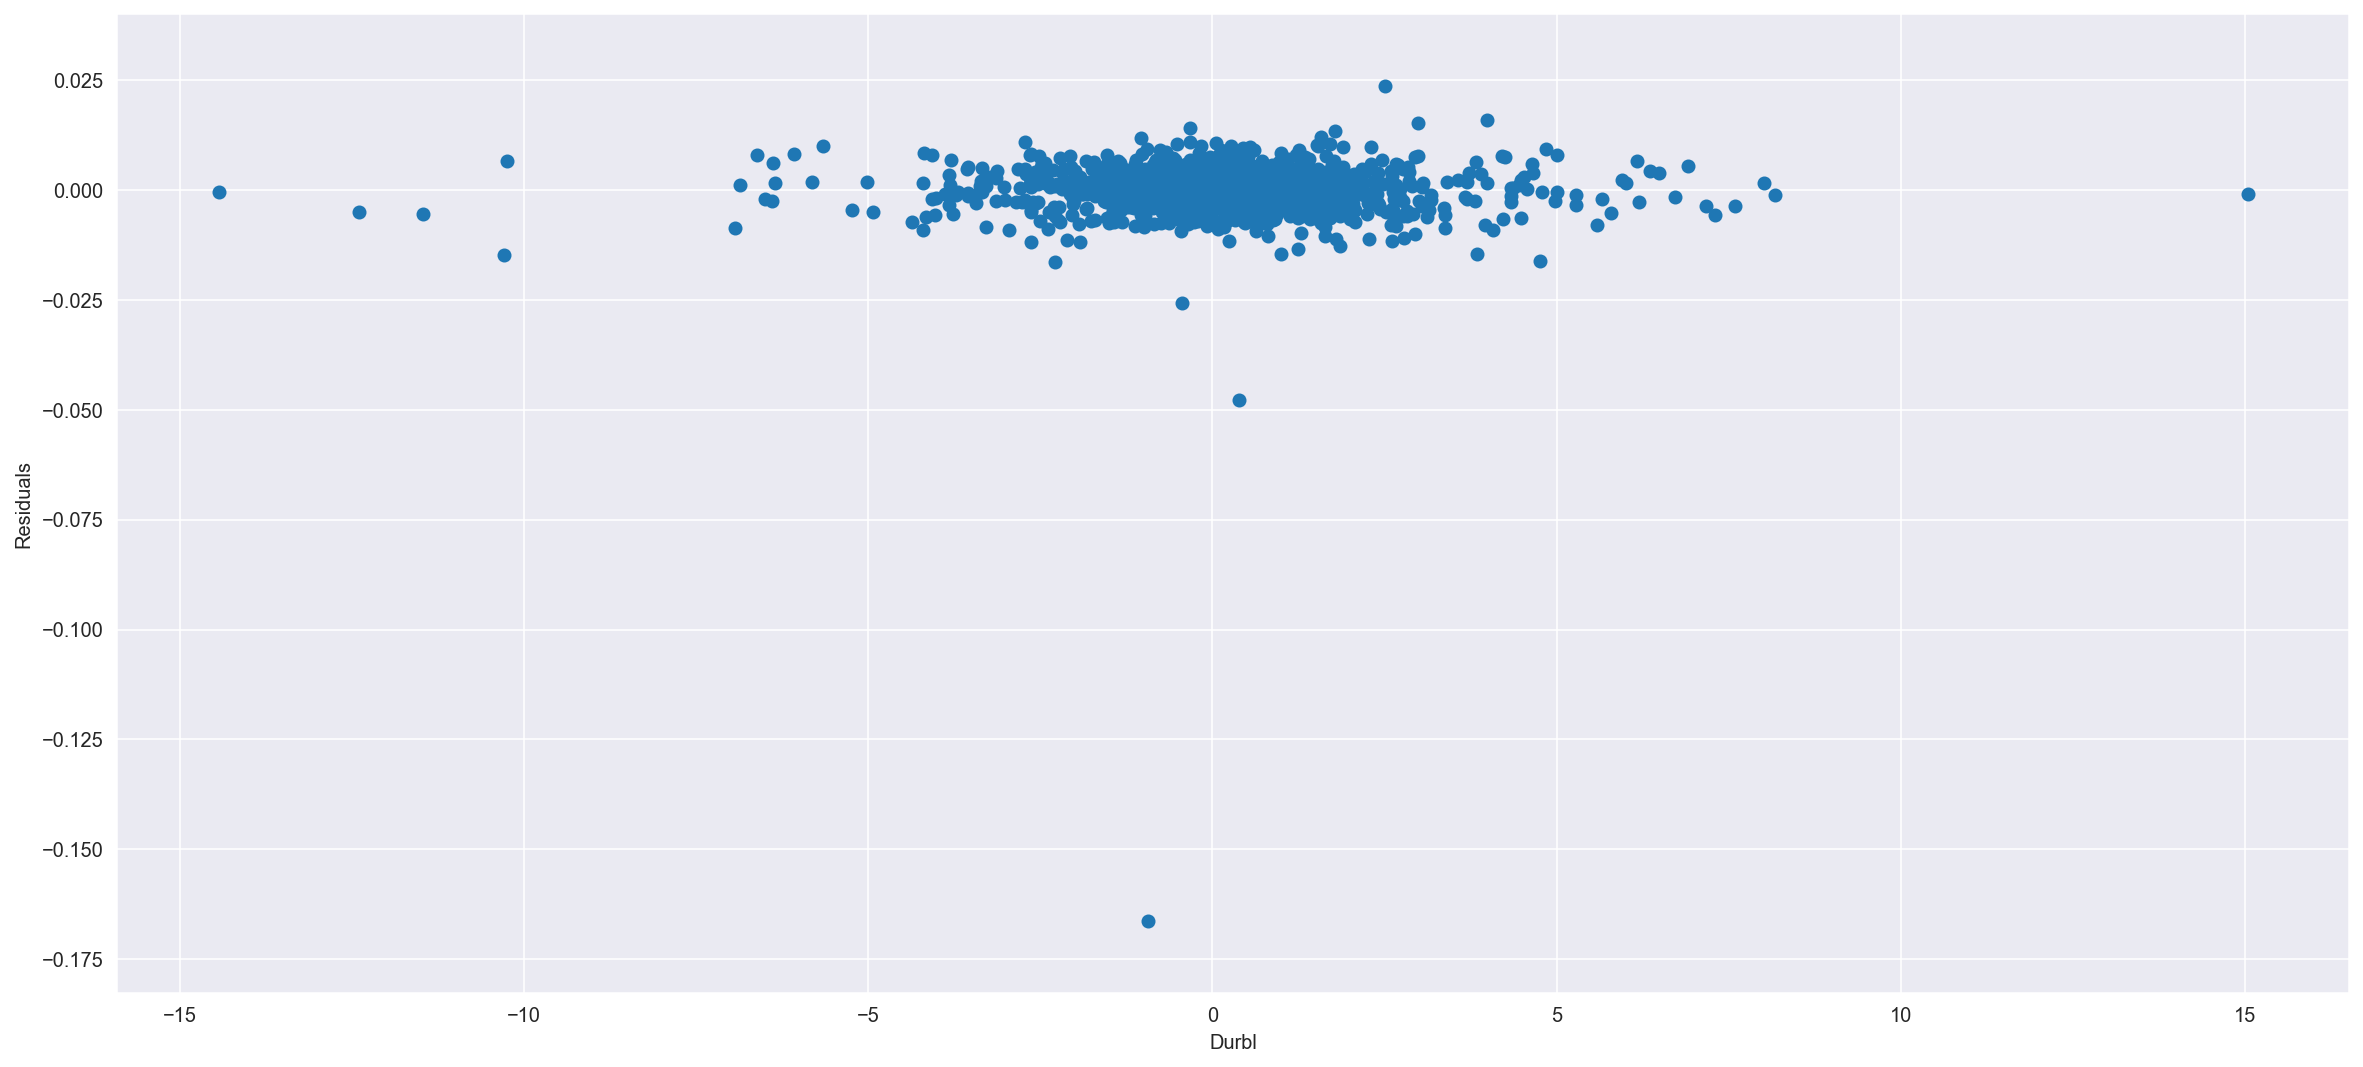

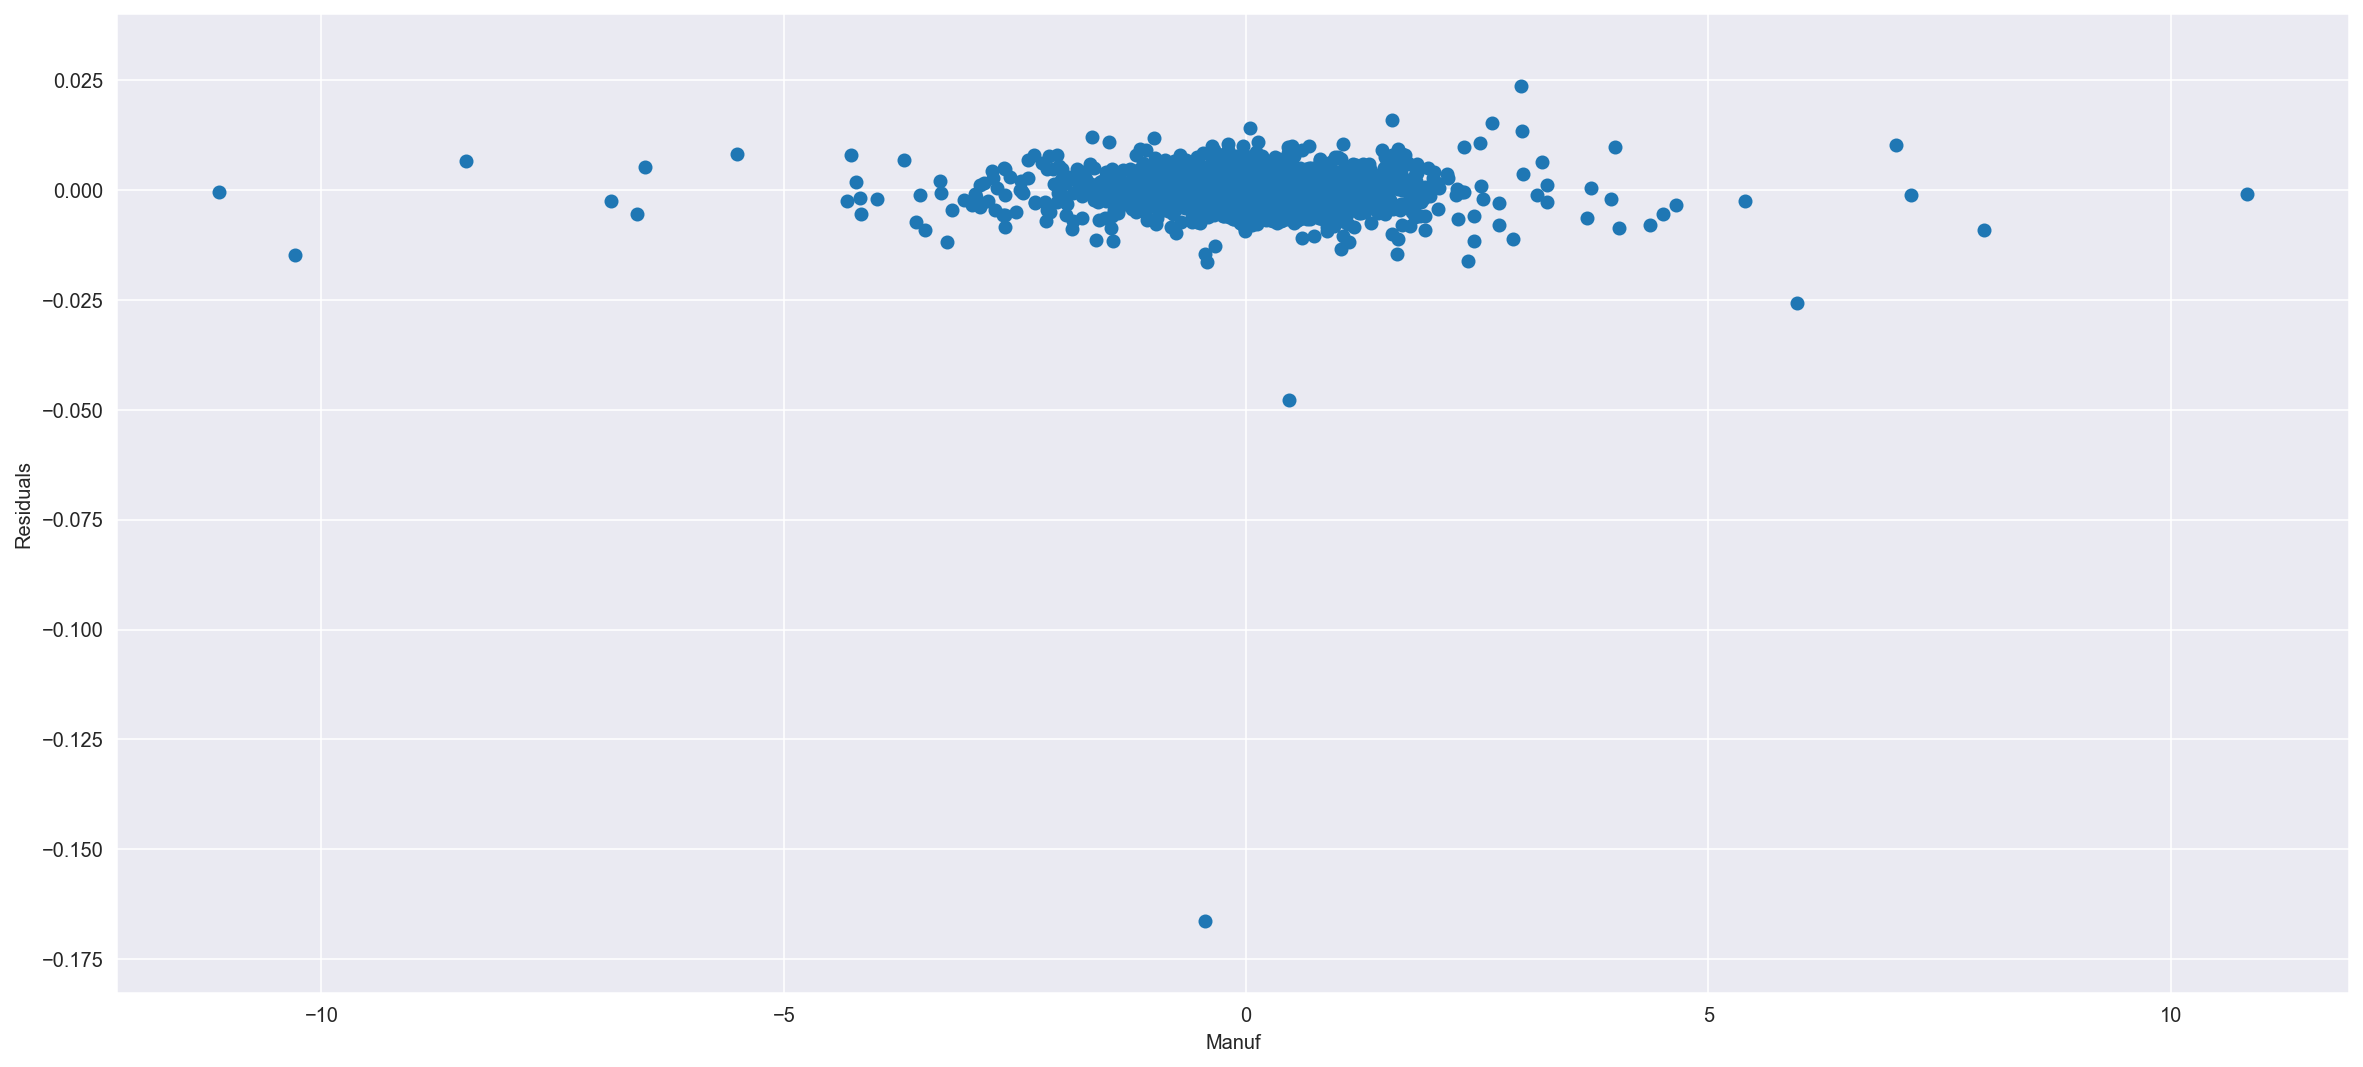

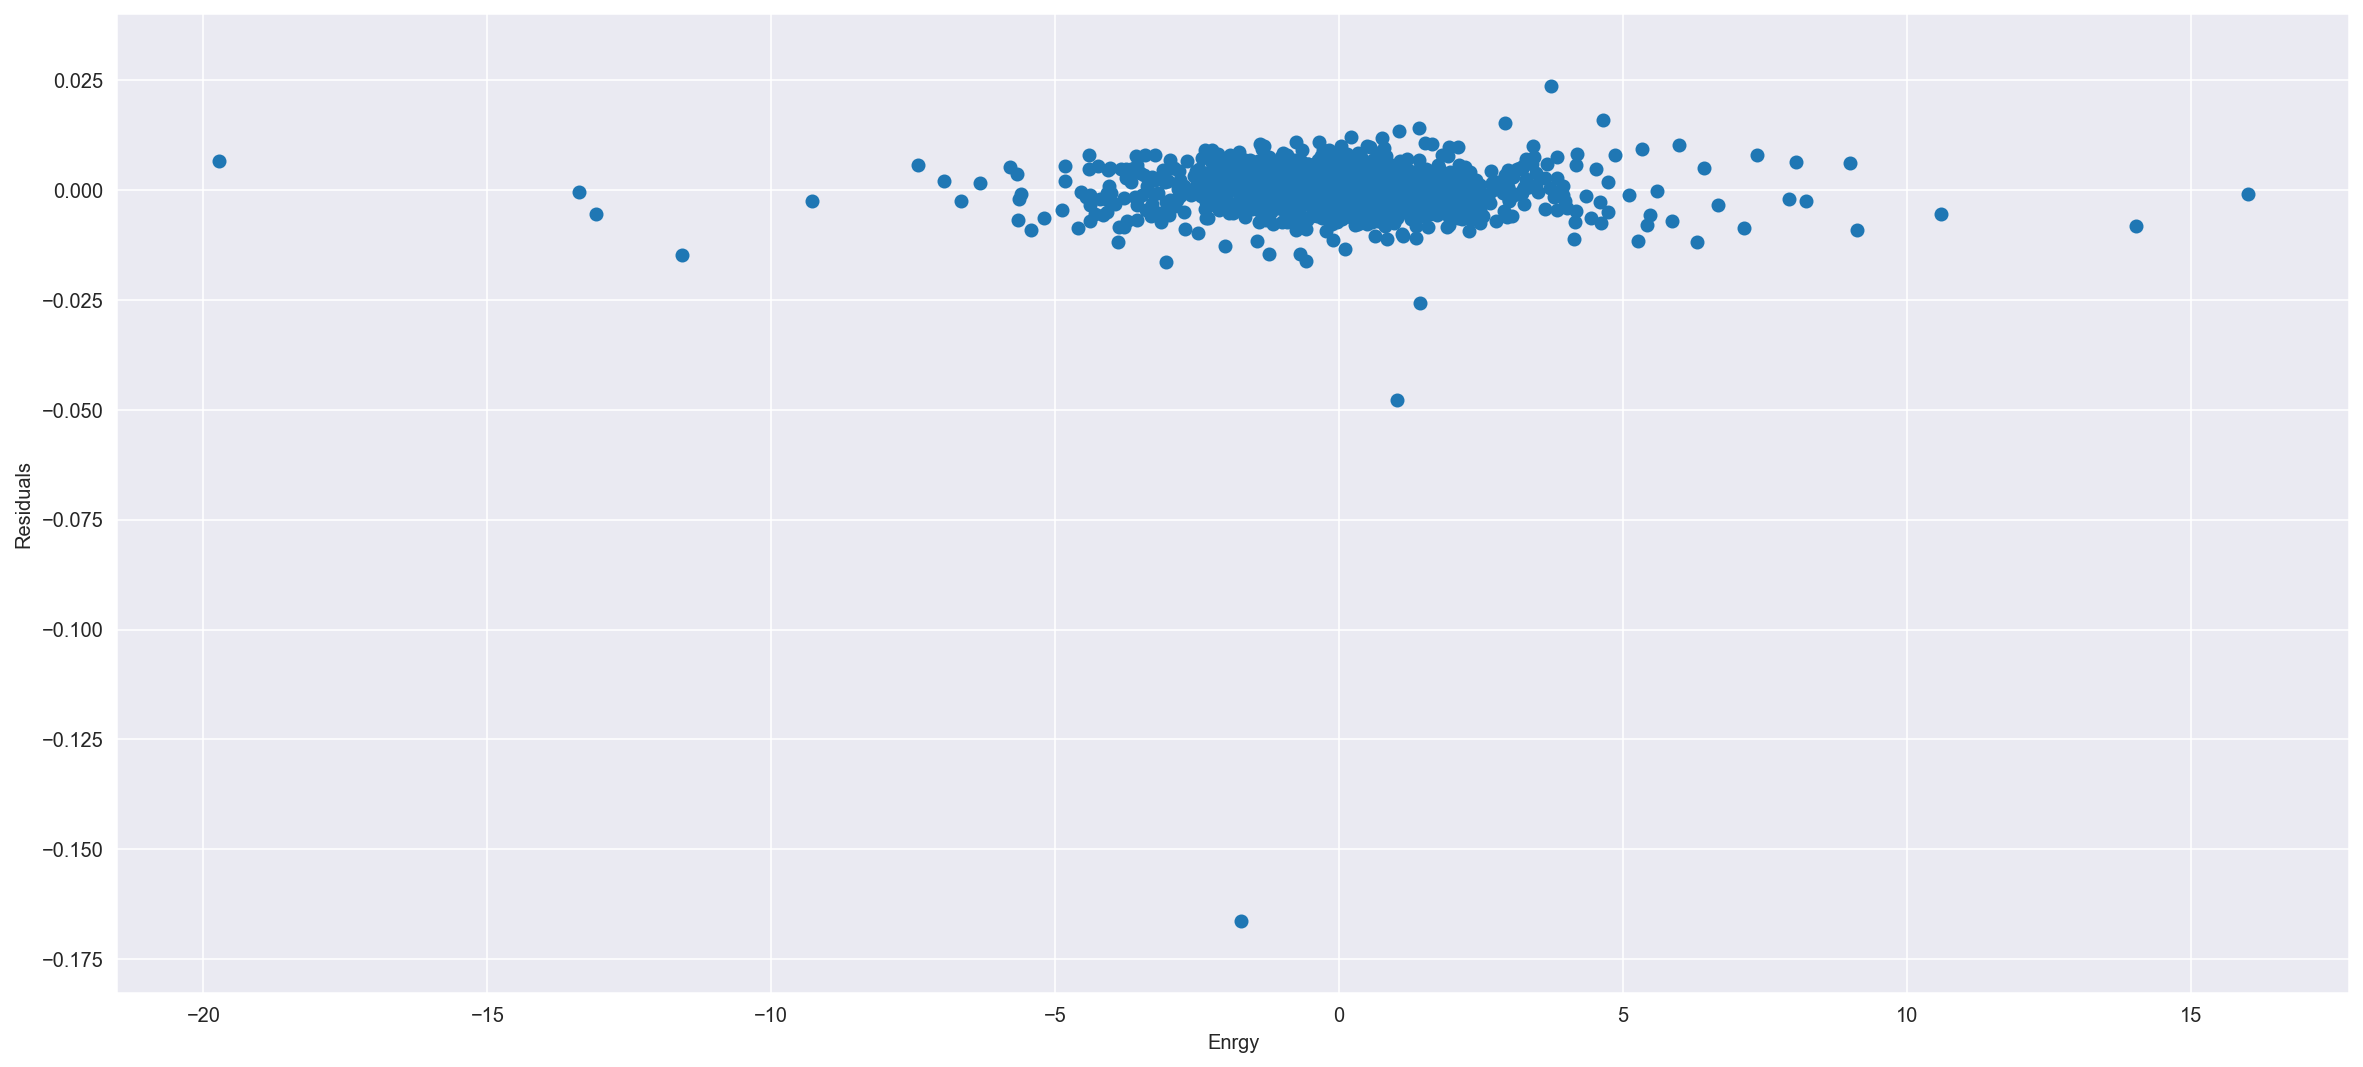

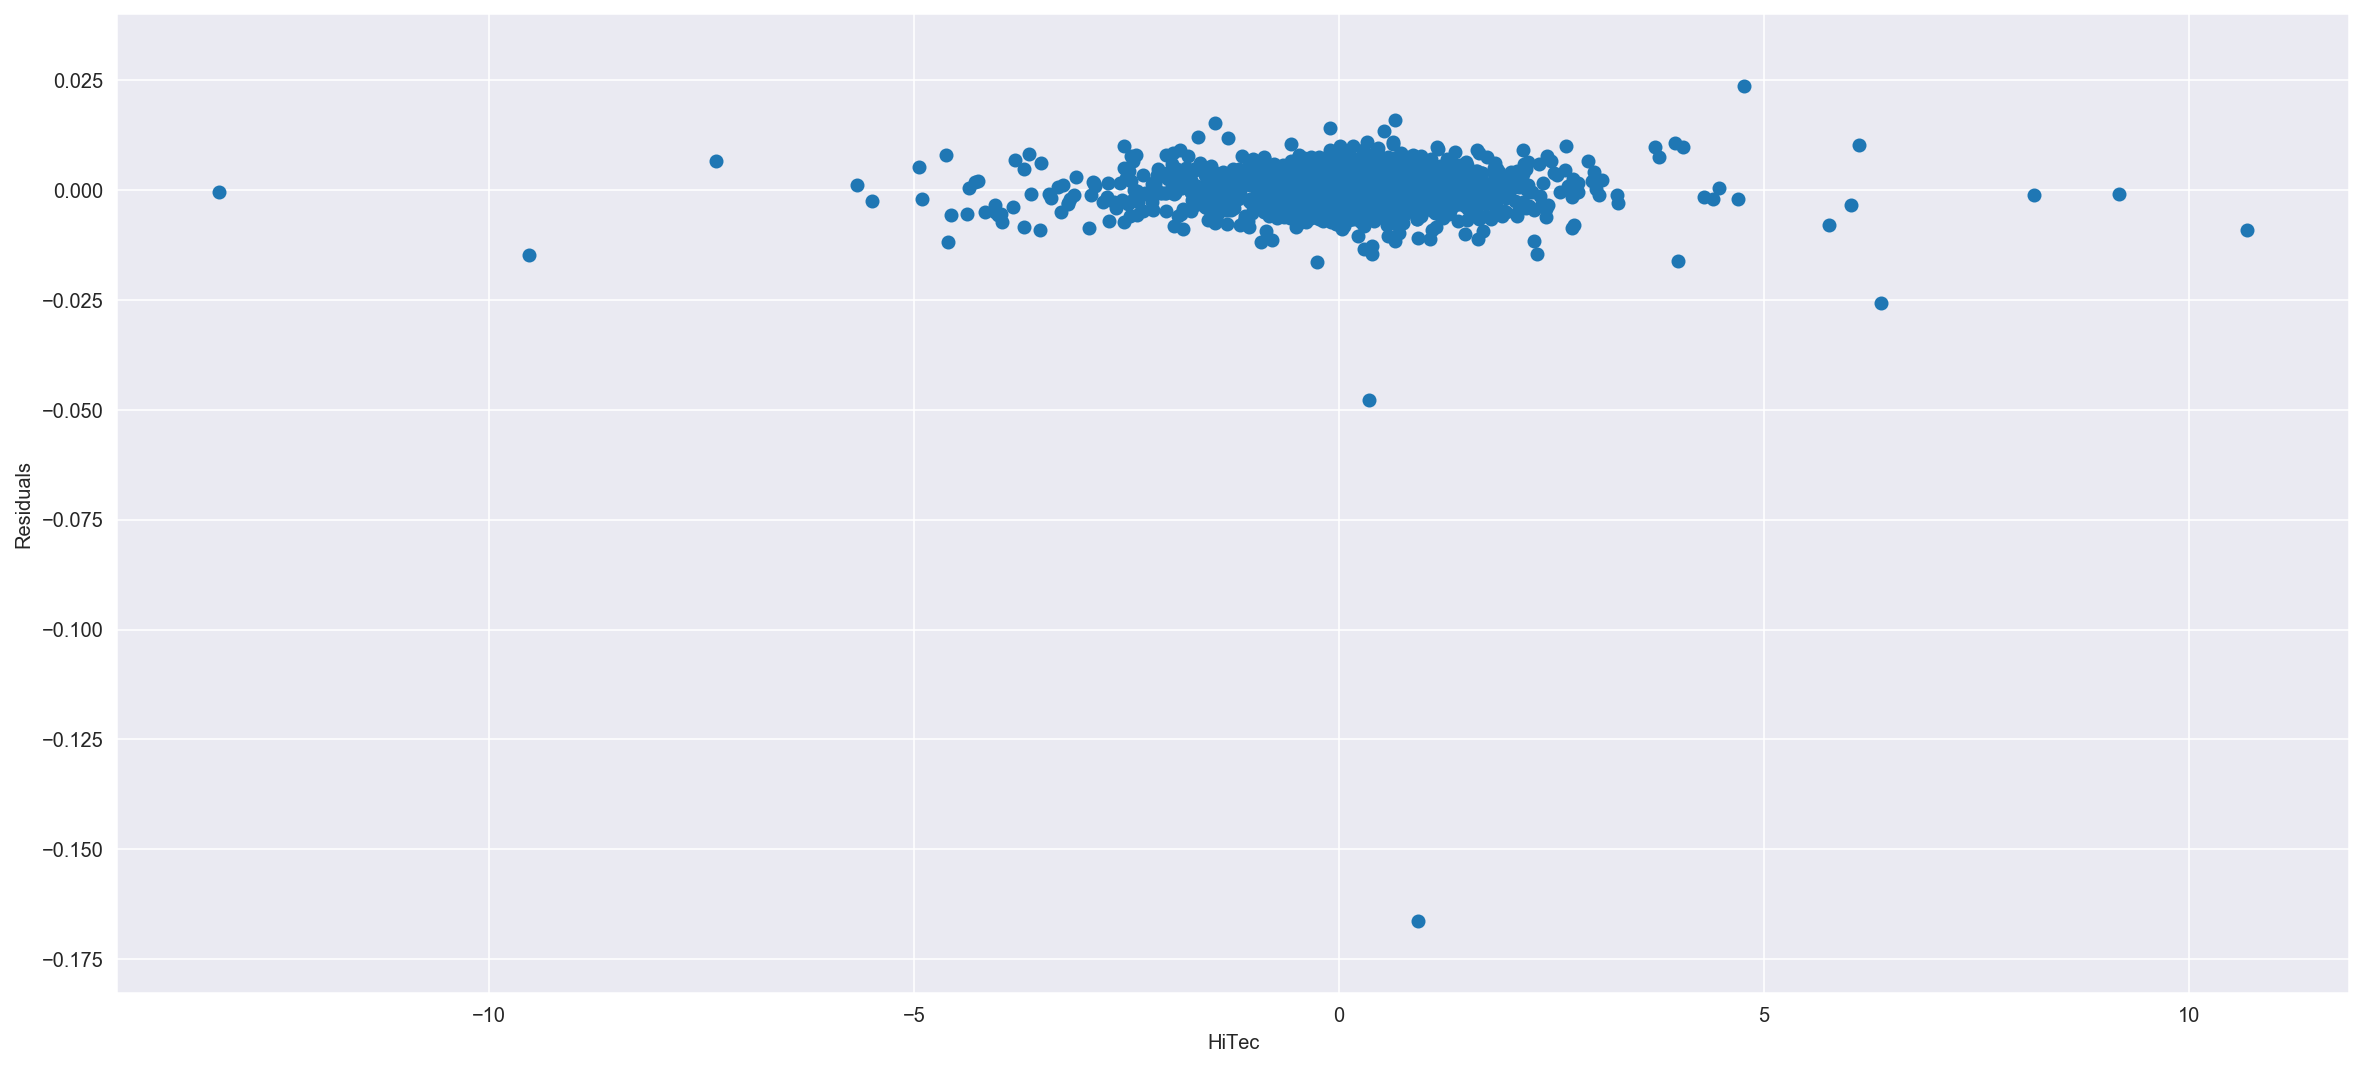

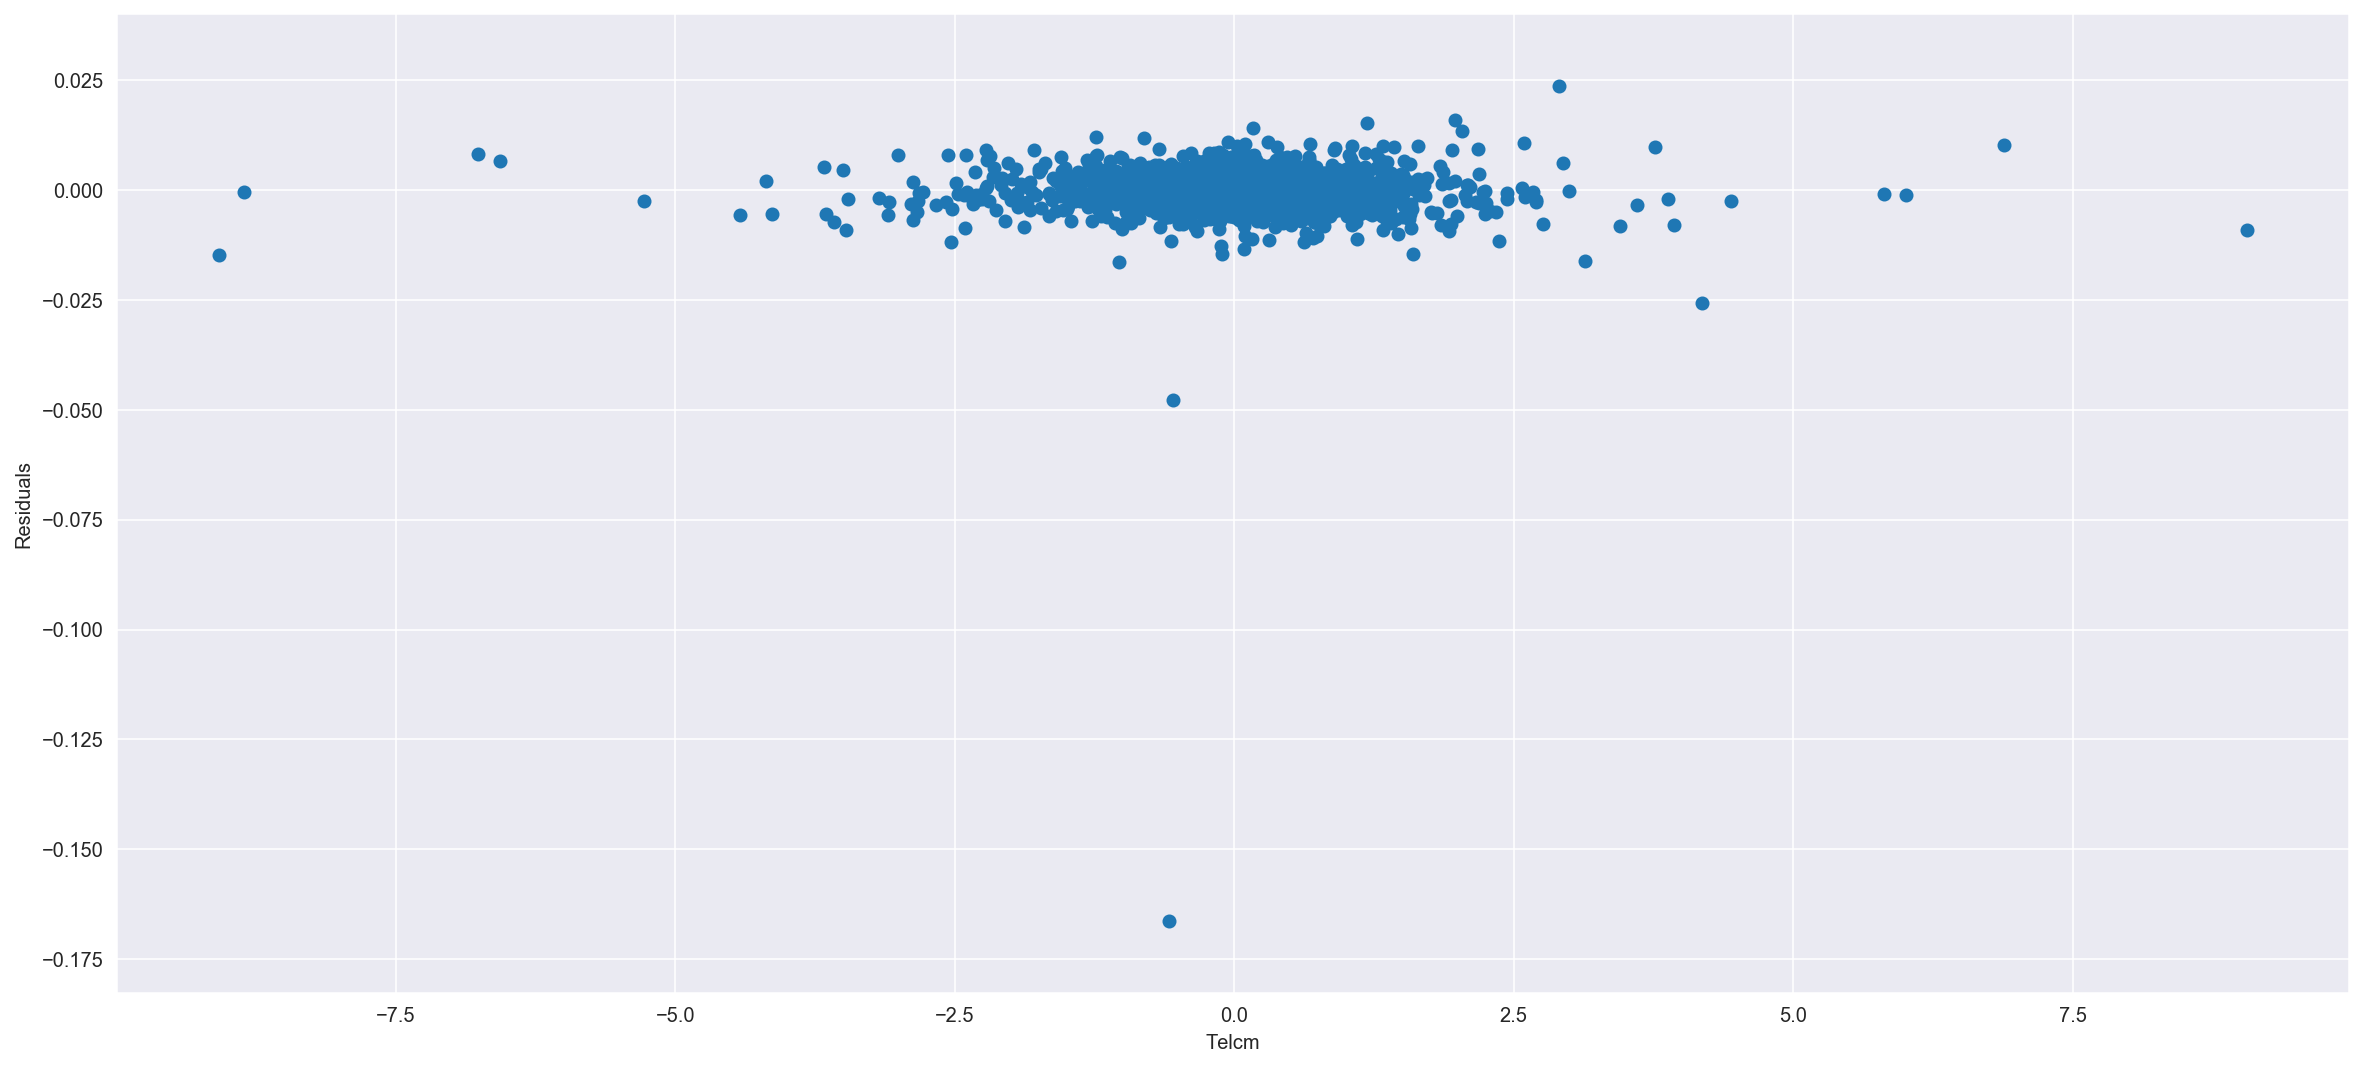

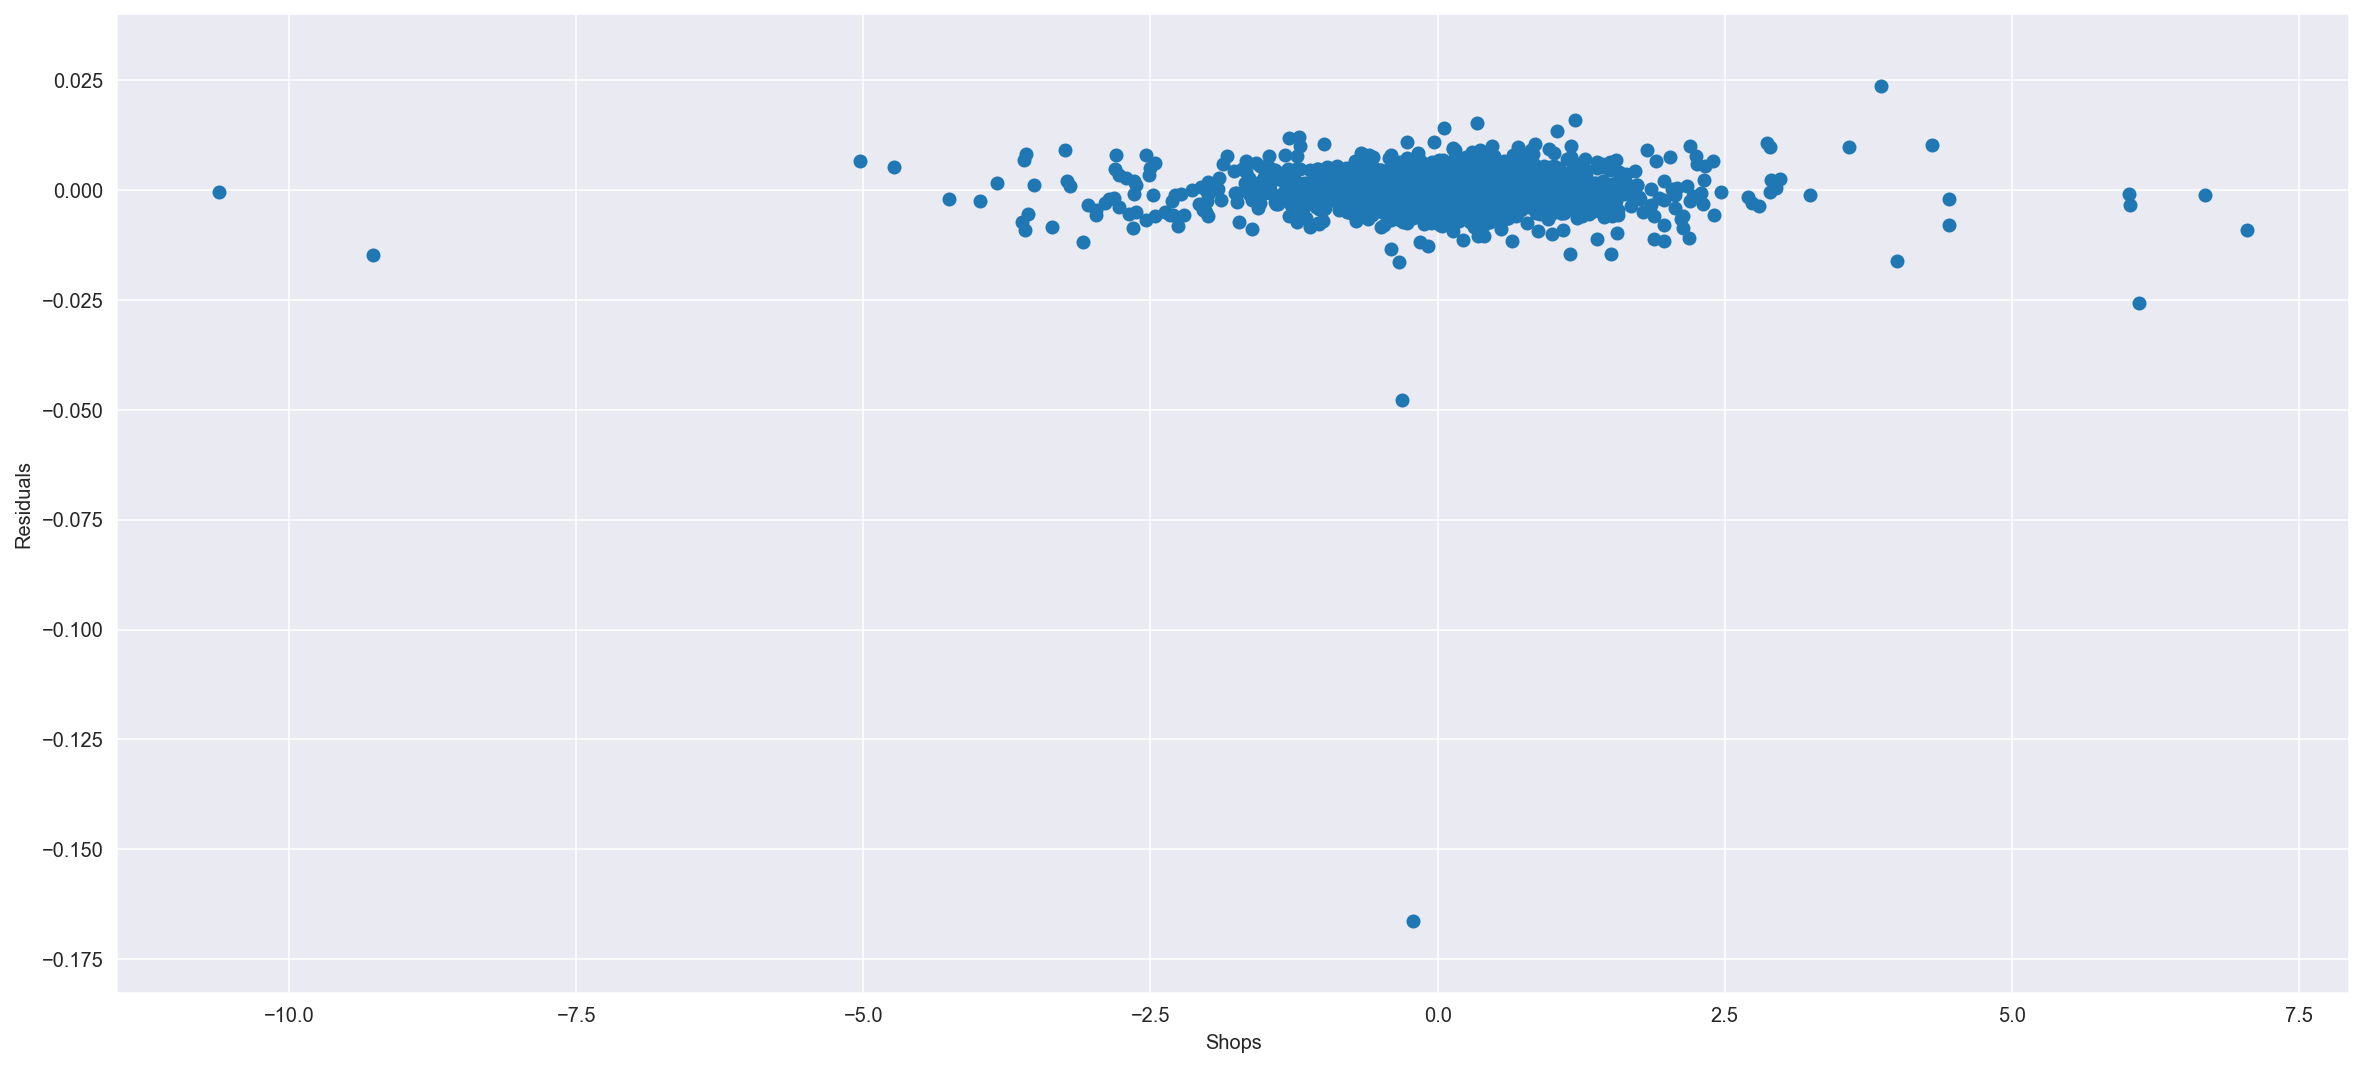

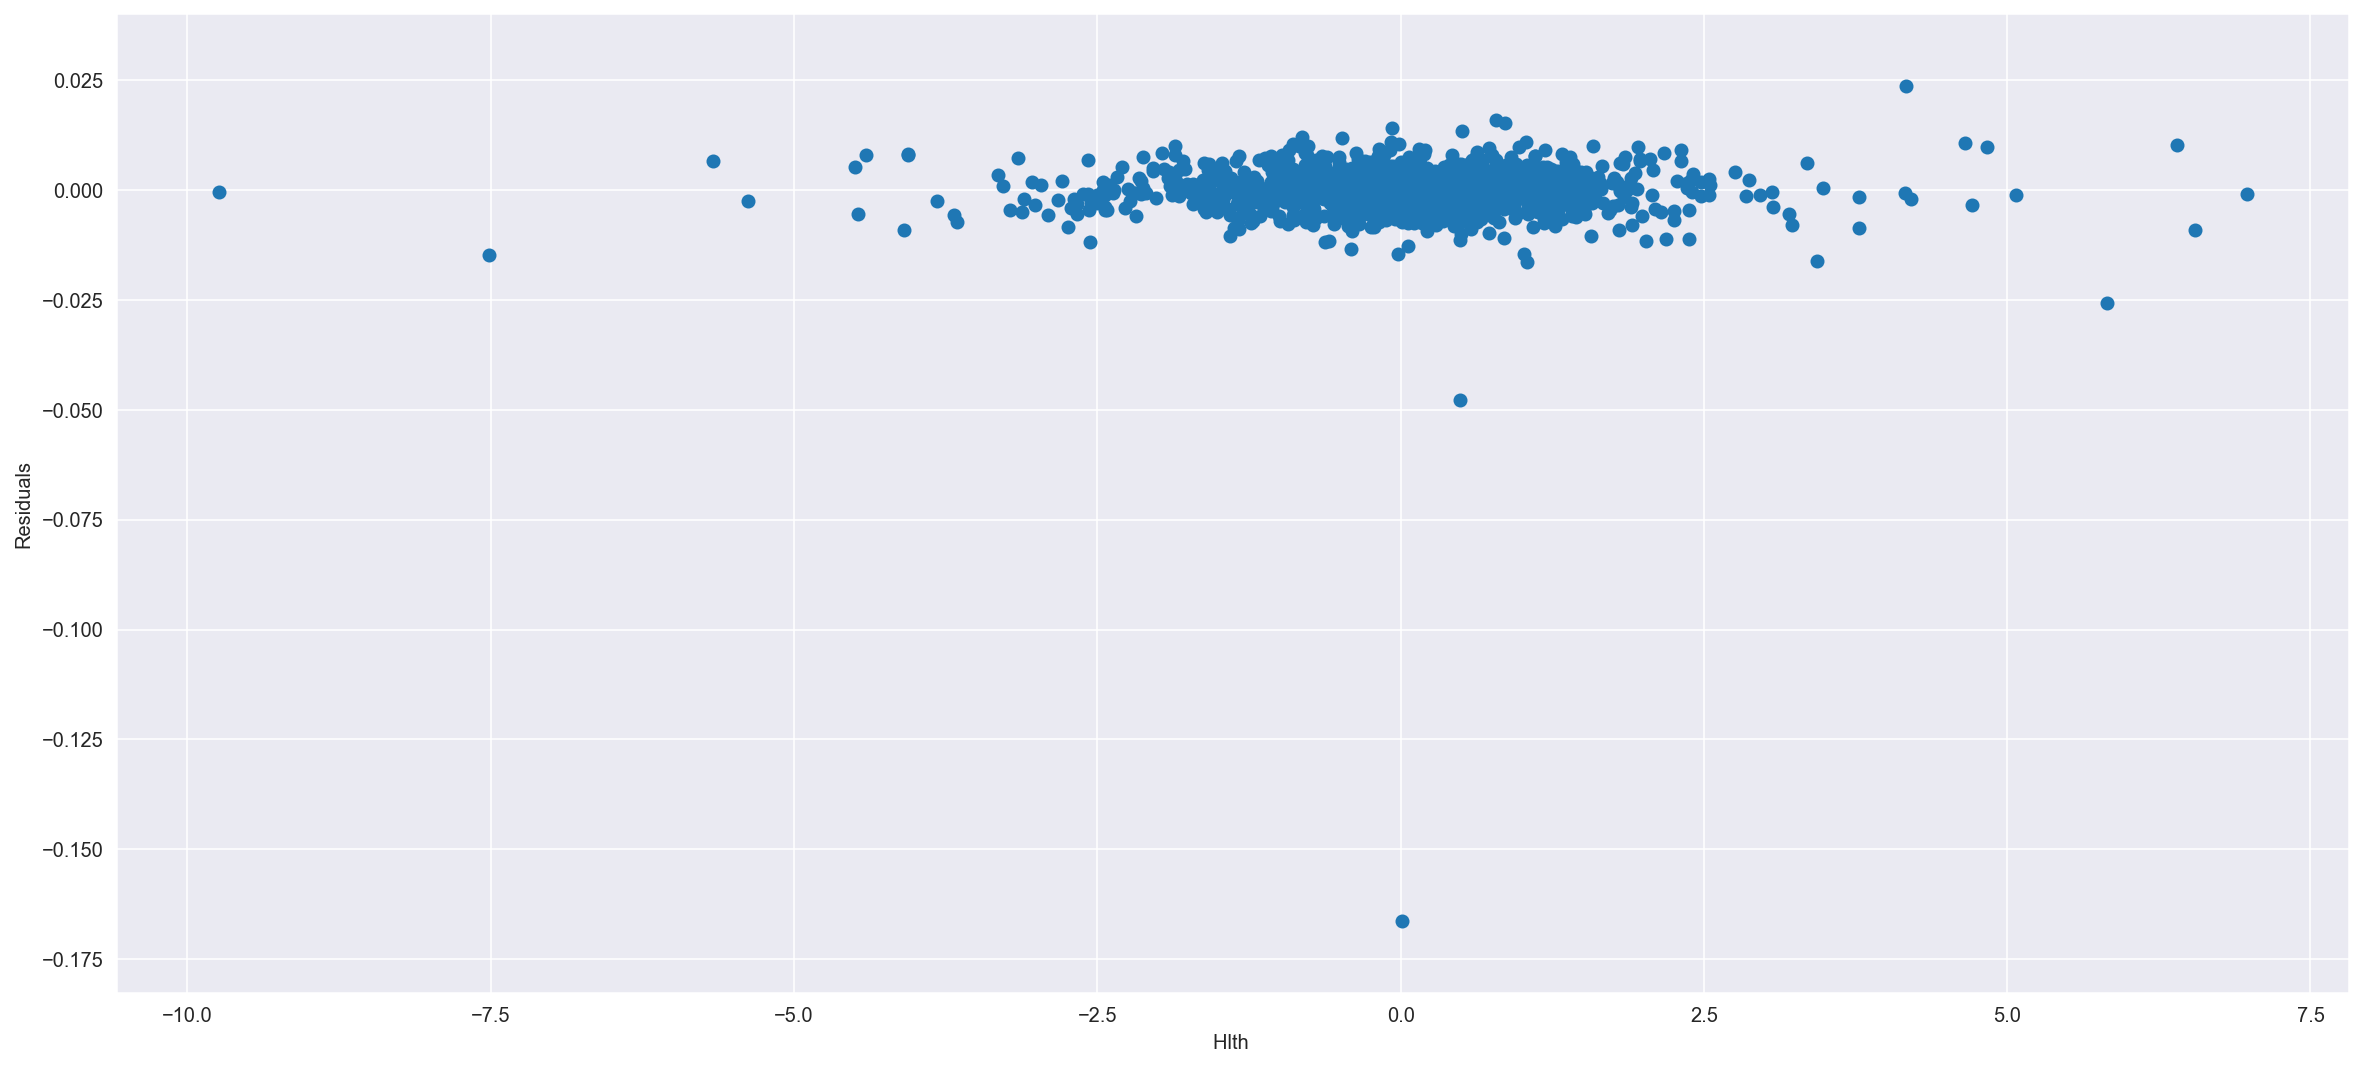

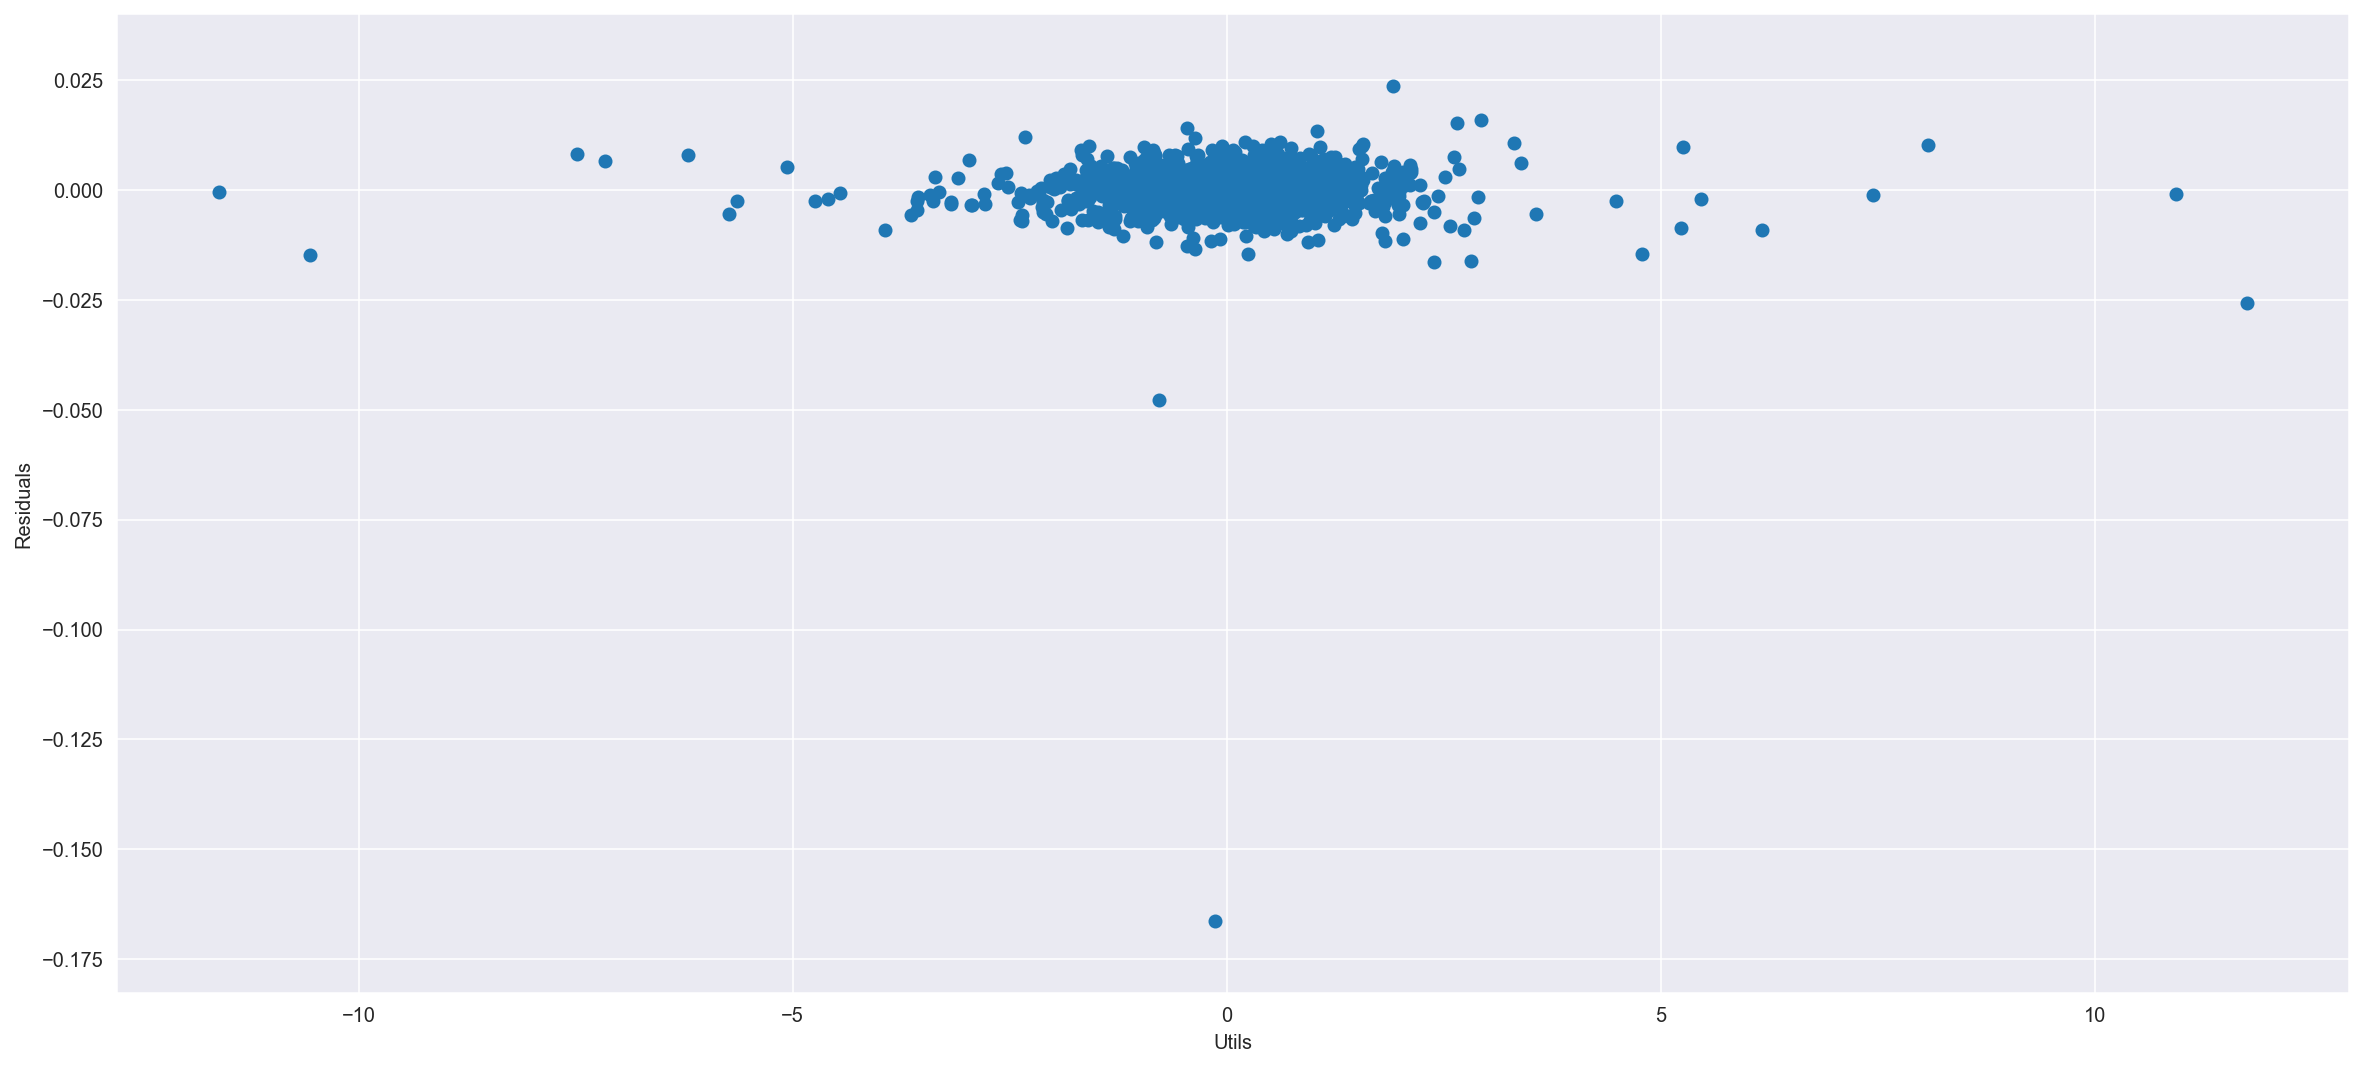

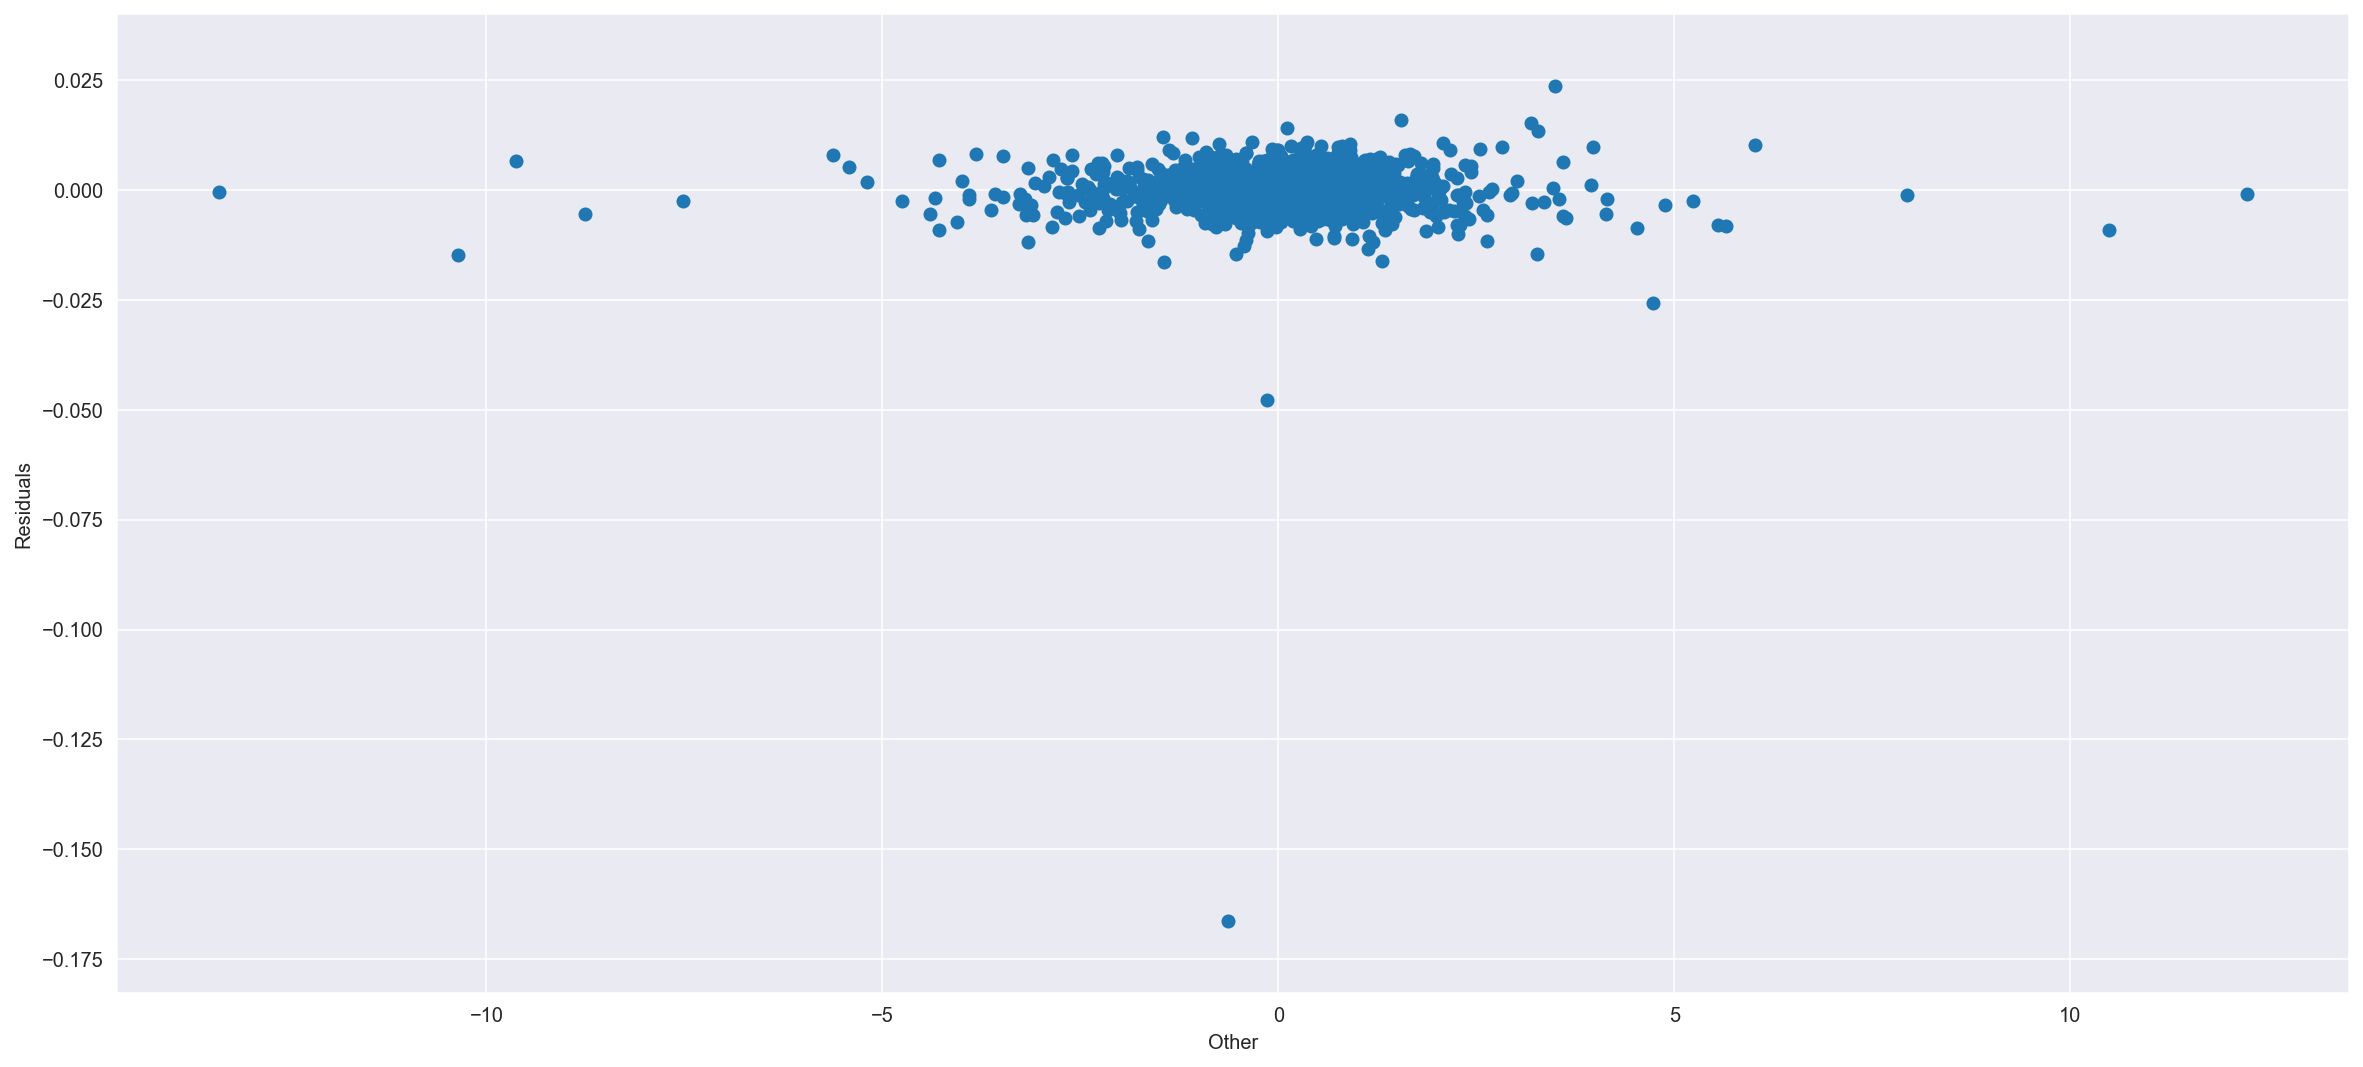

,residuals
NoDur,2.622601e-16
Durbl,3.769607e-16
Manuf,2.466466e-16
Enrgy,2.343364e-16
HiTec,3.051786e-16
Telcm,2.890729e-16
Shops,3.252578e-16
Hlth,2.515912e-16
Utils,1.322241e-16
Other,2.858577e-16


In [44]:
attributes = portfolio10_m_3.columns
for att in attributes:
    plt.scatter(y = resid_p_m, x = portfolio10_m_3[att])
    plt.xlabel(att)
    plt.ylabel('Residuals')
    plt.show()
df = portfolio10_m_3.copy(deep=True)
df['residuals'] = resid_p_m
df.corr()[['residuals']]

In [45]:
pearson_corr_test(X_portfolio_m, resid_p_m)

Performing Pearson Correlation Test ...
NoDur 
 correlation: 2.69335134373989e-16 
 p-value: 1.0000000000008598
 Fail to rej null, conclude non-correlated

Durbl 
 correlation: 3.4170267187229877e-16 
 p-value: 1.0000000000008633
 Fail to rej null, conclude non-correlated

Manuf 
 correlation: 2.553285376565852e-16 
 p-value: 1.0000000000008598
 Fail to rej null, conclude non-correlated

Enrgy 
 correlation: 1.9649078203154355e-16 
 p-value: 1.0000000000008598
 Fail to rej null, conclude non-correlated

HiTec 
 correlation: 3.155400739405031e-16 
 p-value: 1.0000000000008633
 Fail to rej null, conclude non-correlated

Telcm 
 correlation: 2.8161076342332004e-16 
 p-value: 1.0000000000008633
 Fail to rej null, conclude non-correlated

Shops 
 correlation: 2.9921301381278104e-16 
 p-value: 1.0000000000008633
 Fail to rej null, conclude non-correlated

Hlth  
 correlation: 2.566642778711791e-16 
 p-value: 1.0000000000008598
 Fail to rej null, conclude non-correlated

Utils 
 correlation: 

Strict exogeneity is satisfied.

#### Test No Multicollinearity:

In [46]:
# bivariate correlation
portfolio10_m_3.corr()

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
NoDur,1.000000,0.609421,0.836017,0.590057,0.724551,0.787322,0.762017,0.712356,0.779554,0.787068
Durbl,0.609421,1.000000,0.724403,0.563068,0.710368,0.605774,0.692263,0.597911,0.427165,0.723210
Manuf,0.836017,0.724403,1.000000,0.758563,0.814286,0.806055,0.795540,0.764108,0.687297,0.930921
Enrgy,0.590057,0.563068,0.758563,1.000000,0.570372,0.627980,0.543758,0.548570,0.536045,0.761328
HiTec,0.724551,0.710368,0.814286,0.570372,1.000000,0.723247,0.878377,0.793653,0.547951,0.803040
Telcm,0.787322,0.605774,0.806055,0.627980,0.723247,1.000000,0.747719,0.700704,0.656090,0.813765
Shops,0.762017,0.692263,0.795540,0.543758,0.878377,0.747719,1.000000,0.765978,0.571866,0.789415
Hlth,0.712356,0.597911,0.764108,0.548570,0.793653,0.700704,0.765978,1.000000,0.591914,0.765090
Utils,0.779554,0.427165,0.687297,0.536045,0.547951,0.656090,0.571866,0.591914,1.000000,0.631713
Other,0.787068,0.723210,0.930921,0.761328,0.803040,0.813765,0.789415,0.765090,0.631713,1.000000


In [47]:
VIF_test(X_portfolio_m)

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
vif,5.326717,2.456764,11.112542,2.690649,5.922488,3.731577,5.506307,3.300608,2.769162,9.512111


No Multicollinearity is NOT satisfied due to the relatively high correlations between 
- Manuf and NoDur
- HiTec and NoDur
- Telcm and NoDur
- Shops and NoDur
- Others and NoDur
- etc (any > 0.7)

VIF furtherly confirms this result.

#### Test Spherical error variance:

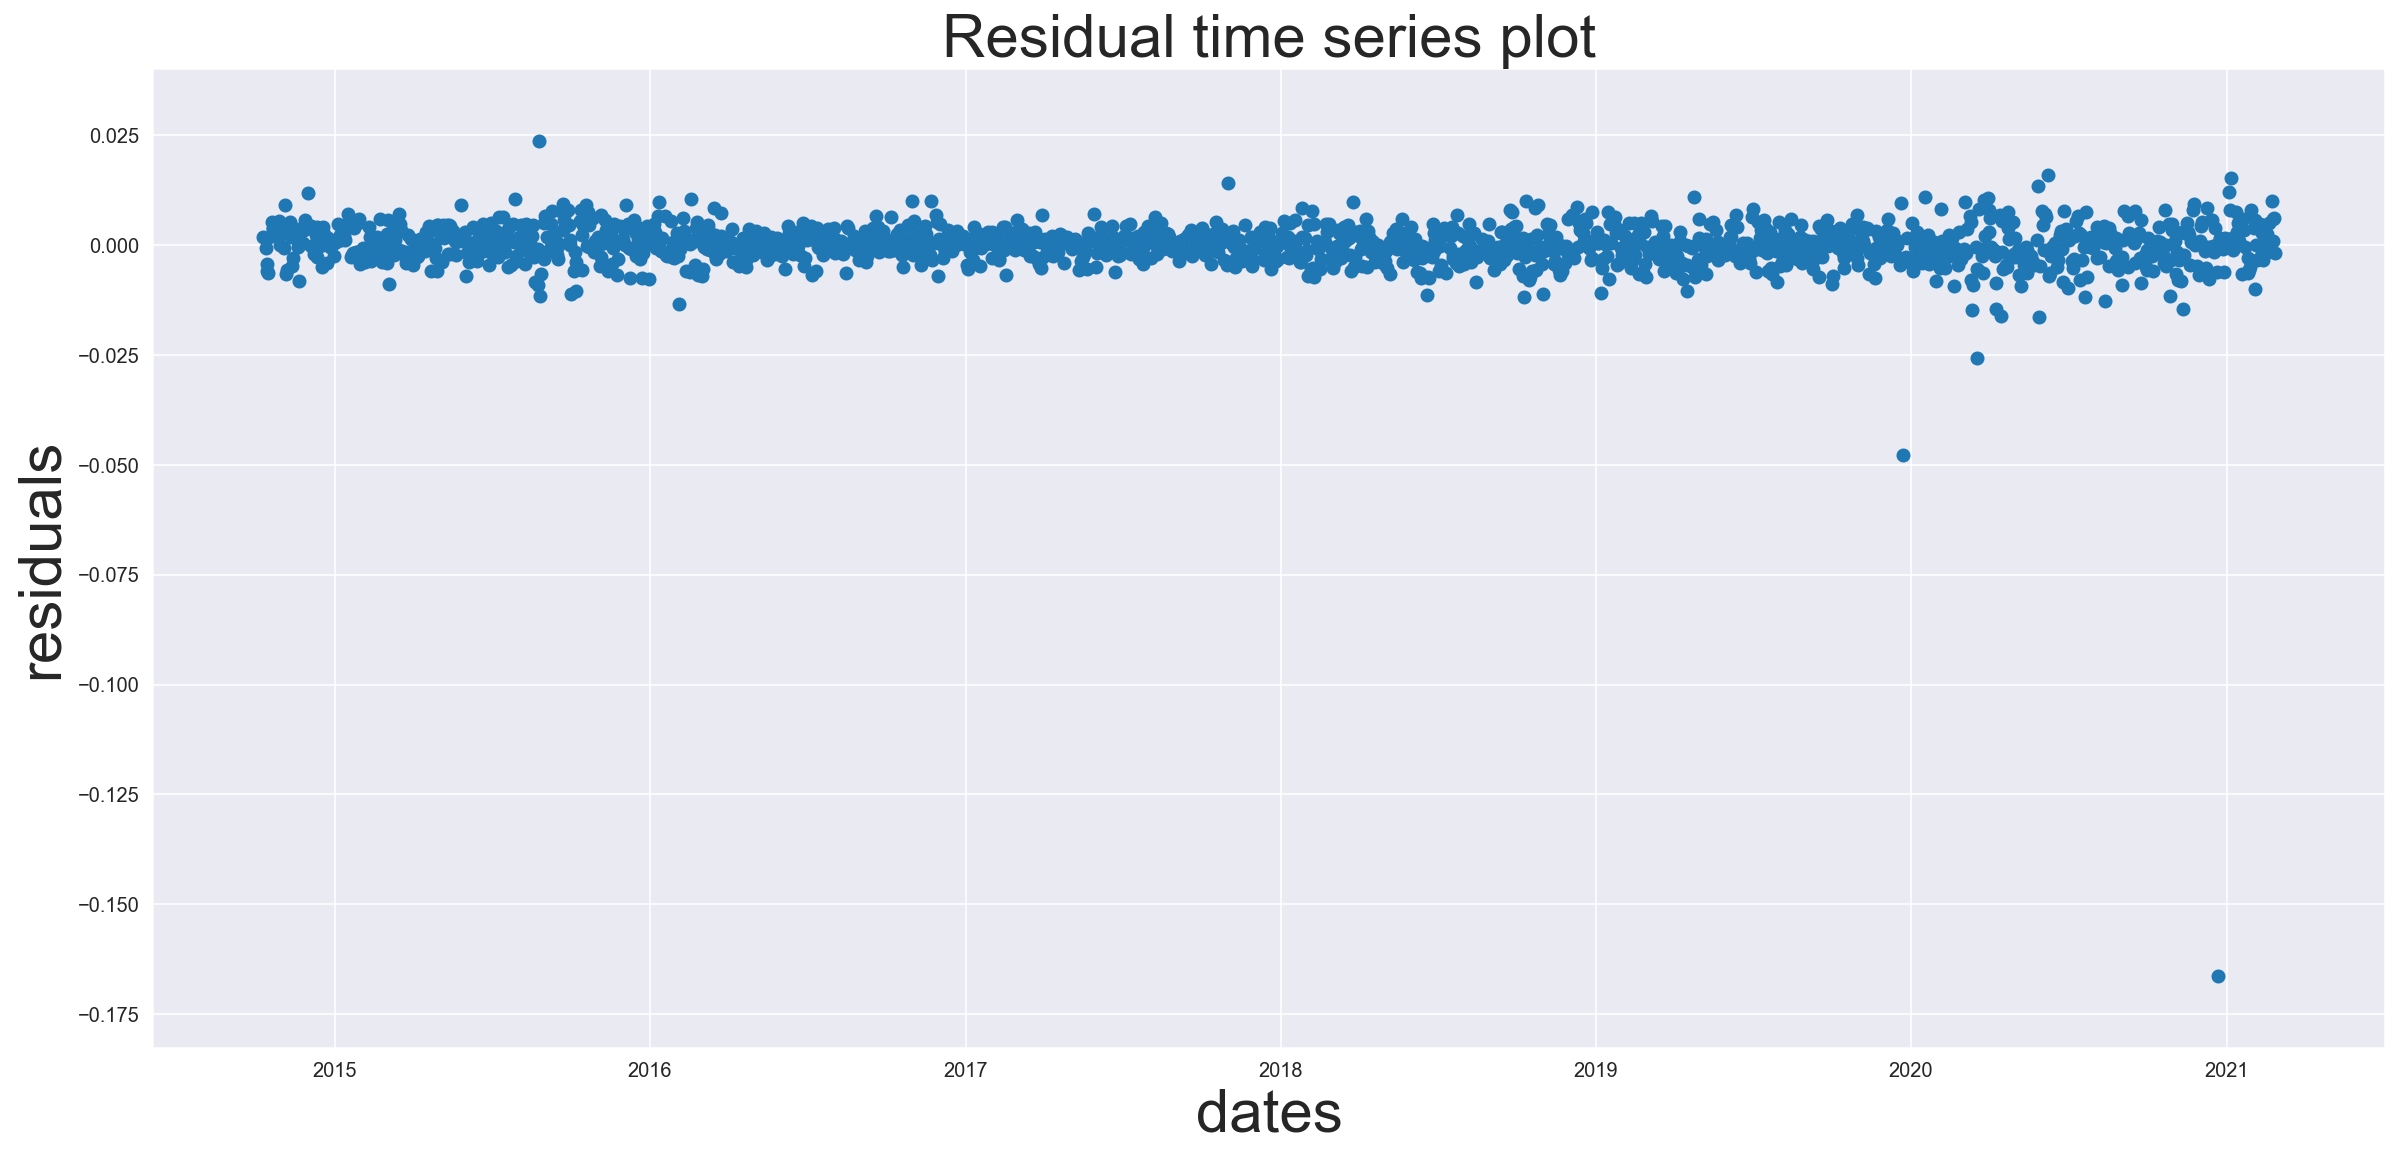

In [48]:
# to see constant variance of error terms
plt.scatter(y = resid_p_m, x = portfolio10_m_3.index)
plt.title('Residual time series plot', fontsize = 30)
plt.ylabel('residuals', fontsize = 30)
plt.xlabel('dates', fontsize = 30)
plt.show()


---- Breusch-Pagan test ----
                                  value
Lagrange multiplier statistic  6.217089
p-value                        0.796706
f-value                        0.619850
f p-value                      0.798017
Fail to Reject Null, conclude homoscedasticity

---- Goldfeld-Quandt test ----
                     value
F statistic   5.330579e+00
p-value      6.178674e-111
Reject Null, conclude heteroscedasticity

---- Residuals plots ----


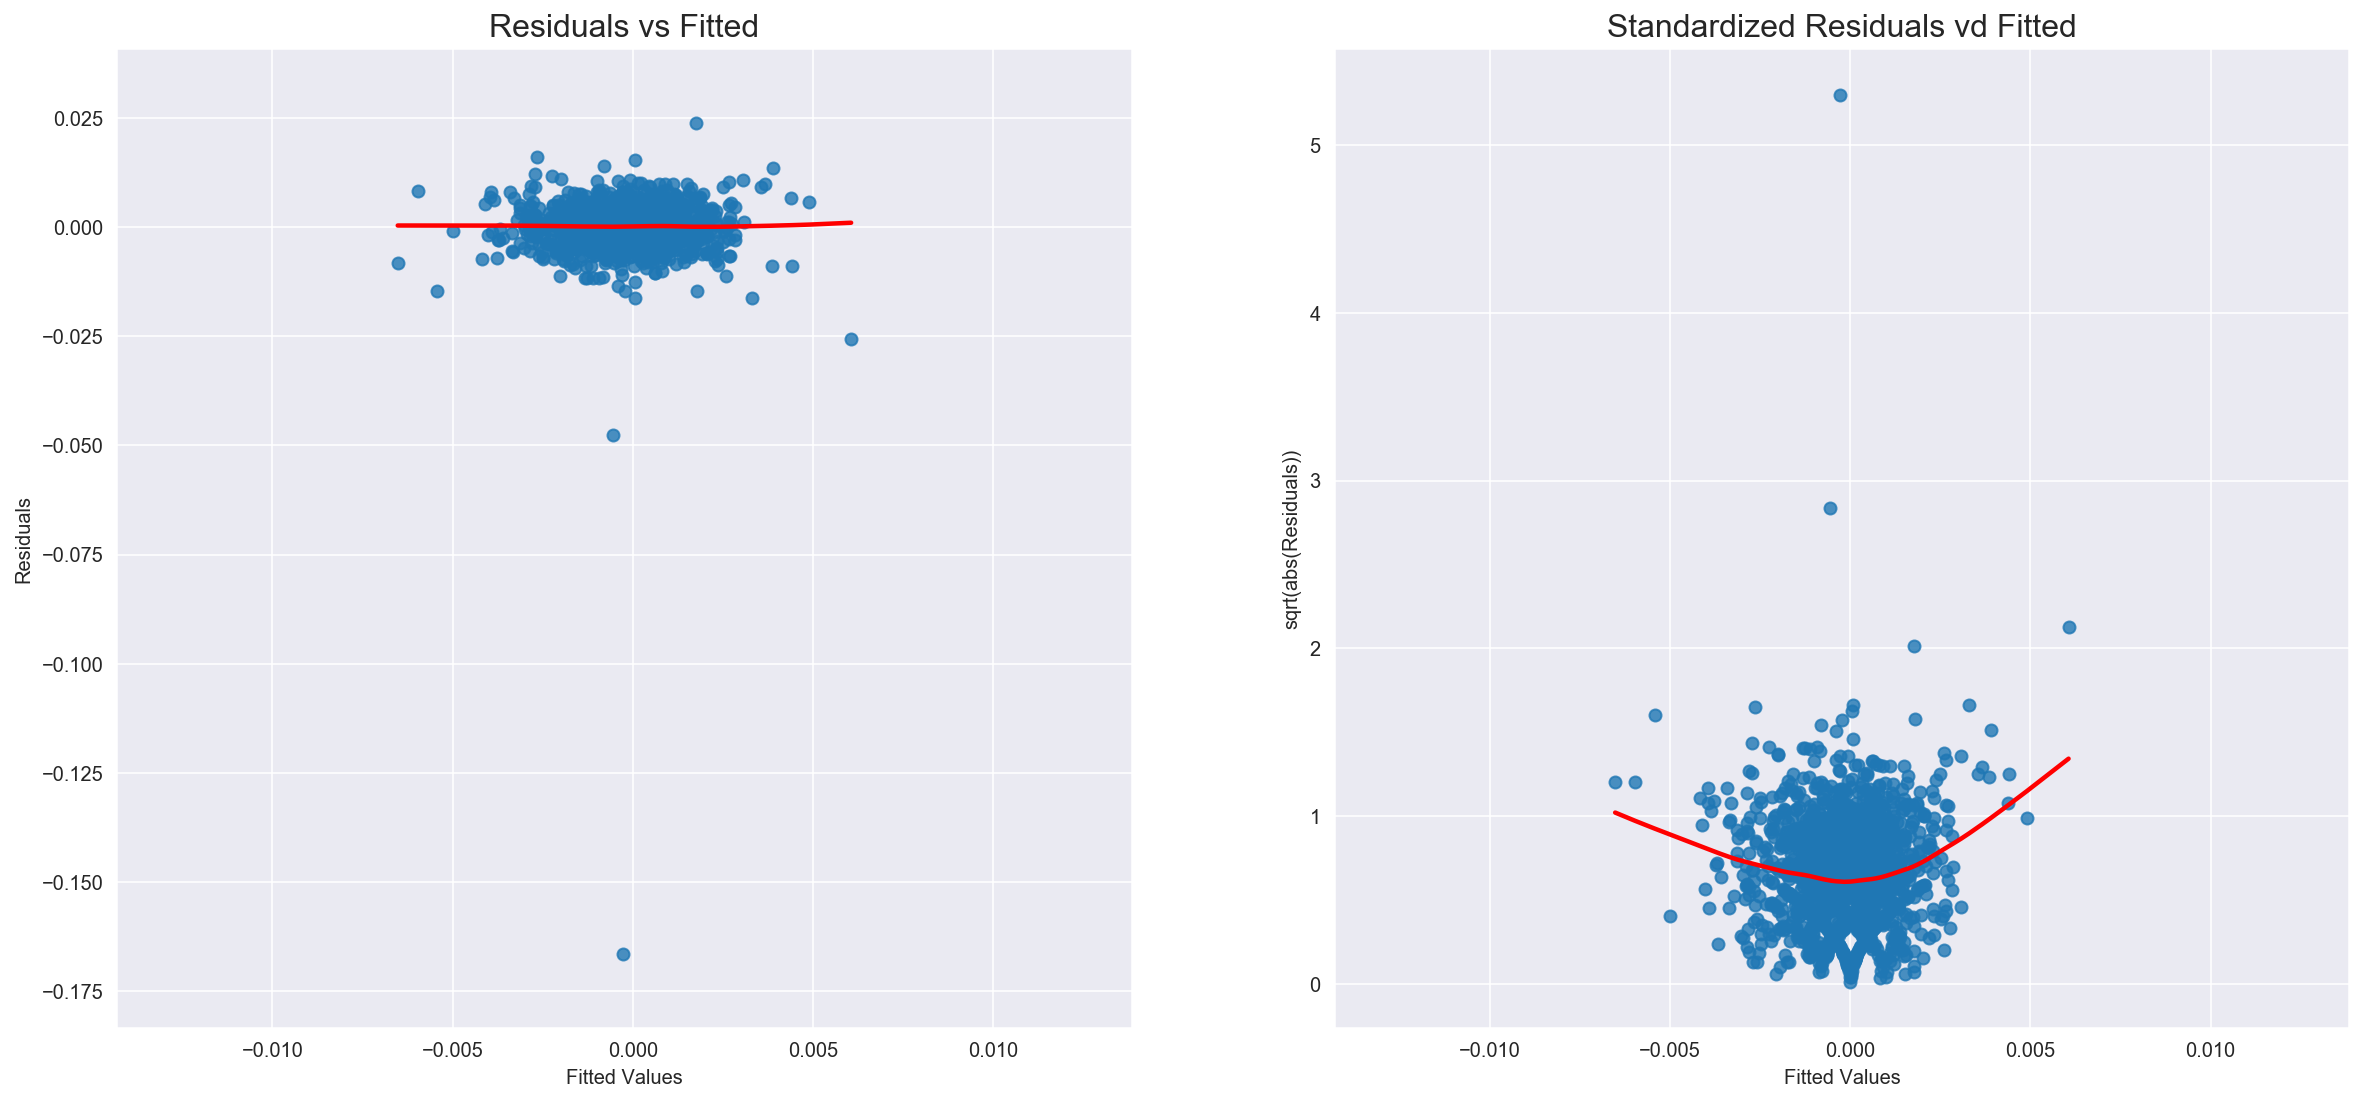

In [49]:
homoscedasticity_test(result_p_m)

Durbin-Watson: 1.9623593087965796
Little to no autocorrelation 

Assumption satisfied


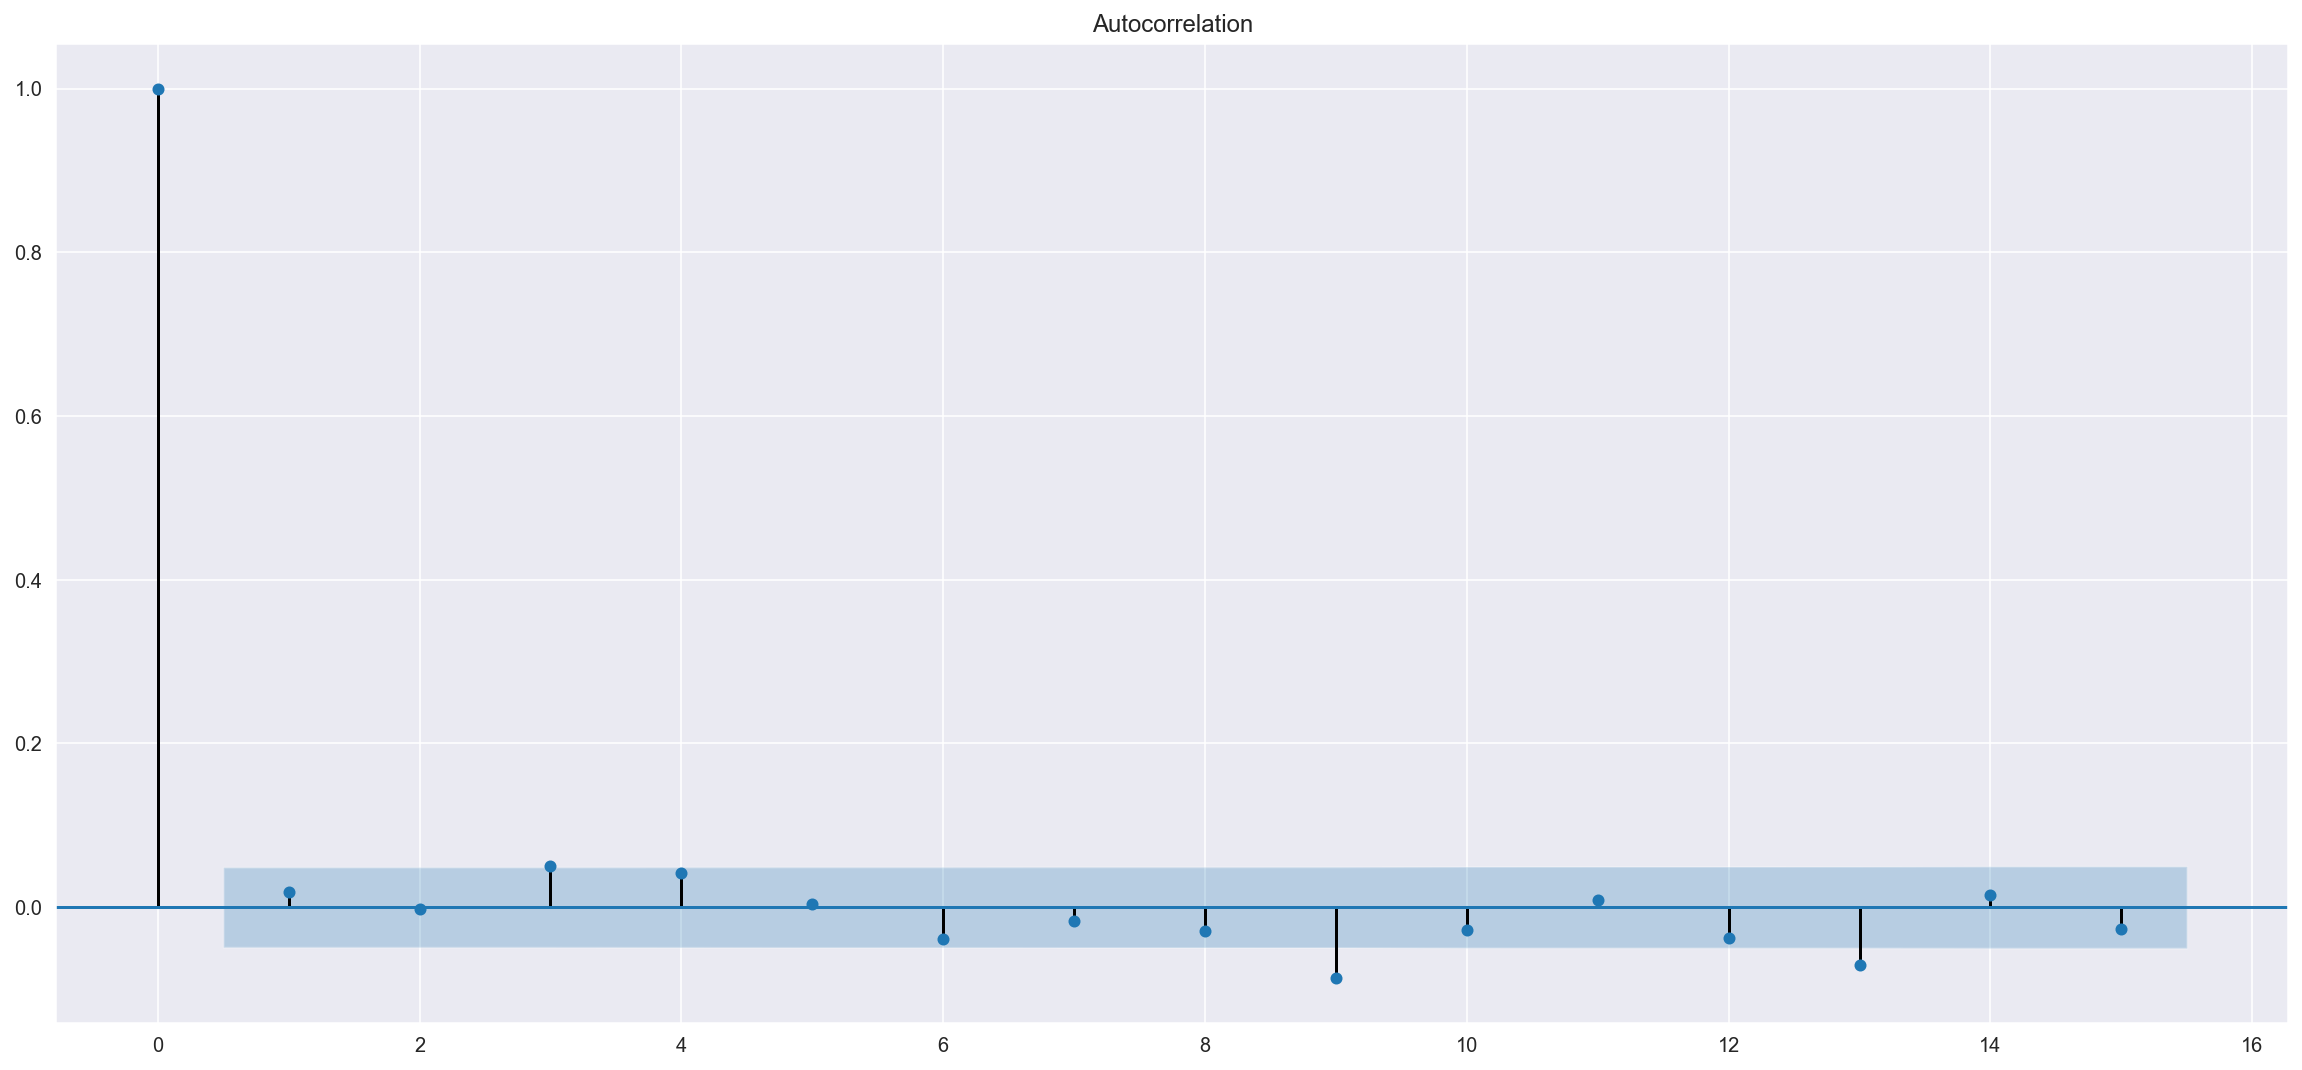

In [50]:
# check autocorrelation of error terms
autocorrelation_test(resid_m)

Variance is not constant, no autocorrelation though.

#### Test Normality:

In [51]:
print(f'residual mean: {resid_p_m.mean()}')
print(f'residual std: {resid_p_m.std()}')
s = pd.DataFrame(np.random.normal(resid_p_m.mean(), resid_p_m.std(), len(resid_p_m)))
print(f'skewness: \n   residual: {resid_p_m.skew()} \n   normal: {s[0].skew()}')
print(f'kurtosis: \n   residual: {resid_p_m.kurtosis()} \n   normal: {s[0].kurtosis()}')

residual mean: 2.0738910796235802e-19
residual std: 0.005917780424737924
skewness: 
   residual: -14.209270135692037 
   normal: -0.00888646772194546
kurtosis: 
   residual: 391.8285050488637 
   normal: 0.07347369292329953


Non-normal


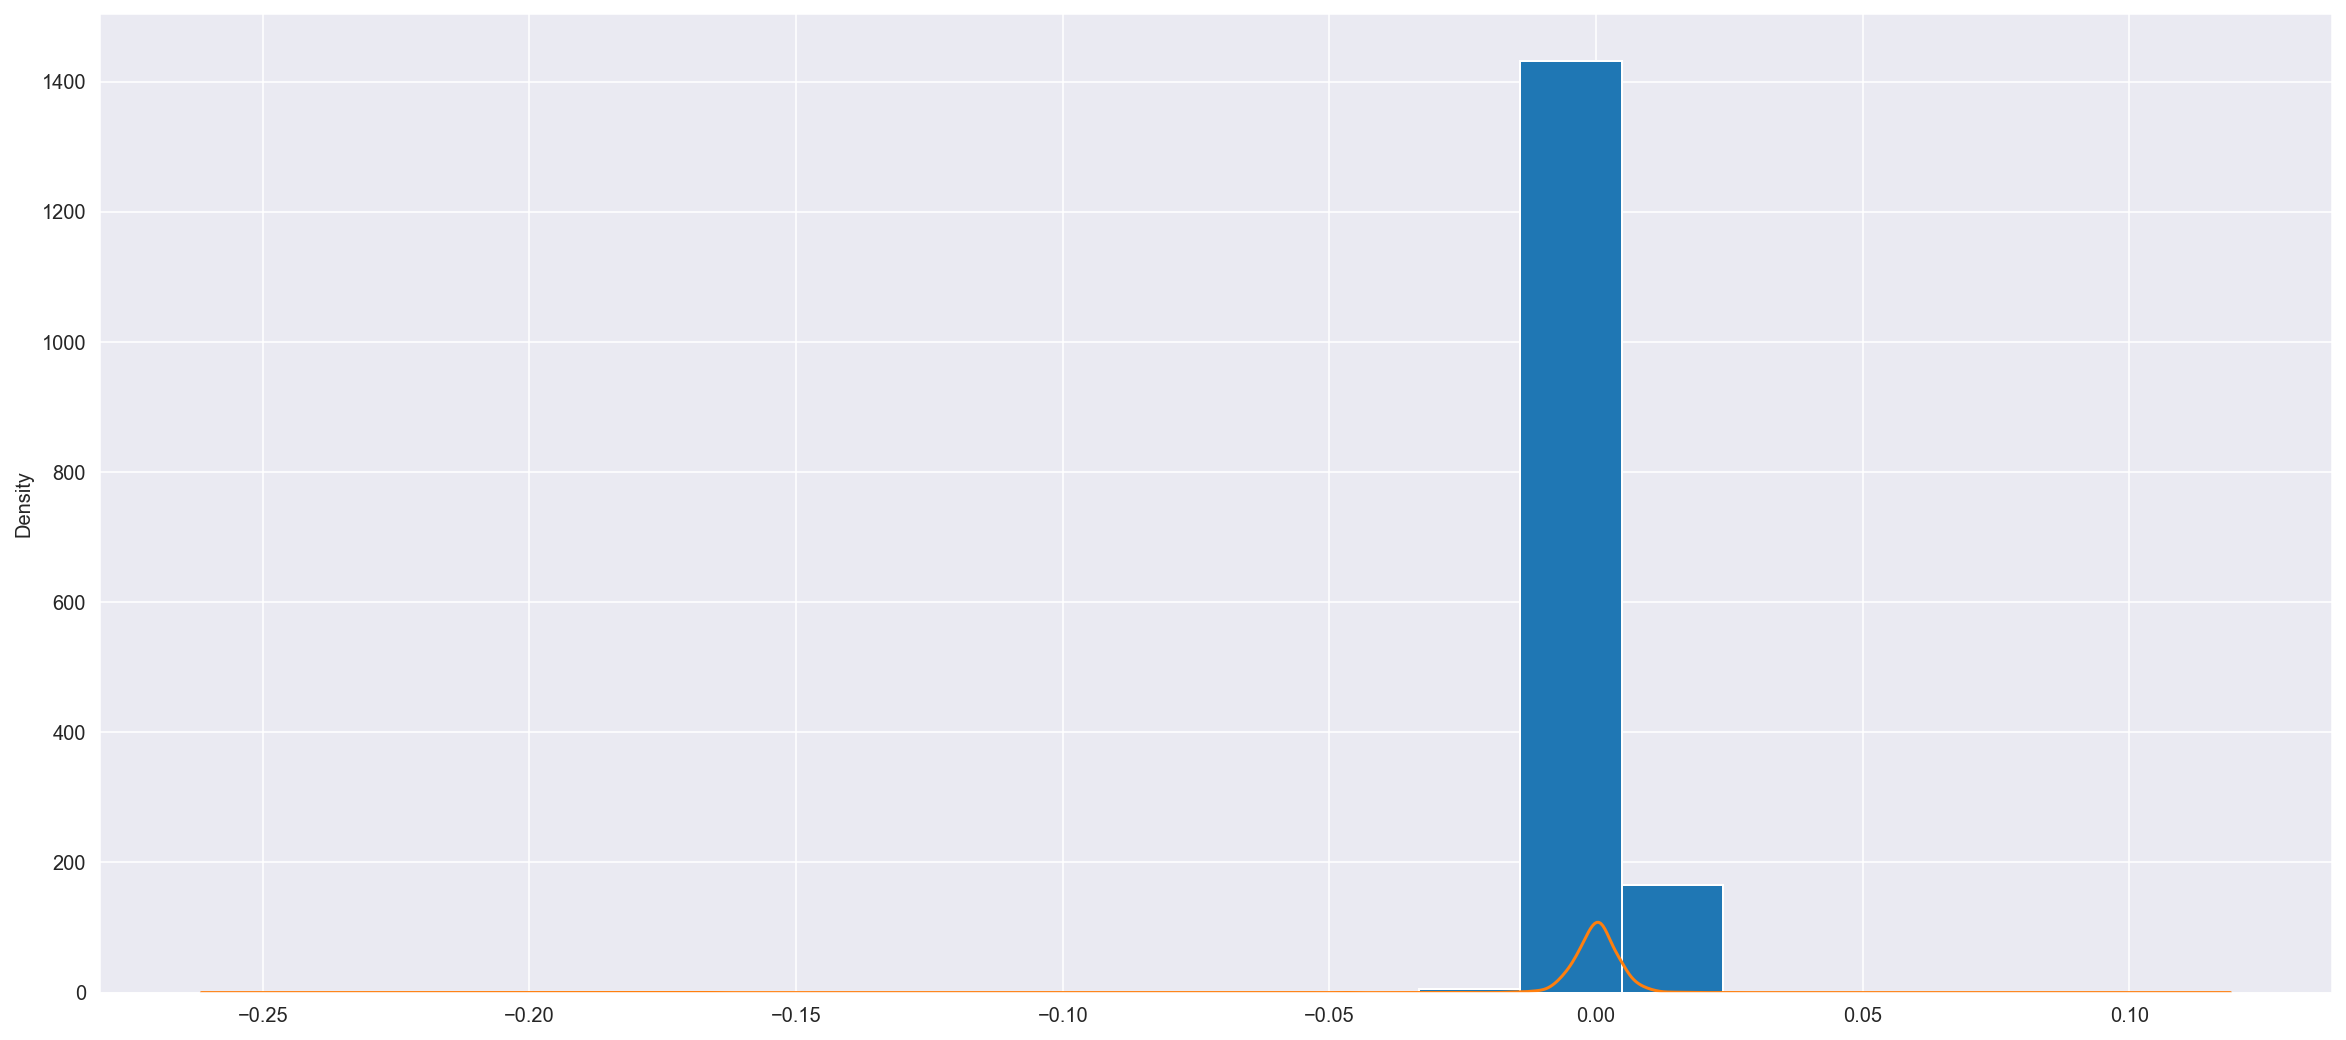

In [52]:
normality_test(resid_p_m)

Graphically, normality is roughly satisfied. But we can see residuals is more likely having fat tails. Not great.

### Financial/economic interpretation 

Classic Linear Regression assumptions do not perform well in monthly 10 industry scenario since 
- there are some industries are highly correlated with each other
- limited observations in monthly data

In short, 10 indestry portfolio model cannot explain the AQR monthly return very well.

One take-away:

when doing research on industry portfolios, we need to pay attention on the relationships among industries. In other words, when we allocate our portfolio, we want not only to optimize upon equity returns, but also pay attention to equity industry to ensure an enough diversification of our portfolio. 

#### Explanation:

Classic OLS assumptions are much more satisfied with Daily data than Monthly data. Also, the 5-factor model works better with daily data than monthly data. This is mainly because we have an enough sample size from daily scenario. Monthly data does not contain much valuable information. 

According to estimated coefs, we can tell ``RMW`` is the most significant factors (positively) influencing AQR daily return, and then the `MktRet` also with positive influence on AQR return.

``RMW``:

**RMW (Robust Minus Weak)** is the average return on the two robust operating profitability portfolios minus the average return on the two weak operating profitability portfolios using the measure of ROE ratio.

Guess: as long as we see an increase in ``RMW`` or ``MktRet``, we might can expect an increase in AQR daily return. But definitely we need a more robust model that also explain the return variaions very well (high R2).